<a href="https://colab.research.google.com/github/SMRayeed/Stock-Data-Analysis/blob/main/Nov26_lstm_gru_inidcators_top20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import pandas as pd
import numpy as np
from numpy import array
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU
from statsmodels.tsa.arima.model import ARIMA

from itertools import cycle
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import yfinance as yf

## T E S L A

#### Company Data

In [467]:
company = "TSLA"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [468]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [469]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [470]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [471]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [472]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [473]:
data.head(5)

date       open       high        low      close  adj_close     volume
0 2020-01-02  28.299999  28.713333  28.114000  28.684000  28.684000  142981500
1 2020-01-03  29.366667  30.266666  29.128000  29.534000  29.534000  266677500
2 2020-01-06  29.364668  30.104000  29.333332  30.102667  30.102667  151995000
3 2020-01-07  30.760000  31.441999  30.224001  31.270666  31.270666  268231500
4 2020-01-08  31.580000  33.232666  31.215334  32.809334  32.809334  467164500

#### Indicators

In [474]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [475]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [476]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [477]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [478]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [479]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [480]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [481]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [482]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [483]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [484]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [485]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [486]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [487]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [488]:
data.head(5)

date       open       high        low      close  adj_close  \
0 2020-01-02  28.299999  28.713333  28.114000  28.684000  28.684000   
1 2020-01-03  29.366667  30.266666  29.128000  29.534000  29.534000   
2 2020-01-06  29.364668  30.104000  29.333332  30.102667  30.102667   
3 2020-01-07  30.760000  31.441999  30.224001  31.270666  31.270666   
4 2020-01-08  31.580000  33.232666  31.215334  32.809334  32.809334   

      volume  ma7  ma21      26ema  ...  close_60  Log_Returns  Vola10d  \
0  142981500  NaN   NaN  28.684000  ...       NaN          NaN      NaN   
1  266677500  NaN   NaN  29.125346  ...       NaN     0.029203      NaN   
2  151995000  NaN   NaN  29.476488  ...       NaN     0.019072      NaN   
3  268231500  NaN   NaN  29.978062  ...       NaN     0.038067      NaN   
4  467164500  NaN   NaN  30.634646  ...       NaN     0.048033      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN        0.865119         NaN         NaN         NaN  NaN  
2      NaN      NaN       -0.430042         NaN         NaN         NaN  NaN  
3      NaN      NaN        0.764739         NaN         NaN         NaN  NaN  
4      NaN      NaN        0.741647         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [489]:
data = data.ffill().bfill()

#### Preprocessing

In [490]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [491]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [492]:
df_indicators

date       close     volume         ma7        ma21       26ema  \
0   2020-01-02   28.684000  142981500   30.909524   35.243936   28.684000   
1   2020-01-03   29.534000  266677500   30.909524   35.243936   29.125346   
2   2020-01-06   30.102667  151995000   30.909524   35.243936   29.476488   
3   2020-01-07   31.270666  268231500   30.909524   35.243936   29.978062   
4   2020-01-08   32.809334  467164500   30.909524   35.243936   30.634646   
..         ...         ...        ...         ...         ...         ...   
751 2022-12-23  123.150002  166989700  140.234286  166.041905  165.275890   
752 2022-12-27  109.099998  208643400  133.295714  162.529524  161.114713   
753 2022-12-28  112.709999  221070500  127.935715  159.186191  157.529179   
754 2022-12-29  121.820000  221923300  123.928573  156.376191  154.884054   
755 2022-12-30  123.180000  157777300  121.840001  152.970476  152.535606   

          12ema       MACD       20sd  upper_band  ...    close_60  \
0     28.684000   0.000000   3.603846   42.045259  ...   41.697144   
1     29.144417   0.019071   3.603846   42.045259  ...   41.697144   
2     29.518422   0.041934   3.603846   42.045259  ...   41.697144   
3     30.071537   0.093475   3.603846   42.045259  ...   41.697144   
4     30.815387   0.180741   3.603846   42.045259  ...   41.697144   
..          ...        ...        ...         ...  ...         ...   
751  148.031122 -17.244768  22.371719  209.944438  ...  195.450334   
752  142.041718 -19.072995  25.204712  211.919424  ...  192.847834   
753  137.529146 -20.000032  26.995549  212.095097  ...  190.686334   
754  135.112354 -19.771700  26.713017  207.886034  ...  188.559334   
755  133.276608 -19.258998  25.814669  202.513339  ...  186.598834   

     Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  \
0       0.029203  0.606102  0.975432  1.214309        0.865119    9.421464   
1       0.029203  0.606102  0.975432  1.214309        0.865119    9.421464   
2       0.019072  0.606102  0.975432  1.214309       -0.430042    9.421464   
3       0.038067  0.606102  0.975432  1.214309        0.764739    9.421464   
4       0.048033  0.606102  0.975432  1.214309        0.741647    9.421464   
..           ...       ...       ...       ...             ...         ...   
751    -0.017707  0.555239  0.629949  0.642863       -0.205153    4.272560   
752    -0.121138  0.688963  0.688475  0.679976        0.249439    4.355063   
753     0.032553  0.786921  0.704424  0.668337        0.059561    3.317387   
754     0.077726  0.972776  0.750399  0.688591        0.003858    3.049045   
755     0.011102  0.978097  0.750763  0.688449       -0.289046    3.411380   

     Volu30d_ff  Volu60d_ff        atr  
0      9.917300    7.699974   1.653285  
1      9.917300    7.699974   1.653285  
2      9.917300    7.699974   1.653285  
3      9.917300    7.699974   1.653285  
4      9.917300    7.699974   1.653285  
..          ...         ...        ...  
751    4.491879    4.391398   9.692856  
752    4.496143    4.395667  10.126428  
753    4.433059    4.316031  10.157142  
754    4.431187    4.314512  10.494284  
755    4.443489    4.338313  10.179285  

[756 rows x 27 columns]

In [493]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [494]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [495]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.229674  0.216653  0.269587  0.370822  0.391849  0.317190   
754 2022-12-29  0.253282  0.217617  0.258683  0.362574  0.383805  0.310147   
755 2022-12-30  0.256806  0.145109  0.253000  0.352578  0.376663  0.304797   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.083223  0.487516    0.429376  ...  0.473973     0.643768  0.352440   
754  0.086828  0.482028    0.418886  ...  0.467206     0.751847  0.451578   
755  0.094923  0.464579    0.405496  ...  0.460969     0.592445  0.454416   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.406914  0.389032        0.216550    0.092866    0.241586    0.208425   
754  0.445731  0.409128        0.201439    0.074577    0.241369    0.208170   
755  0.446038  0.408987        0.121979    0.099272    0.242791    0.212167   

          atr  
753  0.367166  
754  0.381723  
755  0.368122  

[3 rows x 27 columns]

In [496]:
df_time_series = df_normalized.set_index('date')

In [497]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [498]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.506671  0.070915  0.544292  0.671523  0.717457  0.613862   
2022-05-26  0.548937  0.086587  0.537310  0.663427  0.710995  0.612327   
2022-05-27  0.593769  0.067700  0.543766  0.657936  0.708909  0.618784   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.000183  0.587002    0.708920    0.563960  ...  0.821154   
2022-05-26  0.025412  0.576845    0.699261    0.558204  ...  0.818112   
2022-05-27  0.071224  0.558027    0.689817    0.558480  ...  0.816704   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.679828  0.380881  0.484882  0.433219        0.209670   
2022-05-26     0.737292  0.432592  0.506745  0.448670        0.241212   
2022-05-27     0.735201  0.448162  0.532494  0.458496        0.157633   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.197003    0.343241    0.266425  0.776387  
2022-05-26    0.163346    0.339010    0.267165  0.797070  
2022-05-27    0.140940    0.343723    0.266621  0.763732  

[3 rows x 26 columns]

In [499]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [500]:
time_steps = 14

In [501]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [502]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [503]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [504]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 156ms/step - loss: 0.0175 - val_loss: 0.0101
Epoch 2/50
15/15 [==============================] - 1s 39ms/step - loss: 0.0065 - val_loss: 0.0037
Epoch 3/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 4/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 5/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 6/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 7/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 8/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 9/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 10/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 11

In [505]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 2s 11ms/step


#### L S T M

In [506]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [507]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 8s 110ms/step - loss: 0.0575 - val_loss: 0.0185
Epoch 2/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0100 - val_loss: 0.0322
Epoch 3/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0084 - val_loss: 0.0124
Epoch 4/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0065 - val_loss: 0.0089
Epoch 5/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0058 - val_loss: 0.0098
Epoch 6/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0048 - val_loss: 0.0143
Epoch 7/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0043 - val_loss: 0.0160
Epoch 8/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0038 - val_loss: 0.0116
Epoch 9/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0041 - val_loss: 0.0087
Epoch 10/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0038 - val_loss: 0.0112
Epoch 11

In [508]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 1s 6ms/step


#### Initial Reports

In [509]:
true_val = X_test[:,0,0]

In [510]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.506671196
Example 2 ---> Value 0.548937266
Example 3 ---> Value 0.593768857

             L S T M            
Example 1 ---> Value 0.548777461
Example 2 ---> Value 0.542642236
Example 3 ---> Value 0.534692109

              G R U             
Example 1 ---> Value 0.526958823
Example 2 ---> Value 0.540642262
Example 3 ---> Value 0.510628641


#### Inverse Scaling

In [511]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [512]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [513]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [514]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 219.600006104
Example 2 ---> Value 235.910003662
Example 3 ---> Value 253.210006714

             L S T M            
Example 1 ---> Value 235.848327637
Example 2 ---> Value 233.480819702
Example 3 ---> Value 230.412963867

              G R U             
Example 1 ---> Value 227.428771973
Example 2 ---> Value 232.709060669
Example 3 ---> Value 221.127136230


In [515]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.506671  0.070915  0.544292  0.671523  0.717457  0.613862   
2022-05-26  0.548937  0.086587  0.537310  0.663427  0.710995  0.612327   
2022-05-27  0.593769  0.067700  0.543766  0.657936  0.708909  0.618784   
2022-05-31  0.592585  0.081965  0.550095  0.652695  0.706875  0.624043   
2022-06-01  0.577132  0.054083  0.560004  0.645121  0.703648  0.625820   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.000183  0.587002    0.708920    0.563960  ...  0.821154   
2022-05-26  0.025412  0.576845    0.699261    0.558204  ...  0.818112   
2022-05-27  0.071224  0.558027    0.689817    0.558480  ...  0.816704   
2022-05-31  0.110276  0.520243    0.674111    0.563253  ...  0.815289   
2022-06-01  0.136653  0.471106    0.654487    0.570496  ...  0.814155   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.679828  0.380881  0.484882  0.433219        0.209670   
2022-05-26     0.737292  0.432592  0.506745  0.448670        0.241212   
2022-05-27     0.735201  0.448162  0.532494  0.458496        0.157633   
2022-05-31     0.561563  0.417451  0.529240  0.458495        0.238731   
2022-06-01     0.508757  0.402307  0.525154  0.455441        0.134733   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.197003    0.343241    0.266425  0.776387  
2022-05-26    0.163346    0.339010    0.267165  0.797070  
2022-05-27    0.140940    0.343723    0.266621  0.763732  
2022-05-31    0.141311    0.341164    0.267199  0.757009  
2022-06-01    0.156604    0.349156    0.273281  0.714336  

[5 rows x 26 columns]

In [516]:
test.reset_index(inplace=True)

In [517]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.506671  0.070915  0.544292  0.671523  0.717457  0.613862   
1 2022-05-26  0.548937  0.086587  0.537310  0.663427  0.710995  0.612327   
2 2022-05-27  0.593769  0.067700  0.543766  0.657936  0.708909  0.618784   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.000183  0.587002    0.708920  ...  0.821154     0.679828  0.380881   
1  0.025412  0.576845    0.699261  ...  0.818112     0.737292  0.432592   
2  0.071224  0.558027    0.689817  ...  0.816704     0.735201  0.448162   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.484882  0.433219        0.209670    0.197003    0.343241    0.266425   
1  0.506745  0.448670        0.241212    0.163346    0.339010    0.267165   
2  0.532494  0.458496        0.157633    0.140940    0.343723    0.266621   

        atr  
0  0.776387  
1  0.797070  
2  0.763732  

[3 rows x 27 columns]

In [518]:
results = pd.DataFrame()

In [519]:
results['date'] = test['date'].tail(len(X_test))

In [520]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [521]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [522]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  182.919998  164.493256  183.701324
143 2022-12-19  180.830002  160.807266  180.217316
144 2022-12-20  194.699997  160.289703  177.246109
145 2022-12-21  194.699997  151.304901  173.764755
146 2022-12-22  194.860001  148.807999  170.162720
147 2022-12-23  182.449997  140.011917  166.079620
148 2022-12-27  179.820007  138.191238  162.123489
149 2022-12-28  174.039993  128.353394  158.043228
150 2022-12-29  173.440002  128.348694  154.652954
151 2022-12-30  179.050003  133.874268  152.460342

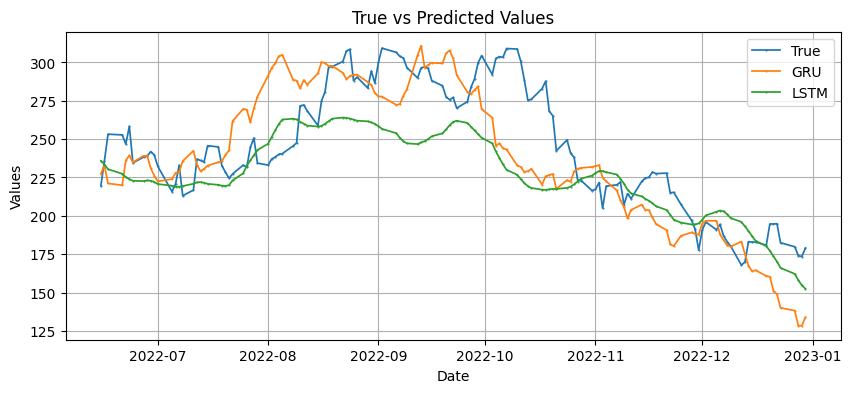

In [523]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

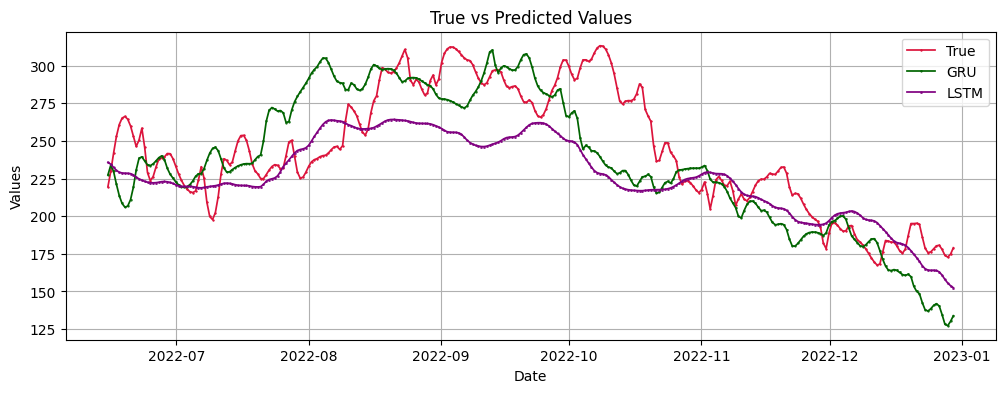

In [524]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## A M A Z O N

#### Company Data

In [525]:
company = "AMZN"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [526]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [527]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [528]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [529]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [530]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [531]:
data.head(5)

date       open       high        low      close  adj_close    volume
0 2020-01-02  93.750000  94.900497  93.207497  94.900497  94.900497  80580000
1 2020-01-03  93.224998  94.309998  93.224998  93.748497  93.748497  75288000
2 2020-01-06  93.000000  95.184502  93.000000  95.143997  95.143997  81236000
3 2020-01-07  95.224998  95.694504  94.601997  95.343002  95.343002  80898000
4 2020-01-08  94.902000  95.550003  94.321999  94.598503  94.598503  70160000

#### Indicators

In [532]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [533]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [534]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [535]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [536]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [537]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [538]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [539]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [540]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [541]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [542]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [543]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [544]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [545]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [546]:
data.head(5)

date       open       high        low      close  adj_close    volume  \
0 2020-01-02  93.750000  94.900497  93.207497  94.900497  94.900497  80580000   
1 2020-01-03  93.224998  94.309998  93.224998  93.748497  93.748497  75288000   
2 2020-01-06  93.000000  95.184502  93.000000  95.143997  95.143997  81236000   
3 2020-01-07  95.224998  95.694504  94.601997  95.343002  95.343002  80898000   
4 2020-01-08  94.902000  95.550003  94.321999  94.598503  94.598503  70160000   

   ma7  ma21      26ema  ...  close_60  Log_Returns  Vola10d  Vola30d  \
0  NaN   NaN  94.900497  ...       NaN          NaN      NaN      NaN   
1  NaN   NaN  94.302343  ...       NaN    -0.012213      NaN      NaN   
2  NaN   NaN  94.604741  ...       NaN     0.014776      NaN      NaN   
3  NaN   NaN  94.811127  ...       NaN     0.002089      NaN      NaN   
4  NaN   NaN  94.761819  ...       NaN    -0.007839      NaN      NaN   

   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN       -0.065674         NaN         NaN         NaN  NaN  
2      NaN        0.079003         NaN         NaN         NaN  NaN  
3      NaN       -0.004161         NaN         NaN         NaN  NaN  
4      NaN       -0.132735         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [547]:
data = data.ffill().bfill()

#### Preprocessing

In [548]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [549]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [550]:
df_indicators

date      close    volume        ma7       ma21      26ema  \
0   2020-01-02  94.900497  80580000  94.706427  94.211880  94.900497   
1   2020-01-03  93.748497  75288000  94.706427  94.211880  94.302343   
2   2020-01-06  95.143997  81236000  94.706427  94.211880  94.604741   
3   2020-01-07  95.343002  80898000  94.706427  94.211880  94.811127   
4   2020-01-08  94.598503  70160000  94.706427  94.211880  94.761819   
..         ...        ...       ...        ...        ...        ...   
751 2022-12-23  85.250000  57433700  86.032857  89.998095  90.861676   
752 2022-12-27  83.040001  57284000  85.260000  89.504285  90.282293   
753 2022-12-28  81.820000  58228600  84.397143  88.926666  89.655457   
754 2022-12-29  84.180000  54995900  84.291429  88.534285  89.249867   
755 2022-12-30  84.000000  62401200  84.121428  87.937143  88.860988   

         12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0    94.900497  0.000000  0.988431   95.877536  ...   96.752899    -0.012213   
1    94.276497 -0.025846  0.988431   95.877536  ...   96.752899    -0.012213   
2    94.615083  0.010341  0.988431   95.877536  ...   96.752899     0.014776   
3    94.844858  0.033732  0.988431   95.877536  ...   96.752899     0.002089   
4    94.777925  0.016106  0.988431   95.877536  ...   96.752899    -0.007839   
..         ...       ...       ...         ...  ...         ...          ...   
751  87.549636 -3.312041  3.662255   97.152010  ...  100.053667     0.017274   
752  86.855846 -3.426447  3.824808   96.931615  ...   99.554333    -0.026266   
753  86.081100 -3.574356  4.092164   96.936328  ...   98.986667    -0.014801   
754  85.788623 -3.461244  3.775141   95.684281  ...   98.371500     0.028436   
755  85.513450 -3.347538  3.456508   94.472016  ...   97.755667    -0.002141   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.147441  0.262922  0.460419       -0.065674    1.863675    8.354153   
1    0.147441  0.262922  0.460419       -0.065674    1.863675    8.354153   
2    0.147441  0.262922  0.460419        0.079003    1.863675    8.354153   
3    0.147441  0.262922  0.460419       -0.004161    1.863675    8.354153   
4    0.147441  0.262922  0.460419       -0.132735    1.863675    8.354153   
..        ...       ...       ...             ...         ...         ...   
751  0.370301  0.344651  0.494835       -0.294697    6.435457    5.706543   
752  0.365360  0.320966  0.496277       -0.002606    6.403083    5.597351   
753  0.325510  0.318122  0.492600        0.016490    5.596582    5.582856   
754  0.384778  0.332336  0.486888       -0.055517    5.363833    5.581970   
755  0.356001  0.330077  0.486849        0.134652    5.306853    5.544954   

     Volu60d_ff       atr  
0      6.711226  1.394180  
1      6.711226  1.394180  
2      6.711226  1.394180  
3      6.711226  1.394180  
4      6.711226  1.394180  
..          ...       ...  
751    5.856877  3.146428  
752    5.857308  3.089999  
753    5.843258  3.045714  
754    5.836273  3.027857  
755    5.807959  3.027142  

[756 rows x 27 columns]

In [551]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [552]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [553]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.000000  0.103400  0.002733  0.010625  0.008830  0.005926   
754 2022-12-29  0.022530  0.091949  0.001685  0.006412  0.004322  0.002873   
755 2022-12-30  0.020811  0.118180  0.000000  0.000000  0.000000  0.000000   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.430710  0.184652    0.025148  ...  0.029216     0.490745  0.281209   
754  0.436211  0.165791    0.012371  ...  0.021170     0.646077  0.355802   
755  0.441740  0.146835    0.000000  ...  0.013116     0.536228  0.319585   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.307767  0.727947        0.189915    0.271023    0.371937    0.503273   
754  0.333162  0.714209        0.169802    0.254951    0.371816    0.501564   
755  0.329126  0.714117        0.222918    0.251016    0.366737    0.494636   

          atr  
753  0.249909  
754  0.247300  
755  0.247196  

[3 rows x 27 columns]

In [554]:
df_time_series = df_normalized.set_index('date')

In [555]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [556]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.238233  0.226993  0.236444  0.294447  0.346307  0.259396   
2022-05-26  0.279307  0.226575  0.230368  0.280595  0.338945  0.260549   
2022-05-27  0.318151  0.228906  0.241745  0.265537  0.335477  0.268060   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.134704  0.539375    0.406718    0.160051  ...  0.574145   
2022-05-26  0.172290  0.362248    0.328852    0.205122  ...  0.565213   
2022-05-27  0.222448  0.331197    0.313539    0.211307  ...  0.558073   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.635070  0.617942  0.942302  0.881081        0.158679   
2022-05-26     0.685843  0.653285  0.951373  0.898455        0.184955   
2022-05-27     0.673171  0.603582  0.973096  0.908680        0.187285   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.119072    0.347934    0.223914  0.647826  
2022-05-26    0.106170    0.347384    0.224191  0.647007  
2022-05-27    0.079516    0.346688    0.212048  0.618775  

[3 rows x 26 columns]

In [557]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [558]:
time_steps = 14

In [559]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [560]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [561]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [562]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 8s 127ms/step - loss: 0.0628 - val_loss: 0.0148
Epoch 2/50
15/15 [==============================] - 1s 39ms/step - loss: 0.0125 - val_loss: 0.0112
Epoch 3/50
15/15 [==============================] - 1s 38ms/step - loss: 0.0089 - val_loss: 0.0119
Epoch 4/50
15/15 [==============================] - 1s 38ms/step - loss: 0.0061 - val_loss: 0.0107
Epoch 5/50
15/15 [==============================] - 1s 39ms/step - loss: 0.0066 - val_loss: 0.0087
Epoch 6/50
15/15 [==============================] - 1s 43ms/step - loss: 0.0051 - val_loss: 0.0079
Epoch 7/50
15/15 [==============================] - 1s 41ms/step - loss: 0.0051 - val_loss: 0.0070
Epoch 8/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0055 - val_loss: 0.0081
Epoch 9/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0047 - val_loss: 0.0066
Epoch 10/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 11

In [563]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 6ms/step


#### L S T M

In [564]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [565]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 10s 110ms/step - loss: 0.1011 - val_loss: 0.0239
Epoch 2/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0191 - val_loss: 0.0226
Epoch 3/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0128 - val_loss: 0.0220
Epoch 4/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0119 - val_loss: 0.0213
Epoch 5/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0090 - val_loss: 0.0246
Epoch 6/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0095 - val_loss: 0.0210
Epoch 7/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0089 - val_loss: 0.0197
Epoch 8/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0086 - val_loss: 0.0176
Epoch 9/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0084 - val_loss: 0.0168
Epoch 10/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0077 - val_loss: 0.0154
Epoch 1

In [566]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 1s 10ms/step


#### Initial Reports

In [567]:
true_val = X_test[:,0,0]

In [568]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.238232780
Example 2 ---> Value 0.279306551
Example 3 ---> Value 0.318151238

             L S T M            
Example 1 ---> Value 0.434724480
Example 2 ---> Value 0.420920700
Example 3 ---> Value 0.406849802

              G R U             
Example 1 ---> Value 0.323423445
Example 2 ---> Value 0.322098225
Example 3 ---> Value 0.304017872


#### Inverse Scaling

In [569]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [570]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [571]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [572]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 106.775001526
Example 2 ---> Value 111.077499390
Example 3 ---> Value 115.146499634

             L S T M            
Example 1 ---> Value 127.357604980
Example 2 ---> Value 125.911651611
Example 3 ---> Value 124.437713623

              G R U             
Example 1 ---> Value 115.698760986
Example 2 ---> Value 115.559951782
Example 3 ---> Value 113.666023254


In [573]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.238233  0.226993  0.236444  0.294447  0.346307  0.259396   
2022-05-26  0.279307  0.226575  0.230368  0.280595  0.338945  0.260549   
2022-05-27  0.318151  0.228906  0.241745  0.265537  0.335477  0.268060   
2022-05-31  0.366485  0.409468  0.259998  0.263455  0.336434  0.282547   
2022-06-01  0.380561  0.348874  0.279955  0.262015  0.338534  0.297174   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.134704  0.539375    0.406718    0.160051  ...  0.574145   
2022-05-26  0.172290  0.362248    0.328852    0.205122  ...  0.565213   
2022-05-27  0.222448  0.331197    0.313539    0.211307  ...  0.558073   
2022-05-31  0.285740  0.309319    0.303844    0.216795  ...  0.552529   
2022-06-01  0.344680  0.294508    0.297452    0.220686  ...  0.549092   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.635070  0.617942  0.942302  0.881081        0.158679   
2022-05-26     0.685843  0.653285  0.951373  0.898455        0.184955   
2022-05-27     0.673171  0.603582  0.973096  0.908680        0.187285   
2022-05-31     0.698513  0.628023  1.000000  0.927062        0.337322   
2022-06-01     0.587718  0.595137  0.984534  0.901536        0.152275   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.119072    0.347934    0.223914  0.647826  
2022-05-26    0.106170    0.347384    0.224191  0.647007  
2022-05-27    0.079516    0.346688    0.212048  0.618775  
2022-05-31    0.133410    0.367286    0.238035  0.633137  
2022-06-01    0.143015    0.370503    0.225255  0.625228  

[5 rows x 26 columns]

In [574]:
test.reset_index(inplace=True)

In [575]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.238233  0.226993  0.236444  0.294447  0.346307  0.259396   
1 2022-05-26  0.279307  0.226575  0.230368  0.280595  0.338945  0.260549   
2 2022-05-27  0.318151  0.228906  0.241745  0.265537  0.335477  0.268060   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.134704  0.539375    0.406718  ...  0.574145     0.635070  0.617942   
1  0.172290  0.362248    0.328852  ...  0.565213     0.685843  0.653285   
2  0.222448  0.331197    0.313539  ...  0.558073     0.673171  0.603582   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.942302  0.881081        0.158679    0.119072    0.347934    0.223914   
1  0.951373  0.898455        0.184955    0.106170    0.347384    0.224191   
2  0.973096  0.908680        0.187285    0.079516    0.346688    0.212048   

        atr  
0  0.647826  
1  0.647007  
2  0.618775  

[3 rows x 27 columns]

In [576]:
results = pd.DataFrame()

In [577]:
results['date'] = test['date'].tail(len(X_test))

In [578]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [579]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [580]:
results.tail(10)

date       true        gru        lstm
142 2022-12-16  93.949997  95.156311  103.665253
143 2022-12-19  92.419998  93.863152  103.178635
144 2022-12-20  96.540001  92.516106  102.241936
145 2022-12-21  95.500000  91.261414  101.517136
146 2022-12-22  94.129997  90.794365  100.348740
147 2022-12-23  91.010002  89.635071   99.114746
148 2022-12-27  88.250000  89.299332   97.968102
149 2022-12-28  88.459999  88.687279   96.821014
150 2022-12-29  90.349998  87.528801   95.442719
151 2022-12-30  89.089996  86.826553   94.310318

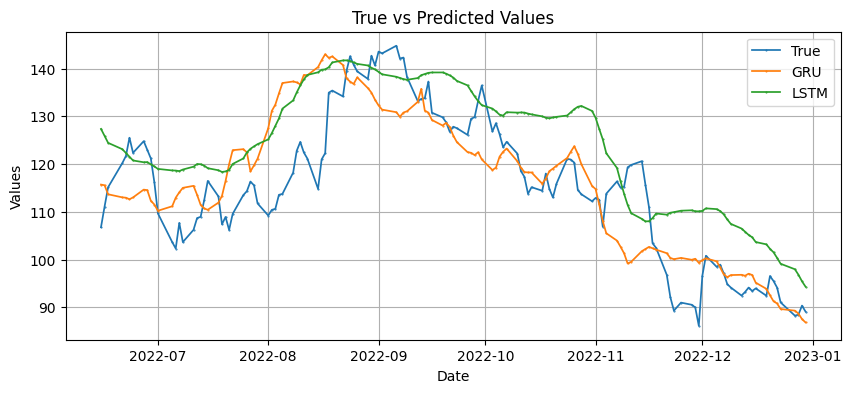

In [581]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

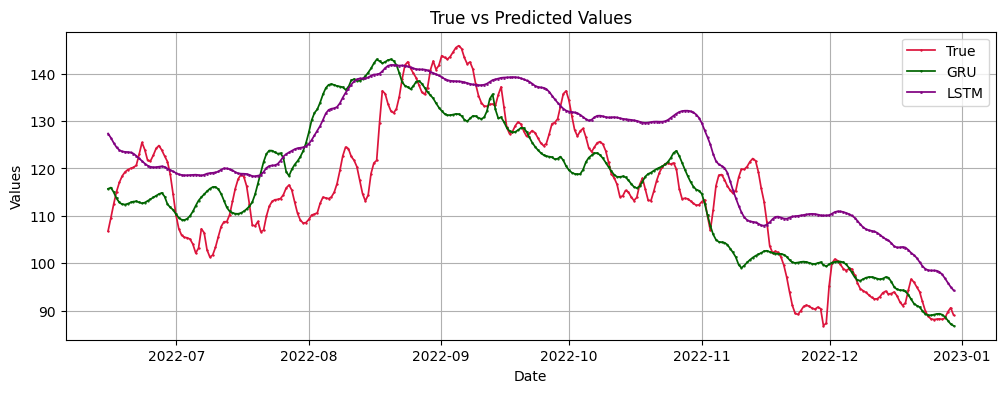

In [582]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## Alphabet Class A : G O O G L E

#### Company Data

In [583]:
company = "GOOGL"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [584]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [585]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [586]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [587]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [588]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [589]:
data.head(5)

date       open       high        low      close  adj_close    volume
0 2020-01-02  67.420502  68.433998  67.324501  68.433998  68.433998  27278000
1 2020-01-03  67.400002  68.687500  67.365997  68.075996  68.075996  23408000
2 2020-01-06  67.581497  69.916000  67.550003  69.890503  69.890503  46768000
3 2020-01-07  70.023003  70.175003  69.578003  69.755501  69.755501  34330000
4 2020-01-08  69.740997  70.592499  69.631500  70.251999  70.251999  35314000

#### Indicators

In [590]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [591]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [592]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [593]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [594]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [595]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [596]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [597]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [598]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [599]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [600]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [601]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [602]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [603]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [604]:
data.head(5)

date       open       high        low      close  adj_close    volume  \
0 2020-01-02  67.420502  68.433998  67.324501  68.433998  68.433998  27278000   
1 2020-01-03  67.400002  68.687500  67.365997  68.075996  68.075996  23408000   
2 2020-01-06  67.581497  69.916000  67.550003  69.890503  69.890503  46768000   
3 2020-01-07  70.023003  70.175003  69.578003  69.755501  69.755501  34330000   
4 2020-01-08  69.740997  70.592499  69.631500  70.251999  70.251999  35314000   

   ma7  ma21      26ema  ...  close_60  Log_Returns  Vola10d  Vola30d  \
0  NaN   NaN  68.433998  ...       NaN          NaN      NaN      NaN   
1  NaN   NaN  68.248113  ...       NaN    -0.005245      NaN      NaN   
2  NaN   NaN  68.838208  ...       NaN     0.026305      NaN      NaN   
3  NaN   NaN  69.094643  ...       NaN    -0.001933      NaN      NaN   
4  NaN   NaN  69.363038  ...       NaN     0.007092      NaN      NaN   

   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN       -0.141873         NaN         NaN         NaN  NaN  
2      NaN        0.997949         NaN         NaN         NaN  NaN  
3      NaN       -0.265951         NaN         NaN         NaN  NaN  
4      NaN        0.028663         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [605]:
data = data.ffill().bfill()

#### Preprocessing

In [606]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [607]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [608]:
df_indicators

date      close    volume        ma7       ma21      26ema  \
0   2020-01-02  68.433998  27278000  69.835071  71.807976  68.433998   
1   2020-01-03  68.075996  23408000  69.835071  71.807976  68.248113   
2   2020-01-06  69.890503  46768000  69.835071  71.807976  68.838208   
3   2020-01-07  69.755501  34330000  69.835071  71.807976  69.094643   
4   2020-01-08  70.251999  35314000  69.835071  71.807976  69.363038   
..         ...        ...       ...        ...        ...        ...   
751 2022-12-23  89.230003  23003000  89.307144  94.200953  93.225439   
752 2022-12-27  87.389999  20097300  88.811430  93.721429  92.793184   
753 2022-12-28  86.019997  19523200  88.205715  93.243810  92.291467   
754 2022-12-29  88.449997  23333500  88.207142  92.922857  92.006913   
755 2022-12-30  88.230003  23986300  88.094286  92.315239  91.727142   

         12ema      MACD      20sd  upper_band  ...   close_60  Log_Returns  \
0    68.433998  0.000000  1.825630   75.467686  ...  68.098717    -0.005245   
1    68.240081 -0.008032  1.825630   75.467686  ...  68.098717    -0.005245   
2    68.884241  0.046033  1.825630   75.467686  ...  68.098717     0.026305   
3    69.159264  0.064621  1.825630   75.467686  ...  68.098717    -0.001933   
4    69.456156  0.093117  1.825630   75.467686  ...  68.098717     0.007092   
..         ...       ...       ...         ...  ...        ...          ...   
751  91.163310 -2.062129  4.298695  102.635392  ...  95.545334     0.016612   
752  90.582801 -2.210383  4.516023  102.637047  ...  95.407667    -0.020836   
753  89.880831 -2.410636  4.803017  102.752534  ...  95.197334    -0.015801   
754  89.660703 -2.346211  4.536313  101.592126  ...  94.977500     0.027858   
755  89.440595 -2.286547  4.164348  100.210197  ...  94.757500    -0.002490   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.148350  0.208175  0.558071       -0.141873    5.903558    5.988165   
1    0.148350  0.208175  0.558071       -0.141873    5.903558    5.988165   
2    0.148350  0.208175  0.558071        0.997949    5.903558    5.988165   
3    0.148350  0.208175  0.558071       -0.265951    5.903558    5.988165   
4    0.148350  0.208175  0.558071        0.028663    5.903558    5.988165   
..        ...       ...       ...             ...         ...         ...   
751  0.326082  0.318773  0.426867       -0.168315    5.043154    7.336998   
752  0.331801  0.312261  0.427320       -0.126318    5.100501    7.255501   
753  0.284286  0.314170  0.422928       -0.028566    4.667702    7.247341   
754  0.344095  0.313845  0.422265        0.195168    4.539671    7.195541   
755  0.270745  0.313014  0.422265        0.027977    4.032051    7.118355   

     Volu60d_ff       atr  
0      4.939458  1.025464  
1      4.939458  1.025464  
2      4.939458  1.025464  
3      4.939458  1.025464  
4      4.939458  1.025464  
..          ...       ...  
751    6.471198  2.807144  
752    6.482051  2.725716  
753    6.470449  2.714287  
754    6.476520  2.764287  
755    6.448717  2.790715  

[756 rows x 27 columns]

In [609]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [610]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [611]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.342971  0.089660  0.358530  0.404606  0.382124  0.366514   
754 2022-12-29  0.367989  0.123117  0.358546  0.401068  0.378838  0.364104   
755 2022-12-30  0.365724  0.128849  0.357341  0.394370  0.375607  0.361694   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.293284  0.520109    0.452042  ...  0.397337     0.508711  0.203898   
754  0.300115  0.485292    0.439506  ...  0.394663     0.714578  0.263761   
755  0.306441  0.436733    0.424577  ...  0.391986     0.571476  0.190346   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.280788  0.552753        0.170504    0.193519    0.520584    0.464977   
754  0.280313  0.551359        0.230293    0.184887    0.513707    0.466196   
755  0.279098  0.551358        0.185614    0.150662    0.503460    0.460614   

          atr  
753  0.391814  
754  0.403197  
755  0.409214  

[3 rows x 27 columns]

In [612]:
df_time_series = df_normalized.set_index('date')

In [613]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [614]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.546663  0.271723  0.592574  0.631375  0.655452  0.601278   
2022-05-26  0.567125  0.251440  0.579338  0.627962  0.648466  0.595332   
2022-05-27  0.613701  0.251141  0.579974  0.624704  0.645867  0.597921   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.057280  0.421008    0.658672    0.598895  ...  0.775099   
2022-05-26  0.063836  0.427641    0.653974    0.592212  ...  0.769669   
2022-05-27  0.112764  0.427634    0.653004    0.591274  ...  0.765294   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.575871  0.327068  0.448947  0.469076        0.051023   
2022-05-26     0.670974  0.347124  0.450147  0.474276        0.162804   
2022-05-27     0.777081  0.378986  0.475568  0.496911        0.177898   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.404716    0.392821    0.307594  0.723133  
2022-05-26    0.390990    0.389971    0.306376  0.720995  
2022-05-27    0.369553    0.390136    0.306656  0.733671  

[3 rows x 26 columns]

In [615]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [616]:
time_steps = 14

In [617]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [618]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [619]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [620]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 8s 104ms/step - loss: 0.0215 - val_loss: 0.0038
Epoch 2/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0066 - val_loss: 0.0039
Epoch 3/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 4/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 5/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 6/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 7/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 8/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 10/50
15/15 [==============================] - 1s 41ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 11

In [621]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 6ms/step


#### L S T M

In [622]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [623]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 7s 111ms/step - loss: 0.0723 - val_loss: 0.0195
Epoch 2/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0133 - val_loss: 0.0077
Epoch 3/50
15/15 [==============================] - 1s 39ms/step - loss: 0.0091 - val_loss: 0.0049
Epoch 4/50
15/15 [==============================] - 1s 38ms/step - loss: 0.0074 - val_loss: 0.0047
Epoch 5/50
15/15 [==============================] - 1s 35ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 6/50
15/15 [==============================] - 1s 39ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 7/50
15/15 [==============================] - 1s 39ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 8/50
15/15 [==============================] - 1s 37ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 9/50
15/15 [==============================] - 1s 40ms/step - loss: 0.0048 - val_loss: 0.0154
Epoch 10/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 11

In [624]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### Initial Reports

In [625]:
true_val = X_test[:,0,0]

In [626]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.546663296
Example 2 ---> Value 0.567125174
Example 3 ---> Value 0.613700910

             L S T M            
Example 1 ---> Value 0.689408898
Example 2 ---> Value 0.688780665
Example 3 ---> Value 0.685218930

              G R U             
Example 1 ---> Value 0.615104437
Example 2 ---> Value 0.628908634
Example 3 ---> Value 0.606132627


#### Inverse Scaling

In [627]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [628]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [629]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [630]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 105.805000305
Example 2 ---> Value 107.792503357
Example 3 ---> Value 112.316497803

             L S T M            
Example 1 ---> Value 119.670166016
Example 2 ---> Value 119.609146118
Example 3 ---> Value 119.263183594

              G R U             
Example 1 ---> Value 112.452827454
Example 2 ---> Value 113.793655396
Example 3 ---> Value 111.581375122


In [631]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.546663  0.271723  0.592574  0.631375  0.655452  0.601278   
2022-05-26  0.567125  0.251440  0.579338  0.627962  0.648466  0.595332   
2022-05-27  0.613701  0.251141  0.579974  0.624704  0.645867  0.597921   
2022-05-31  0.628583  0.357369  0.585125  0.624522  0.644697  0.602546   
2022-06-01  0.629921  0.239657  0.592724  0.623109  0.643726  0.606679   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.057280  0.421008    0.658672    0.598895  ...  0.775099   
2022-05-26  0.063836  0.427641    0.653974    0.592212  ...  0.769669   
2022-05-27  0.112764  0.427634    0.653004    0.591274  ...  0.765294   
2022-05-31  0.168294  0.417709    0.649838    0.591389  ...  0.761615   
2022-06-01  0.217237  0.401726    0.645333    0.592151  ...  0.759083   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.575871  0.327068  0.448947  0.469076        0.051023   
2022-05-26     0.670974  0.347124  0.450147  0.474276        0.162804   
2022-05-27     0.777081  0.378986  0.475568  0.496911        0.177898   
2022-05-31     0.643518  0.381203  0.477698  0.497913        0.263409   
2022-06-01     0.588604  0.370329  0.471062  0.479065        0.106505   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.404716    0.392821    0.307594  0.723133  
2022-05-26    0.390990    0.389971    0.306376  0.720995  
2022-05-27    0.369553    0.390136    0.306656  0.733671  
2022-05-31    0.356914    0.378865    0.309330  0.732329  
2022-06-01    0.370164    0.386939    0.303626  0.744095  

[5 rows x 26 columns]

In [632]:
test.reset_index(inplace=True)

In [633]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.546663  0.271723  0.592574  0.631375  0.655452  0.601278   
1 2022-05-26  0.567125  0.251440  0.579338  0.627962  0.648466  0.595332   
2 2022-05-27  0.613701  0.251141  0.579974  0.624704  0.645867  0.597921   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.057280  0.421008    0.658672  ...  0.775099     0.575871  0.327068   
1  0.063836  0.427641    0.653974  ...  0.769669     0.670974  0.347124   
2  0.112764  0.427634    0.653004  ...  0.765294     0.777081  0.378986   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.448947  0.469076        0.051023    0.404716    0.392821    0.307594   
1  0.450147  0.474276        0.162804    0.390990    0.389971    0.306376   
2  0.475568  0.496911        0.177898    0.369553    0.390136    0.306656   

        atr  
0  0.723133  
1  0.720995  
2  0.733671  

[3 rows x 27 columns]

In [634]:
results = pd.DataFrame()

In [635]:
results['date'] = test['date'].tail(len(X_test))

In [636]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [637]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [638]:
results.tail(10)

date        true        gru       lstm
142 2022-12-16   96.050003  94.101074  94.188919
143 2022-12-19   95.190002  92.413559  93.670380
144 2022-12-20  100.989998  90.725677  93.317963
145 2022-12-21  100.989998  90.144196  92.590675
146 2022-12-22  100.440002  90.316284  91.944016
147 2022-12-23   99.480003  89.184021  91.239975
148 2022-12-27   96.980003  89.562157  90.452682
149 2022-12-28   94.940002  88.954895  89.639061
150 2022-12-29   93.709999  87.937180  88.754356
151 2022-12-30   92.830002  88.985703  88.046646

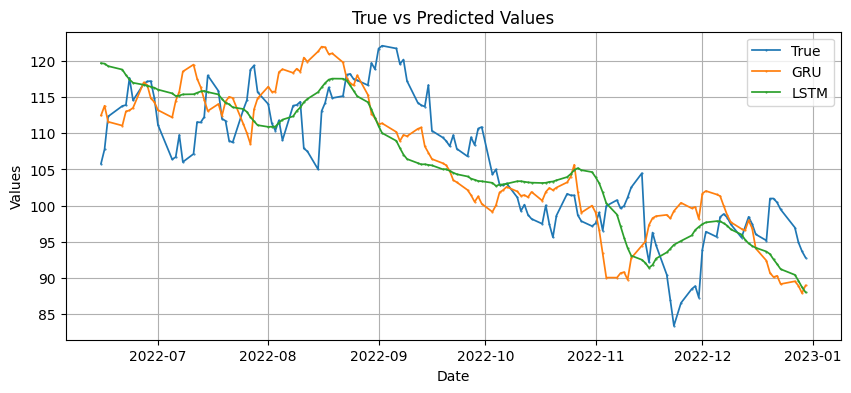

In [639]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

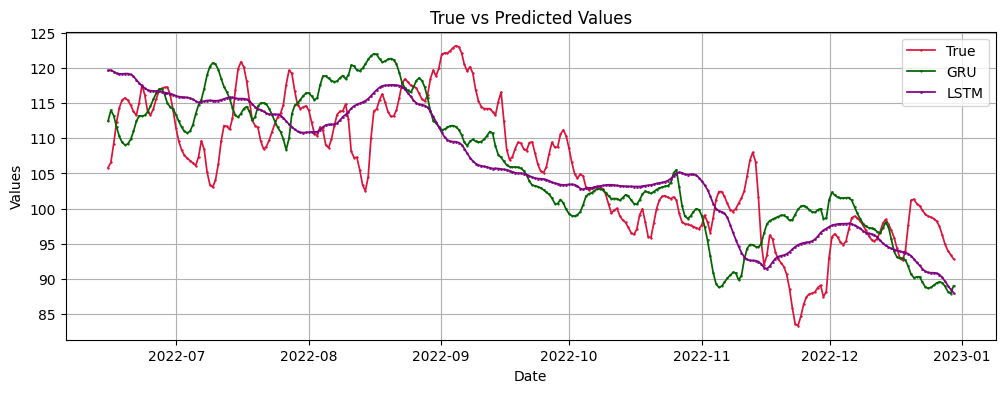

In [640]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## A P P L E

#### Company Data

In [641]:
company = "AAPL"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [642]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [643]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [644]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [645]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [646]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [647]:
data.head(5)

date       open       high        low      close  adj_close     volume
0 2020-01-02  74.059998  75.150002  73.797501  75.087502  73.152641  135480400
1 2020-01-03  74.287498  75.144997  74.125000  74.357498  72.441452  146322800
2 2020-01-06  73.447502  74.989998  73.187500  74.949997  73.018692  118387200
3 2020-01-07  74.959999  75.224998  74.370003  74.597504  72.675278  108872000
4 2020-01-08  74.290001  76.110001  74.290001  75.797501  73.844353  132079200

#### Indicators

In [648]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [649]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [650]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [651]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [652]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [653]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [654]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [655]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [656]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [657]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [658]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [659]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [660]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [661]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [662]:
data.head(5)

date       open       high        low      close  adj_close  \
0 2020-01-02  74.059998  75.150002  73.797501  75.087502  73.152641   
1 2020-01-03  74.287498  75.144997  74.125000  74.357498  72.441452   
2 2020-01-06  73.447502  74.989998  73.187500  74.949997  73.018692   
3 2020-01-07  74.959999  75.224998  74.370003  74.597504  72.675278   
4 2020-01-08  74.290001  76.110001  74.290001  75.797501  73.844353   

      volume  ma7  ma21      26ema  ...  close_60  Log_Returns  Vola10d  \
0  135480400  NaN   NaN  75.087502  ...       NaN          NaN      NaN   
1  146322800  NaN   NaN  74.708461  ...       NaN    -0.009770      NaN   
2  118387200  NaN   NaN  74.795243  ...       NaN     0.007937      NaN   
3  108872000  NaN   NaN  74.739964  ...       NaN    -0.004714      NaN   
4  132079200  NaN   NaN  74.985211  ...       NaN     0.015958      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN        0.080029         NaN         NaN         NaN  NaN  
2      NaN      NaN       -0.190918         NaN         NaN         NaN  NaN  
3      NaN      NaN       -0.080374         NaN         NaN         NaN  NaN  
4      NaN      NaN        0.213160         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [663]:
data = data.ffill().bfill()

#### Preprocessing

In [664]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [665]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [666]:
df_indicators

date       close     volume         ma7        ma21       26ema  \
0   2020-01-02   75.087502  135480400   75.682857   77.979048   75.087502   
1   2020-01-03   74.357498  146322800   75.682857   77.979048   74.708461   
2   2020-01-06   74.949997  118387200   75.682857   77.979048   74.795243   
3   2020-01-07   74.597504  108872000   75.682857   77.979048   74.739964   
4   2020-01-08   75.797501  132079200   75.682857   77.979048   74.985211   
..         ...         ...        ...         ...         ...         ...   
751 2022-12-23  131.860001   63814900  133.602855  141.015714  140.437884   
752 2022-12-27  130.029999   69007800  132.678569  140.154762  139.666930   
753 2022-12-28  126.040001   85438400  131.468570  139.289048  138.657527   
754 2022-12-29  129.610001   75703700  131.074285  138.738572  137.987340   
755 2022-12-30  129.929993   77034200  130.735712  137.876666  137.390500   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0     75.087502  0.000000  2.091398   82.191922  ...   73.871042    -0.009770   
1     74.692083 -0.016378  2.091398   82.191922  ...   73.871042    -0.009770   
2     74.792747 -0.002496  2.091398   82.191922  ...   73.871042     0.007937   
3     74.731116 -0.008847  2.091398   82.191922  ...   73.871042    -0.004714   
4     75.020849  0.035638  2.091398   82.191922  ...   73.871042     0.015958   
..          ...       ...       ...         ...  ...         ...          ...   
751  136.767190 -3.670694  5.792854  152.246708  ...  143.766499    -0.002802   
752  135.730699 -3.936230  6.189422  152.330344  ...  143.630333    -0.013976   
753  134.239822 -4.417705  6.914779  153.024558  ...  143.356833    -0.031166   
754  133.527542 -4.459798  6.902781  152.079562  ...  143.081999     0.027931   
755  132.974073 -4.416427  6.717336  150.789671  ...  142.807499     0.002466   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.201716  0.264188  0.675247        0.080029    3.385454    3.650638   
1    0.201716  0.264188  0.675247        0.080029    3.385454    3.650638   
2    0.201716  0.264188  0.675247       -0.190918    3.385454    3.650638   
3    0.201716  0.264188  0.675247       -0.080374    3.385454    3.650638   
4    0.201716  0.264188  0.675247        0.213160    3.385454    3.650638   
..        ...       ...       ...             ...         ...         ...   
751  0.330701  0.302835  0.404342       -0.180306    4.894155    4.821236   
752  0.303544  0.296411  0.400645        0.081374    4.867207    4.774472   
753  0.302711  0.305957  0.399931        0.238098    4.730543    4.751173   
754  0.369174  0.317210  0.400734       -0.113938    4.721964    4.741183   
755  0.305034  0.317728  0.400753        0.017575    4.626911    4.644319   

     Volu60d_ff       atr  
0      4.454182  1.280178  
1      4.454182  1.280178  
2      4.454182  1.280178  
3      4.454182  1.280178  
4      4.454182  1.280178  
..          ...       ...  
751    4.554681  4.389285  
752    4.554804  4.229285  
753    4.568737  4.357142  
754    4.545900  4.489999  
755    4.537959  4.336426  

[756 rows x 27 columns]

In [667]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [668]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [669]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.555503  0.128394  0.597234  0.675199  0.681125  0.625154   
754 2022-12-29  0.583855  0.103517  0.593927  0.670353  0.674927  0.618977   
755 2022-12-30  0.586396  0.106917  0.591088  0.662766  0.669408  0.614177   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.159004  0.732994    0.718984  ...  0.726119     0.424698  0.183186   
754  0.156037  0.731472    0.710951  ...  0.723432     0.660269  0.238549   
755  0.159095  0.707942    0.699986  ...  0.720749     0.558761  0.185121   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.188311  0.414375        0.241580    0.248188    0.290131    0.303833   
754  0.202351  0.415853        0.129878    0.247531    0.288891    0.299592   
755  0.202998  0.415888        0.171608    0.240247    0.276870    0.298118   

          atr  
753  0.548556  
754  0.572037  
755  0.544895  

[3 rows x 27 columns]

In [670]:
df_time_series = df_normalized.set_index('date')

In [671]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [672]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.670499  0.146396  0.679548  0.770592  0.792820  0.713449   
2022-05-26  0.696389  0.141589  0.673007  0.765230  0.788055  0.712593   
2022-05-27  0.742927  0.142552  0.683573  0.759362  0.787657  0.719688   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.025249  0.983795    0.842766    0.674465  ...  0.896981   
2022-05-26  0.054621  0.916087    0.825253    0.675106  ...  0.893269   
2022-05-27  0.115327  0.883359    0.817463    0.676101  ...  0.890566   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.553473  0.330784  0.372083  0.392189        0.130533   
2022-05-26     0.640353  0.329547  0.376146  0.393437        0.159577   
2022-05-27     0.708173  0.343607  0.391390  0.411095        0.167352   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.186067    0.095105    0.033535  0.833486  
2022-05-26    0.158552    0.092383    0.033206  0.857977  
2022-05-27    0.119172    0.092178    0.032802  0.859366  

[3 rows x 26 columns]

In [673]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [674]:
time_steps = 14

In [675]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [676]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [677]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [678]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 8s 106ms/step - loss: 0.0187 - val_loss: 0.0269
Epoch 2/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0055 - val_loss: 0.0163
Epoch 3/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0032 - val_loss: 0.0090
Epoch 4/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0030 - val_loss: 0.0063
Epoch 5/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0029 - val_loss: 0.0072
Epoch 6/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 7/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0025 - val_loss: 0.0132
Epoch 8/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0029 - val_loss: 0.0214
Epoch 9/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0029 - val_loss: 0.0072
Epoch 10/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0021 - val_loss: 0.0081
Epoch 11

In [679]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 8ms/step


#### L S T M

In [680]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [681]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 8s 109ms/step - loss: 0.0732 - val_loss: 0.0948
Epoch 2/50
15/15 [==============================] - 1s 34ms/step - loss: 0.0131 - val_loss: 0.0214
Epoch 3/50
15/15 [==============================] - 1s 38ms/step - loss: 0.0077 - val_loss: 0.0115
Epoch 4/50
15/15 [==============================] - 1s 39ms/step - loss: 0.0065 - val_loss: 0.0176
Epoch 5/50
15/15 [==============================] - 1s 37ms/step - loss: 0.0056 - val_loss: 0.0154
Epoch 6/50
15/15 [==============================] - 1s 40ms/step - loss: 0.0054 - val_loss: 0.0229
Epoch 7/50
15/15 [==============================] - 1s 38ms/step - loss: 0.0049 - val_loss: 0.0144
Epoch 8/50
15/15 [==============================] - 1s 39ms/step - loss: 0.0046 - val_loss: 0.0102
Epoch 9/50
15/15 [==============================] - 1s 39ms/step - loss: 0.0044 - val_loss: 0.0141
Epoch 10/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0052 - val_loss: 0.0207
Epoch 11

In [682]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### Initial Reports

In [683]:
true_val = X_test[:,0,0]

In [684]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.670498607
Example 2 ---> Value 0.696388532
Example 3 ---> Value 0.742926946

             L S T M            
Example 1 ---> Value 0.630692363
Example 2 ---> Value 0.624475181
Example 3 ---> Value 0.616731346

              G R U             
Example 1 ---> Value 0.621743500
Example 2 ---> Value 0.630938947
Example 3 ---> Value 0.606611907


#### Inverse Scaling

In [685]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [686]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [687]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [688]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 140.520004272
Example 2 ---> Value 143.779998779
Example 3 ---> Value 149.639999390

             L S T M            
Example 1 ---> Value 135.507690430
Example 2 ---> Value 134.724853516
Example 3 ---> Value 133.749755859

              G R U             
Example 1 ---> Value 134.380889893
Example 2 ---> Value 135.538757324
Example 3 ---> Value 132.475555420


In [689]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.670499  0.146396  0.679548  0.770592  0.792820  0.713449   
2022-05-26  0.696389  0.141589  0.673007  0.765230  0.788055  0.712593   
2022-05-27  0.742927  0.142552  0.683573  0.759362  0.787657  0.719688   
2022-05-31  0.736574  0.175109  0.697338  0.755669  0.786740  0.724623   
2022-06-01  0.735541  0.099896  0.710660  0.751791  0.785803  0.728626   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.025249  0.983795    0.842766    0.674465  ...  0.896981   
2022-05-26  0.054621  0.916087    0.825253    0.675106  ...  0.893269   
2022-05-27  0.115327  0.883359    0.817463    0.676101  ...  0.890566   
2022-05-31  0.162437  0.843345    0.808225    0.677609  ...  0.888232   
2022-06-01  0.202126  0.782229    0.795459    0.681276  ...  0.886506   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.553473  0.330784  0.372083  0.392189        0.130533   
2022-05-26     0.640353  0.329547  0.376146  0.393437        0.159577   
2022-05-27     0.708173  0.343607  0.391390  0.411095        0.167352   
2022-05-31     0.527564  0.341066  0.391387  0.408396        0.210464   
2022-06-01     0.545449  0.327075  0.387839  0.403293        0.075991   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.186067    0.095105    0.033535  0.833486  
2022-05-26    0.158552    0.092383    0.033206  0.857977  
2022-05-27    0.119172    0.092178    0.032802  0.859366  
2022-05-31    0.102021    0.092150    0.033963  0.848509  
2022-06-01    0.130333    0.108045    0.043201  0.778066  

[5 rows x 26 columns]

In [690]:
test.reset_index(inplace=True)

In [691]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.670499  0.146396  0.679548  0.770592  0.792820  0.713449   
1 2022-05-26  0.696389  0.141589  0.673007  0.765230  0.788055  0.712593   
2 2022-05-27  0.742927  0.142552  0.683573  0.759362  0.787657  0.719688   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.025249  0.983795    0.842766  ...  0.896981     0.553473  0.330784   
1  0.054621  0.916087    0.825253  ...  0.893269     0.640353  0.329547   
2  0.115327  0.883359    0.817463  ...  0.890566     0.708173  0.343607   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.372083  0.392189        0.130533    0.186067    0.095105    0.033535   
1  0.376146  0.393437        0.159577    0.158552    0.092383    0.033206   
2  0.391390  0.411095        0.167352    0.119172    0.092178    0.032802   

        atr  
0  0.833486  
1  0.857977  
2  0.859366  

[3 rows x 27 columns]

In [692]:
results = pd.DataFrame()

In [693]:
results['date'] = test['date'].tail(len(X_test))

In [694]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [695]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [696]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  144.220001  136.144043  133.533203
143 2022-12-19  141.169998  134.487518  132.780029
144 2022-12-20  148.029999  132.153687  131.660858
145 2022-12-21  148.309998  131.258636  130.624466
146 2022-12-22  147.809998  133.974319  129.672409
147 2022-12-23  146.630005  131.505188  128.726471
148 2022-12-27  142.910004  130.954285  127.947632
149 2022-12-28  140.940002  130.104584  127.208511
150 2022-12-29  142.649994  127.987015  126.501549
151 2022-12-30  142.160004  129.564575  126.101295

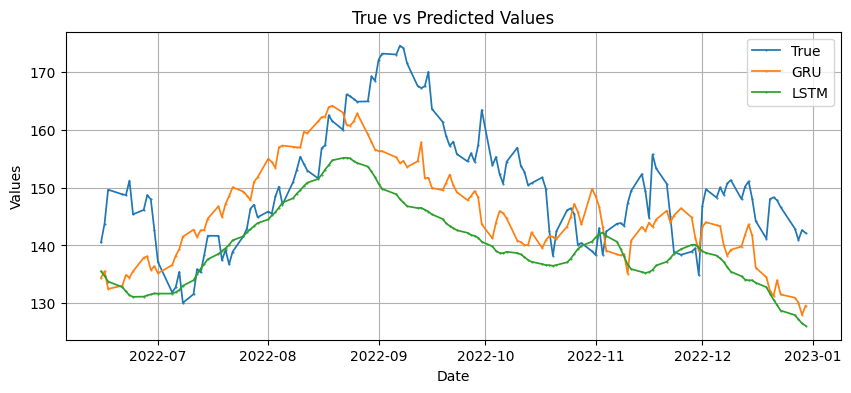

In [697]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

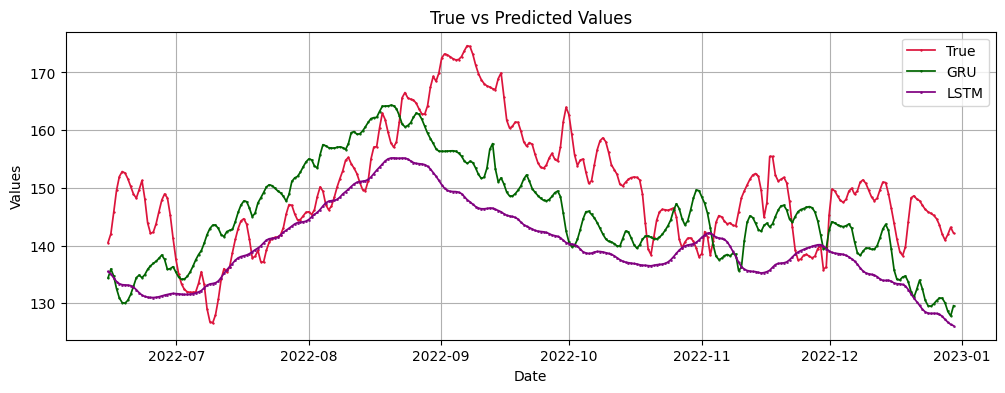

In [698]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## M I C R O S O F T

#### Company Data

In [699]:
company = "MSFT"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [700]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [701]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [702]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [703]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [704]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [705]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  158.779999  160.729996  158.330002  160.619995  154.779495   
1 2020-01-03  158.320007  159.949997  158.059998  158.619995  152.852264   
2 2020-01-06  157.080002  159.100006  156.509995  159.029999  153.247345   
3 2020-01-07  159.320007  159.669998  157.320007  157.580002  151.850098   
4 2020-01-08  158.929993  160.800003  157.949997  160.089996  154.268784   

     volume  
0  22622100  
1  21116200  
2  20813700  
3  21634100  
4  27746500

#### Indicators

In [706]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [707]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [708]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [709]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [710]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [711]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [712]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [713]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [714]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [715]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [716]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [717]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [718]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [719]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [720]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  158.779999  160.729996  158.330002  160.619995  154.779495   
1 2020-01-03  158.320007  159.949997  158.059998  158.619995  152.852264   
2 2020-01-06  157.080002  159.100006  156.509995  159.029999  153.247345   
3 2020-01-07  159.320007  159.669998  157.320007  157.580002  151.850098   
4 2020-01-08  158.929993  160.800003  157.949997  160.089996  154.268784   

     volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0  22622100  NaN   NaN  160.619995  ...       NaN          NaN      NaN   
1  21116200  NaN   NaN  159.581534  ...       NaN    -0.012530      NaN   
2  20813700  NaN   NaN  159.383372  ...       NaN     0.002581      NaN   
3  21634100  NaN   NaN  158.879229  ...       NaN    -0.009160      NaN   
4  27746500  NaN   NaN  159.160011  ...       NaN     0.015803      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN       -0.066568         NaN         NaN         NaN  NaN  
2      NaN      NaN       -0.014325         NaN         NaN         NaN  NaN  
3      NaN      NaN        0.039416         NaN         NaN         NaN  NaN  
4      NaN      NaN        0.282535         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [721]:
data = data.ffill().bfill()

#### Preprocessing

In [722]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [723]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [724]:
df_indicators

date       close    volume         ma7        ma21       26ema  \
0   2020-01-02  160.619995  22622100  159.909997  163.999046  160.619995   
1   2020-01-03  158.619995  21116200  159.909997  163.999046  159.581534   
2   2020-01-06  159.029999  20813700  159.909997  163.999046  159.383372   
3   2020-01-07  157.580002  21634100  159.909997  163.999046  158.879229   
4   2020-01-08  160.089996  27746500  159.909997  163.999046  159.160011   
..         ...         ...       ...         ...         ...         ...   
751 2022-12-23  238.729996  21207000  242.471427  247.185237  244.510345   
752 2022-12-27  236.960007  16688600  240.750000  246.683809  243.951060   
753 2022-12-28  234.529999  17457100  239.298571  246.339523  243.253204   
754 2022-12-29  241.009995  19770700  239.378571  246.371904  243.087040   
755 2022-12-30  239.820007  21938500  239.095714  245.642380  242.845038   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0    160.619995  0.000000  3.737938  171.163375  ...  164.631666    -0.012530   
1    159.536662 -0.044872  3.737938  171.163375  ...  164.631666    -0.012530   
2    159.338911 -0.044461  3.737938  171.163375  ...  164.631666     0.002581   
3    158.783692 -0.095537  3.737938  171.163375  ...  164.631666    -0.009160   
4    159.138610 -0.021400  3.737938  171.163375  ...  164.631666     0.015803   
..          ...       ...       ...         ...  ...         ...          ...   
751  244.242884 -0.267460  6.281050  259.732099  ...  239.994499     0.002265   
752  243.122442 -0.828619  6.583089  260.096177  ...  240.062166    -0.007442   
753  241.800527 -1.452677  7.003466  260.646931  ...  239.958666    -0.010308   
754  241.678907 -1.408133  6.810928  259.555356  ...  239.827499     0.027255   
755  241.392922 -1.452115  6.613498  258.416996  ...  239.671166    -0.004950   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.177225  0.228503  0.709370       -0.066568    2.166507    3.898696   
1    0.177225  0.228503  0.709370       -0.066568    2.166507    3.898696   
2    0.177225  0.228503  0.709370       -0.014325    2.166507    3.898696   
3    0.177225  0.228503  0.709370        0.039416    2.166507    3.898696   
4    0.177225  0.228503  0.709370        0.282535    2.166507    3.898696   
..        ...       ...       ...             ...         ...         ...   
751  0.314041  0.292445  0.414973       -0.259834    8.926558    8.968504   
752  0.261322  0.288301  0.413263       -0.213062    8.813119    8.956799   
753  0.225616  0.282486  0.408082        0.046049    8.626136    8.941059   
754  0.288234  0.294065  0.406147        0.132531    8.581348    8.939045   
755  0.249411  0.294389  0.406229        0.109647    8.582802    8.886867   

     Volu60d_ff       atr  
0      3.842411  2.264290  
1      3.842411  2.264290  
2      3.842411  2.264290  
3      3.842411  2.264290  
4      3.842411  2.264290  
..          ...       ...  
751    7.816158  6.919286  
752    7.825541  6.563571  
753    7.806565  6.677858  
754    7.802647  6.800000  
755    7.735270  6.814285  

[756 rows x 27 columns]

In [725]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [726]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [727]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.477202  0.094023  0.494604  0.519006  0.496283  0.499529   
754 2022-12-29  0.508402  0.120370  0.495006  0.519180  0.495356  0.498889   
755 2022-12-30  0.502672  0.145057  0.493583  0.515263  0.494006  0.497385   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.402154  0.360300    0.511059  ...  0.458109     0.510104  0.118900   
754  0.404383  0.347061    0.505188  ...  0.457315     0.638576  0.165035   
755  0.402182  0.333485    0.499065  ...  0.456367     0.528430  0.136432   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.186698  0.450332        0.298597    0.639568    0.975965    0.995635   
754  0.199831  0.447205        0.335427    0.635815    0.975628    0.994733   
755  0.200199  0.447337        0.325682    0.635937    0.966884    0.979234   

          atr  
753  0.415187  
754  0.426517  
755  0.427842  

[3 rows x 27 columns]

In [728]:
df_time_series = df_normalized.set_index('date')

In [729]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [730]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.611970  0.220324  0.591107  0.638550  0.642020  0.605514   
2022-05-26  0.628244  0.179945  0.590446  0.634121  0.640584  0.608704   
2022-05-27  0.663585  0.201681  0.604214  0.629931  0.642288  0.617340   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.103613  0.707917    0.679644    0.574571  ...  0.728373   
2022-05-26  0.146855  0.629533    0.661000    0.580025  ...  0.724910   
2022-05-27  0.213778  0.616942    0.657879    0.580785  ...  0.722620   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.583351  0.224281  0.341154  0.401568        0.271714   
2022-05-26     0.589114  0.212820  0.338189  0.400054        0.226091   
2022-05-27     0.638491  0.218605  0.340247  0.406208        0.311498   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.109889    0.069629    0.034375  0.669493  
2022-05-26    0.108290    0.053166    0.037273  0.654253  
2022-05-27    0.072609    0.038839    0.033941  0.627948  

[3 rows x 26 columns]

In [731]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [732]:
time_steps = 14

In [733]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [734]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [735]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [736]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 104ms/step - loss: 0.0222 - val_loss: 0.0031
Epoch 2/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0062 - val_loss: 0.0037
Epoch 3/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 4/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 5/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 6/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 8/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 9/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 10/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 11

In [737]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 8ms/step


#### L S T M

In [738]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [739]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 8s 171ms/step - loss: 0.0575 - val_loss: 0.0257
Epoch 2/50
15/15 [==============================] - 1s 38ms/step - loss: 0.0123 - val_loss: 0.0061
Epoch 3/50
15/15 [==============================] - 1s 39ms/step - loss: 0.0091 - val_loss: 0.0073
Epoch 4/50
15/15 [==============================] - 1s 38ms/step - loss: 0.0059 - val_loss: 0.0083
Epoch 5/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0070 - val_loss: 0.0082
Epoch 6/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 7/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0052 - val_loss: 0.0063
Epoch 8/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 9/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0048 - val_loss: 0.0069
Epoch 10/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 11

In [740]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 1s 6ms/step


#### Initial Reports

In [741]:
true_val = X_test[:,0,0]

In [742]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.611969756
Example 2 ---> Value 0.628244036
Example 3 ---> Value 0.663585154

             L S T M            
Example 1 ---> Value 0.604762912
Example 2 ---> Value 0.595235407
Example 3 ---> Value 0.586092710

              G R U             
Example 1 ---> Value 0.588288009
Example 2 ---> Value 0.599639773
Example 3 ---> Value 0.586816669


#### Inverse Scaling

In [743]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [744]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [745]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [746]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 262.519989014
Example 2 ---> Value 265.899993896
Example 3 ---> Value 273.239990234

             L S T M            
Example 1 ---> Value 261.023193359
Example 2 ---> Value 259.044433594
Example 3 ---> Value 257.145568848

              G R U             
Example 1 ---> Value 257.601531982
Example 2 ---> Value 259.959167480
Example 3 ---> Value 257.295959473


In [747]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.611970  0.220324  0.591107  0.638550  0.642020  0.605514   
2022-05-26  0.628244  0.179945  0.590446  0.634121  0.640584  0.608704   
2022-05-27  0.663585  0.201681  0.604214  0.629931  0.642288  0.617340   
2022-05-31  0.656989  0.326003  0.617672  0.628486  0.643300  0.623540   
2022-06-01  0.659637  0.183249  0.631943  0.625405  0.644464  0.629231   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.103613  0.707917    0.679644    0.574571  ...  0.728373   
2022-05-26  0.146855  0.629533    0.661000    0.580025  ...  0.724910   
2022-05-27  0.213778  0.616942    0.657879    0.580785  ...  0.722620   
2022-05-31  0.263716  0.564019    0.646211    0.585321  ...  0.720803   
2022-06-01  0.307444  0.523776    0.637398    0.588826  ...  0.720148   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.583351  0.224281  0.341154  0.401568        0.271714   
2022-05-26     0.589114  0.212820  0.338189  0.400054        0.226091   
2022-05-27     0.638491  0.218605  0.340247  0.406208        0.311498   
2022-05-31     0.528168  0.220818  0.340311  0.402887        0.451748   
2022-06-01     0.552271  0.212368  0.336525  0.389808        0.137861   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.109889    0.069629    0.034375  0.669493  
2022-05-26    0.108290    0.053166    0.037273  0.654253  
2022-05-27    0.072609    0.038839    0.033941  0.627948  
2022-05-31    0.151219    0.049940    0.049882  0.605883  
2022-06-01    0.191405    0.077888    0.053691  0.576662  

[5 rows x 26 columns]

In [748]:
test.reset_index(inplace=True)

In [749]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.611970  0.220324  0.591107  0.638550  0.642020  0.605514   
1 2022-05-26  0.628244  0.179945  0.590446  0.634121  0.640584  0.608704   
2 2022-05-27  0.663585  0.201681  0.604214  0.629931  0.642288  0.617340   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.103613  0.707917    0.679644  ...  0.728373     0.583351  0.224281   
1  0.146855  0.629533    0.661000  ...  0.724910     0.589114  0.212820   
2  0.213778  0.616942    0.657879  ...  0.722620     0.638491  0.218605   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.341154  0.401568        0.271714    0.109889    0.069629    0.034375   
1  0.338189  0.400054        0.226091    0.108290    0.053166    0.037273   
2  0.340247  0.406208        0.311498    0.072609    0.038839    0.033941   

        atr  
0  0.669493  
1  0.654253  
2  0.627948  

[3 rows x 27 columns]

In [750]:
results = pd.DataFrame()

In [751]:
results['date'] = test['date'].tail(len(X_test))

In [752]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [753]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [754]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  241.759995  251.110382  231.408875
143 2022-12-19  240.330002  244.079590  231.769623
144 2022-12-20  255.139999  244.543854  232.151321
145 2022-12-21  254.690002  244.408173  231.824066
146 2022-12-22  255.020004  243.874847  231.655197
147 2022-12-23  250.199997  239.387115  230.950272
148 2022-12-27  245.119995  238.759918  230.031555
149 2022-12-28  244.369995  238.508087  229.251587
150 2022-12-29  247.399994  237.288208  228.420685
151 2022-12-30  245.419998  239.251434  227.951508

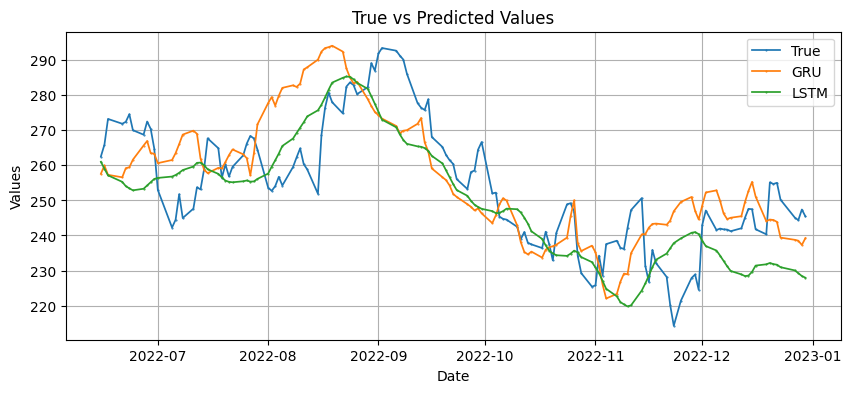

In [755]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

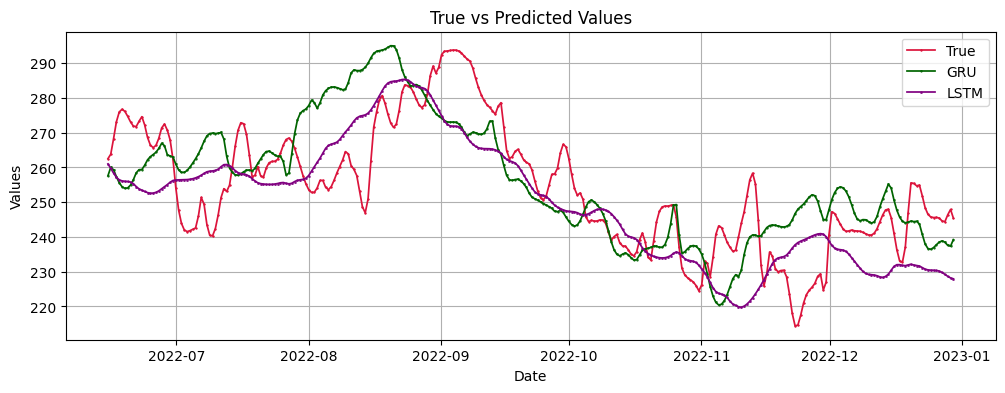

In [756]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## N V I D I A

#### Company Data

In [757]:
company = "NVDA"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [758]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [759]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [760]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [761]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [762]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [763]:
data.head(5)

date       open       high        low      close  adj_close    volume
0 2020-01-02  59.687500  59.977501  59.180000  59.977501  59.749298  23753600
1 2020-01-03  58.775002  59.457500  58.525002  59.017502  58.792950  20538400
2 2020-01-06  58.080002  59.317501  57.817501  59.264999  59.039513  26263600
3 2020-01-07  59.549999  60.442501  59.097500  59.982498  59.754284  31485600
4 2020-01-08  59.939999  60.509998  59.537498  60.095001  59.866348  27710800

#### Indicators

In [764]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [765]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [766]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [767]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [768]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [769]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [770]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [771]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [772]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [773]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [774]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [775]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [776]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [777]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [778]:
data.head(5)

date       open       high        low      close  adj_close    volume  \
0 2020-01-02  59.687500  59.977501  59.180000  59.977501  59.749298  23753600   
1 2020-01-03  58.775002  59.457500  58.525002  59.017502  58.792950  20538400   
2 2020-01-06  58.080002  59.317501  57.817501  59.264999  59.039513  26263600   
3 2020-01-07  59.549999  60.442501  59.097500  59.982498  59.754284  31485600   
4 2020-01-08  59.939999  60.509998  59.537498  60.095001  59.866348  27710800   

   ma7  ma21      26ema  ...  close_60  Log_Returns  Vola10d  Vola30d  \
0  NaN   NaN  59.977501  ...       NaN          NaN      NaN      NaN   
1  NaN   NaN  59.479040  ...       NaN    -0.016135      NaN      NaN   
2  NaN   NaN  59.402137  ...       NaN     0.004185      NaN      NaN   
3  NaN   NaN  59.564381  ...       NaN     0.012034      NaN      NaN   
4  NaN   NaN  59.687434  ...       NaN     0.001874      NaN      NaN   

   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN       -0.135356         NaN         NaN         NaN  NaN  
2      NaN        0.278756         NaN         NaN         NaN  NaN  
3      NaN        0.198830         NaN         NaN         NaN  NaN  
4      NaN       -0.119890         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [779]:
data = data.ffill().bfill()

#### Preprocessing

In [780]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [781]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [782]:
df_indicators

date       close    volume         ma7        ma21       26ema  \
0   2020-01-02   59.977501  23753600   60.024643   61.203214   59.977501   
1   2020-01-03   59.017502  20538400   60.024643   61.203214   59.479040   
2   2020-01-06   59.264999  26263600   60.024643   61.203214   59.402137   
3   2020-01-07   59.982498  31485600   60.024643   61.203214   59.564381   
4   2020-01-08   60.095001  27710800   60.024643   61.203214   59.687434   
..         ...         ...       ...         ...         ...         ...   
751 2022-12-23  152.059998  34932600  161.297143  165.593334  161.287562   
752 2022-12-27  141.210007  46490200  157.252858  164.570001  159.800336   
753 2022-12-28  140.360001  35106600  153.631428  163.717143  158.360311   
754 2022-12-29  146.029999  35492300  151.272858  163.223810  157.446954   
755 2022-12-30  146.139999  31049000  149.171428  162.124286  156.609402   

          12ema      MACD       20sd  upper_band  ...    close_60  \
0     59.977501  0.000000   1.238677   63.785353  ...   62.990667   
1     59.457501 -0.021538   1.238677   63.785353  ...   62.990667   
2     59.382368 -0.019769   1.238677   63.785353  ...   62.990667   
3     59.571806  0.007425   1.238677   63.785353  ...   62.990667   
4     59.713956  0.026522   1.238677   63.785353  ...   62.990667   
..          ...       ...        ...         ...  ...         ...   
751  162.668882  1.381320   7.716085  181.170171  ...  146.446167   
752  159.367517 -0.432819   9.354202  183.593405  ...  146.776500   
753  156.443283 -1.917028  10.709031  185.501562  ...  147.030500   
754  154.841240 -2.605715  11.359007  185.641516  ...  147.269834   
755  153.502587 -3.106815  11.766180  185.195360  ...  147.504000   

     Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  \
0      -0.016135  0.235344  0.354051  0.877356       -0.135356    2.878640   
1      -0.016135  0.235344  0.354051  0.877356       -0.135356    2.878640   
2       0.004185  0.235344  0.354051  0.877356        0.278756    2.878640   
3       0.012034  0.235344  0.354051  0.877356        0.198830    2.878640   
4       0.001874  0.235344  0.354051  0.877356       -0.119890    2.878640   
..           ...       ...       ...       ...             ...         ...   
751    -0.008709  0.526923  0.529152  0.603870       -0.381773    5.455436   
752    -0.074027  0.554871  0.557339  0.624220        0.330854    5.668242   
753    -0.006038  0.485650  0.557282  0.621757       -0.244860    5.404333   
754     0.039602  0.585433  0.566727  0.618334        0.010987    5.252644   
755     0.000753  0.578252  0.552652  0.618330       -0.125191    5.293321   

     Volu30d_ff  Volu60d_ff       atr  
0      6.772592    5.564950  1.214464  
1      6.772592    5.564950  1.214464  
2      6.772592    5.564950  1.214464  
3      6.772592    5.564950  1.214464  
4      6.772592    5.564950  1.214464  
..          ...         ...       ...  
751    5.398788    4.780170  7.935714  
752    5.461589    4.818826  8.192142  
753    5.482245    4.851498  8.091427  
754    5.482827    4.851207  7.682142  
755    5.483027    4.850255  7.530713  

[756 rows x 27 columns]

In [783]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [784]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [785]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.320593  0.185373  0.370714  0.410433  0.407919  0.385463   
754 2022-12-29  0.340511  0.188197  0.362011  0.408490  0.404154  0.379293   
755 2022-12-30  0.340898  0.155664  0.354256  0.404159  0.400701  0.374137   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.393254  0.305346    0.434015  ...  0.367344     0.546319  0.209973   
754  0.376352  0.326012    0.434513  ...  0.368391     0.672283  0.269166   
755  0.364054  0.338958    0.432923  ...  0.369414     0.565061  0.264906   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.346063  0.477961        0.082000    0.229281    0.297079    0.305371   
754  0.355297  0.472571        0.139942    0.221499    0.297137    0.305330   
755  0.341536  0.472564        0.109102    0.223586    0.297156    0.305196   

          atr  
753  0.366300  
754  0.344500  
755  0.336434  

[3 rows x 27 columns]

In [786]:
df_time_series = df_normalized.set_index('date')

In [787]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [788]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.423839  0.500255  0.430904  0.468973  0.518128  0.447244   
2022-05-26  0.454612  0.657996  0.429186  0.467915  0.516117  0.450814   
2022-05-27  0.488337  0.468952  0.439060  0.466093  0.517186  0.459524   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.130773  0.369897    0.499135    0.434324  ...  0.675804   
2022-05-26  0.165498  0.342735    0.489606    0.437367  ...  0.671164   
2022-05-27  0.214631  0.346209    0.490855    0.437012  ...  0.667592   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.699807  0.393603  0.552743  0.635137        0.211560   
2022-05-26     0.701860  0.402218  0.562551  0.643321        0.199918   
2022-05-27     0.707558  0.349828  0.573063  0.656917        0.078779   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.089102    0.016563    0.114353  0.599296  
2022-05-26    0.103381    0.016836    0.118655  0.620145  
2022-05-27    0.121814    0.029143    0.125193  0.589024  

[3 rows x 26 columns]

In [789]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [790]:
time_steps = 14

In [791]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [792]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [793]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [794]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 107ms/step - loss: 0.0244 - val_loss: 0.0069
Epoch 2/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 3/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0035 - val_loss: 0.0110
Epoch 4/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0023 - val_loss: 0.0115
Epoch 5/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0020 - val_loss: 0.0116
Epoch 6/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0021 - val_loss: 0.0146
Epoch 7/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0016 - val_loss: 0.0097
Epoch 8/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0016 - val_loss: 0.0115
Epoch 9/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0015 - val_loss: 0.0085
Epoch 10/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0015 - val_loss: 0.0101
Epoch 11

In [795]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 9ms/step


#### L S T M

In [796]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [797]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 8s 108ms/step - loss: 0.0373 - val_loss: 0.0197
Epoch 2/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0102 - val_loss: 0.0115
Epoch 3/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0060 - val_loss: 0.0153
Epoch 4/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0040 - val_loss: 0.0083
Epoch 5/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0051 - val_loss: 0.0119
Epoch 6/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0037 - val_loss: 0.0134
Epoch 7/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0032 - val_loss: 0.0168
Epoch 8/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0029 - val_loss: 0.0167
Epoch 9/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0031 - val_loss: 0.0222
Epoch 10/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0028 - val_loss: 0.0182
Epoch 11

In [798]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### Initial Reports

In [799]:
true_val = X_test[:,0,0]

In [800]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.423838954
Example 2 ---> Value 0.454612488
Example 3 ---> Value 0.488336952

             L S T M            
Example 1 ---> Value 0.551052570
Example 2 ---> Value 0.541300178
Example 3 ---> Value 0.530978620

              G R U             
Example 1 ---> Value 0.432827830
Example 2 ---> Value 0.436299682
Example 3 ---> Value 0.419607610


#### Inverse Scaling

In [801]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [802]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [803]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [804]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 169.750000000
Example 2 ---> Value 178.509994507
Example 3 ---> Value 188.110000610

             L S T M            
Example 1 ---> Value 205.962615967
Example 2 ---> Value 203.186523438
Example 3 ---> Value 200.248382568

              G R U             
Example 1 ---> Value 172.308776855
Example 2 ---> Value 173.297058105
Example 3 ---> Value 168.545501709


In [805]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.423839  0.500255  0.430904  0.468973  0.518128  0.447244   
2022-05-26  0.454612  0.657996  0.429186  0.467915  0.516117  0.450814   
2022-05-27  0.488337  0.468952  0.439060  0.466093  0.517186  0.459524   
2022-05-31  0.483454  0.414567  0.447220  0.466328  0.517752  0.466069   
2022-06-01  0.471088  0.327010  0.455791  0.464052  0.517200  0.469523   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.130773  0.369897    0.499135    0.434324  ...  0.675804   
2022-05-26  0.165498  0.342735    0.489606    0.437367  ...  0.671164   
2022-05-27  0.214631  0.346209    0.490855    0.437012  ...  0.667592   
2022-05-31  0.252976  0.329286    0.485528    0.439608  ...  0.664486   
2022-06-01  0.278262  0.304292    0.477642    0.443421  ...  0.662277   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.699807  0.393603  0.552743  0.635137        0.211560   
2022-05-26     0.701860  0.402218  0.562551  0.643321        0.199918   
2022-05-27     0.707558  0.349828  0.573063  0.656917        0.078779   
2022-05-31     0.542513  0.340137  0.568566  0.652938        0.114672   
2022-06-01     0.510455  0.319795  0.566228  0.632357        0.096673   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.089102    0.016563    0.114353  0.599296  
2022-05-26    0.103381    0.016836    0.118655  0.620145  
2022-05-27    0.121814    0.029143    0.125193  0.589024  
2022-05-31    0.111099    0.029977    0.124778  0.573881  
2022-06-01    0.118566    0.035762    0.128371  0.564217  

[5 rows x 26 columns]

In [806]:
test.reset_index(inplace=True)

In [807]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.423839  0.500255  0.430904  0.468973  0.518128  0.447244   
1 2022-05-26  0.454612  0.657996  0.429186  0.467915  0.516117  0.450814   
2 2022-05-27  0.488337  0.468952  0.439060  0.466093  0.517186  0.459524   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.130773  0.369897    0.499135  ...  0.675804     0.699807  0.393603   
1  0.165498  0.342735    0.489606  ...  0.671164     0.701860  0.402218   
2  0.214631  0.346209    0.490855  ...  0.667592     0.707558  0.349828   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.552743  0.635137        0.211560    0.089102    0.016563    0.114353   
1  0.562551  0.643321        0.199918    0.103381    0.016836    0.118655   
2  0.573063  0.656917        0.078779    0.121814    0.029143    0.125193   

        atr  
0  0.599296  
1  0.620145  
2  0.589024  

[3 rows x 27 columns]

In [808]:
results = pd.DataFrame()

In [809]:
results['date'] = test['date'].tail(len(X_test))

In [810]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [811]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [812]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  158.270004  161.035492  167.501389
143 2022-12-19  156.389999  159.451447  167.417480
144 2022-12-20  169.229996  158.168152  167.030731
145 2022-12-21  171.350006  157.476318  166.714142
146 2022-12-22  168.759995  164.498260  168.402649
147 2022-12-23  166.100006  158.315765  169.441376
148 2022-12-27  159.869995  155.097260  169.397400
149 2022-12-28  161.199997  150.738190  168.234924
150 2022-12-29  171.690002  149.185806  166.368622
151 2022-12-30  170.009995  149.220093  164.503922

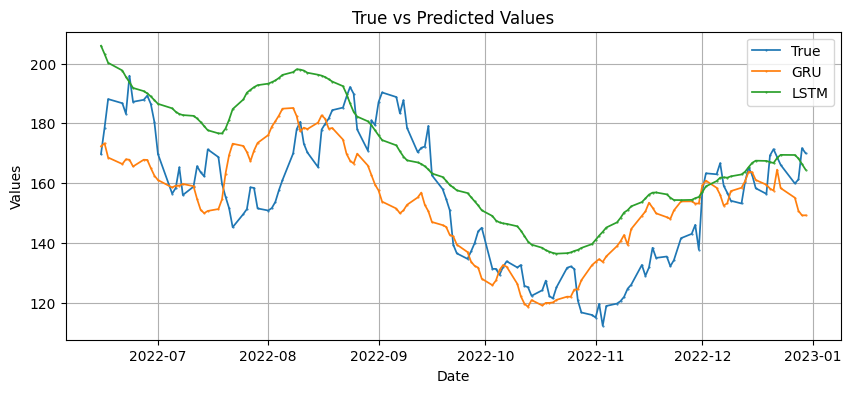

In [813]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

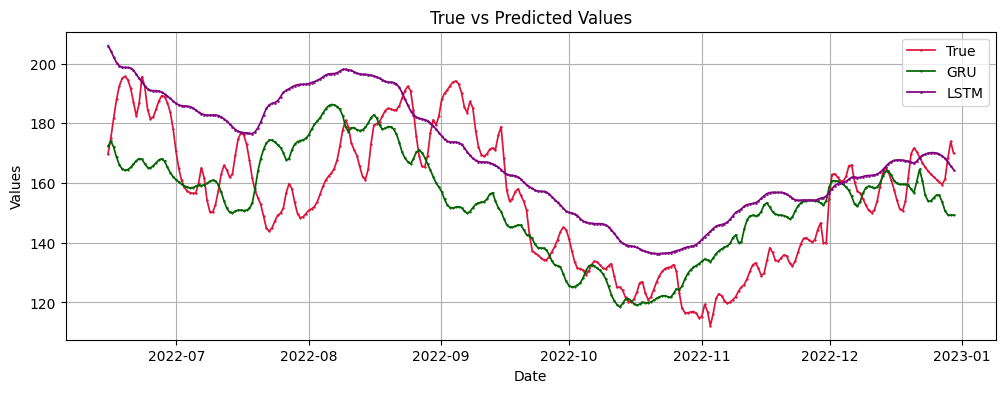

In [814]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## M E T A

#### Company Data

In [815]:
company = "META"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [816]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [817]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [818]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [819]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [820]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [821]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  206.750000  209.789993  206.270004  209.779999  209.779999   
1 2020-01-03  207.210007  210.399994  206.949997  208.669998  208.669998   
2 2020-01-06  206.699997  212.779999  206.520004  212.600006  212.600006   
3 2020-01-07  212.820007  214.580002  211.750000  213.059998  213.059998   
4 2020-01-08  213.000000  216.240005  212.610001  215.220001  215.220001   

     volume  
0  12077100  
1  11188400  
2  17058900  
3  14912400  
4  13475000

#### Indicators

In [822]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [823]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [824]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [825]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [826]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [827]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [828]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [829]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [830]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [831]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [832]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [833]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [834]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [835]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [836]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  206.750000  209.789993  206.270004  209.779999  209.779999   
1 2020-01-03  207.210007  210.399994  206.949997  208.669998  208.669998   
2 2020-01-06  206.699997  212.779999  206.520004  212.600006  212.600006   
3 2020-01-07  212.820007  214.580002  211.750000  213.059998  213.059998   
4 2020-01-08  213.000000  216.240005  212.610001  215.220001  215.220001   

     volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0  12077100  NaN   NaN  209.779999  ...       NaN          NaN      NaN   
1  11188400  NaN   NaN  209.203652  ...       NaN    -0.005305      NaN   
2  17058900  NaN   NaN  210.423929  ...       NaN     0.018658      NaN   
3  14912400  NaN   NaN  211.160859  ...       NaN     0.002161      NaN   
4  13475000  NaN   NaN  212.102191  ...       NaN     0.010087      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN       -0.073586         NaN         NaN         NaN  NaN  
2      NaN      NaN        0.524695         NaN         NaN         NaN  NaN  
3      NaN      NaN       -0.125829         NaN         NaN         NaN  NaN  
4      NaN      NaN       -0.096390         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [837]:
data = data.ffill().bfill()

#### Preprocessing

In [838]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [839]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [840]:
df_indicators

date       close    volume         ma7        ma21       26ema  \
0   2020-01-02  209.779999  12077100  213.670000  216.643333  209.779999   
1   2020-01-03  208.669998  11188400  213.670000  216.643333  209.203652   
2   2020-01-06  212.600006  17058900  213.670000  216.643333  210.423929   
3   2020-01-07  213.059998  14912400  213.670000  216.643333  211.160859   
4   2020-01-08  215.220001  13475000  213.670000  216.643333  212.102191   
..         ...         ...       ...         ...         ...         ...   
751 2022-12-23  118.040001  17796600  117.438572  116.757620  116.487596   
752 2022-12-27  116.879997  21392300  117.542858  117.018095  116.516662   
753 2022-12-28  115.620003  19612500  116.998572  117.343810  116.450243   
754 2022-12-29  120.260002  22366200  117.824286  117.858096  116.732447   
755 2022-12-30  120.339996  19583800  118.288572  117.964762  116.999673   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0    209.779999  0.000000  4.593437  226.566874  ...  196.763500    -0.005305   
1    209.178748 -0.024904  4.593437  226.566874  ...  196.763500    -0.005305   
2    210.514066  0.090137  4.593437  226.566874  ...  196.763500     0.018658   
3    211.317717  0.156858  4.593437  226.566874  ...  196.763500     0.002161   
4    212.377954  0.275763  4.593437  226.566874  ...  196.763500     0.010087   
..          ...       ...       ...         ...  ...         ...          ...   
751  117.355223  0.867627  3.898100  124.821200  ...  117.673000     0.007824   
752  117.282111  0.765449  3.383154  124.196309  ...  117.359667    -0.009876   
753  117.026402  0.576159  2.859213  123.456426  ...  116.976500    -0.010839   
754  117.523879  0.791432  2.913878  123.673756  ...  116.642833     0.039347   
755  117.957128  0.957455  2.909274  123.659549  ...  116.332167     0.000665   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.162948  0.293548  0.618925       -0.073586    3.409921    6.774413   
1    0.162948  0.293548  0.618925       -0.073586    3.409921    6.774413   
2    0.162948  0.293548  0.618925        0.524695    3.409921    6.774413   
3    0.162948  0.293548  0.618925       -0.125829    3.409921    6.774413   
4    0.162948  0.293548  0.618925       -0.096390    3.409921    6.774413   
..        ...       ...       ...             ...         ...         ...   
751  0.490682  0.457098  0.780698       -0.246485    7.541449    6.186314   
752  0.490379  0.457587  0.780825        0.202044    7.555125    6.156070   
753  0.424850  0.457953  0.779412       -0.083198    6.368020    6.151465   
754  0.472937  0.466577  0.783668        0.140405    6.343352    6.155112   
755  0.402295  0.455101  0.783568       -0.124402    6.371806    6.070643   

     Volu60d_ff       atr  
0      5.860345  3.165000  
1      5.860345  3.165000  
2      5.860345  3.165000  
3      5.860345  3.165000  
4      5.860345  3.165000  
..          ...       ...  
751    7.358328  5.165714  
752    7.349464  4.727142  
753    7.340188  4.701427  
754    7.332341  4.844285  
755    7.323083  4.773570  

[756 rows x 27 columns]

In [841]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [842]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [843]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.091076  0.057224  0.083534  0.048963  0.014716  0.053285   
754 2022-12-29  0.106898  0.069429  0.086421  0.050879  0.015808  0.055105   
755 2022-12-30  0.107171  0.057096  0.088045  0.051277  0.016843  0.056691   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.694122  0.000000    0.003495  ...  0.002628     0.630908  0.207108   
754  0.699166  0.001340    0.004293  ...  0.001267     0.738038  0.238367   
755  0.703057  0.001227    0.004241  ...  0.000000     0.655464  0.192447   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.334083  0.882671        0.137346    0.296551    0.295081    0.527912   
754  0.343923  0.889517        0.198295    0.294940    0.295468    0.526567   
755  0.330829  0.889356        0.126115    0.296799    0.286502    0.524981   

          atr  
753  0.110257  
754  0.119924  
755  0.115139  

[3 rows x 27 columns]

In [844]:
df_time_series = df_normalized.set_index('date')

In [845]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [846]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.323661  0.094534  0.344346  0.348665  0.330191  0.330590   
2022-05-26  0.350257  0.072489  0.338856  0.351624  0.328382  0.329931   
2022-05-27  0.362192  0.070300  0.340299  0.349744  0.327711  0.331344   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.560242  0.177883    0.354548    0.363964  ...  0.361673   
2022-05-26  0.566971  0.177676    0.351900    0.361548  ...  0.360553   
2022-05-27  0.580080  0.177866    0.350977    0.360556  ...  0.360020   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.683863  0.297301  0.682061  0.632575        0.039023   
2022-05-26     0.742751  0.322628  0.695258  0.639605        0.111658   
2022-05-27     0.692682  0.305060  0.695723  0.638455        0.154186   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.306216    0.336830    0.206076  0.444170  
2022-05-26    0.307009    0.340230    0.209275  0.454853  
2022-05-27    0.285821    0.339902    0.208630  0.441995  

[3 rows x 26 columns]

In [847]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [848]:
time_steps = 14

In [849]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [850]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [851]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [852]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 105ms/step - loss: 0.2192 - val_loss: 0.0117
Epoch 2/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0267 - val_loss: 0.0193
Epoch 3/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0122 - val_loss: 0.0052
Epoch 4/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0099 - val_loss: 0.0088
Epoch 5/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 6/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 7/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 8/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 9/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 10/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 11

In [853]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### L S T M

In [854]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [855]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 8s 123ms/step - loss: 0.0557 - val_loss: 0.0127
Epoch 2/50
15/15 [==============================] - 1s 39ms/step - loss: 0.0133 - val_loss: 0.0162
Epoch 3/50
15/15 [==============================] - 1s 39ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 4/50
15/15 [==============================] - 1s 38ms/step - loss: 0.0080 - val_loss: 0.0101
Epoch 5/50
15/15 [==============================] - 1s 37ms/step - loss: 0.0072 - val_loss: 0.0098
Epoch 6/50
15/15 [==============================] - 1s 38ms/step - loss: 0.0069 - val_loss: 0.0114
Epoch 7/50
15/15 [==============================] - 1s 37ms/step - loss: 0.0087 - val_loss: 0.0111
Epoch 8/50
15/15 [==============================] - 1s 36ms/step - loss: 0.0069 - val_loss: 0.0106
Epoch 9/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0068 - val_loss: 0.0102
Epoch 10/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0068 - val_loss: 0.0095
Epoch 11

In [856]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 1s 6ms/step


#### Initial Reports

In [857]:
true_val = X_test[:,0,0]

In [858]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.323660796
Example 2 ---> Value 0.350257459
Example 3 ---> Value 0.362191855

             L S T M            
Example 1 ---> Value 0.334535629
Example 2 ---> Value 0.328195065
Example 3 ---> Value 0.320105374

              G R U             
Example 1 ---> Value 0.296941698
Example 2 ---> Value 0.291678131
Example 3 ---> Value 0.282360256


#### Inverse Scaling

In [859]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [860]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [861]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [862]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 183.830001831
Example 2 ---> Value 191.630004883
Example 3 ---> Value 195.130004883

             L S T M            
Example 1 ---> Value 187.019256592
Example 2 ---> Value 185.159759521
Example 3 ---> Value 182.787292480

              G R U             
Example 1 ---> Value 175.994094849
Example 2 ---> Value 174.450439453
Example 3 ---> Value 171.717803955


In [863]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.323661  0.094534  0.344346  0.348665  0.330191  0.330590   
2022-05-26  0.350257  0.072489  0.338856  0.351624  0.328382  0.329931   
2022-05-27  0.362192  0.070300  0.340299  0.349744  0.327711  0.331344   
2022-05-31  0.357111  0.086116  0.341474  0.348532  0.326662  0.331701   
2022-06-01  0.340062  0.132622  0.339025  0.344541  0.324257  0.329187   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.560242  0.177883    0.354548    0.363964  ...  0.361673   
2022-05-26  0.566971  0.177676    0.351900    0.361548  ...  0.360553   
2022-05-27  0.580080  0.177866    0.350977    0.360556  ...  0.360020   
2022-05-31  0.588711  0.166743    0.344439    0.360673  ...  0.359583   
2022-06-01  0.587175  0.154407    0.336455    0.360102  ...  0.359663   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.683863  0.297301  0.682061  0.632575        0.039023   
2022-05-26     0.742751  0.322628  0.695258  0.639605        0.111658   
2022-05-27     0.692682  0.305060  0.695723  0.638455        0.154186   
2022-05-31     0.637682  0.304011  0.695693  0.637679        0.203133   
2022-06-01     0.598201  0.305826  0.691351  0.618194        0.269471   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.306216    0.336830    0.206076  0.444170  
2022-05-26    0.307009    0.340230    0.209275  0.454853  
2022-05-27    0.285821    0.339902    0.208630  0.441995  
2022-05-31    0.287132    0.338331    0.208290  0.426624  
2022-06-01    0.298930    0.344322    0.215147  0.436920  

[5 rows x 26 columns]

In [864]:
test.reset_index(inplace=True)

In [865]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.323661  0.094534  0.344346  0.348665  0.330191  0.330590   
1 2022-05-26  0.350257  0.072489  0.338856  0.351624  0.328382  0.329931   
2 2022-05-27  0.362192  0.070300  0.340299  0.349744  0.327711  0.331344   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.560242  0.177883    0.354548  ...  0.361673     0.683863  0.297301   
1  0.566971  0.177676    0.351900  ...  0.360553     0.742751  0.322628   
2  0.580080  0.177866    0.350977  ...  0.360020     0.692682  0.305060   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.682061  0.632575        0.039023    0.306216    0.336830    0.206076   
1  0.695258  0.639605        0.111658    0.307009    0.340230    0.209275   
2  0.695723  0.638455        0.154186    0.285821    0.339902    0.208630   

        atr  
0  0.444170  
1  0.454853  
2  0.441995  

[3 rows x 27 columns]

In [866]:
results = pd.DataFrame()

In [867]:
results['date'] = test['date'].tail(len(X_test))

In [868]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [869]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [870]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  108.779999  120.727669  156.672684
143 2022-12-19  109.459999  119.617691  157.231445
144 2022-12-20  118.099998  118.429344  157.424042
145 2022-12-21  120.440002  117.169960  157.230804
146 2022-12-22  123.489998  117.135818  156.962646
147 2022-12-23  122.430000  115.509300  156.339340
148 2022-12-27  114.120003  114.869843  155.553528
149 2022-12-28  113.930000  114.866745  155.116898
150 2022-12-29  115.330002  114.902603  154.758514
151 2022-12-30  115.900002  115.678009  154.396484

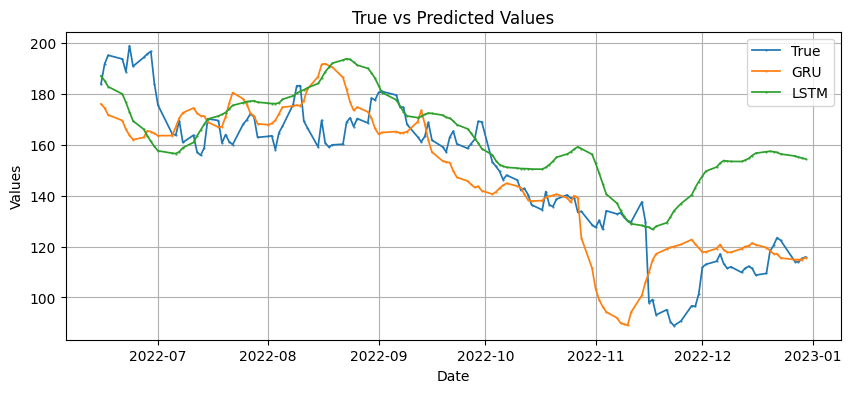

In [871]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

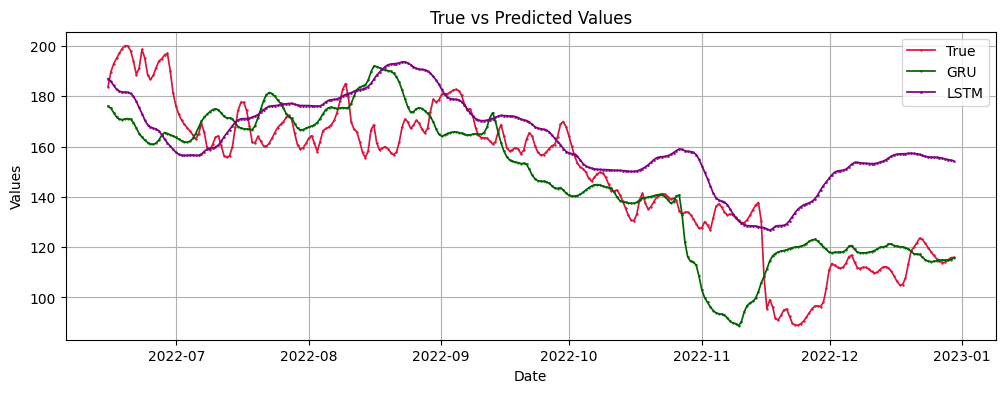

In [872]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## Alphabet - Class C

#### Company Data

In [873]:
company = "GOOG"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [874]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [875]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [876]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [877]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [878]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [879]:
data.head(5)

date       open       high        low      close  adj_close    volume
0 2020-01-02  67.077499  68.406998  67.077499  68.368500  68.368500  28132000
1 2020-01-03  67.392998  68.625000  67.277199  68.032997  68.032997  23728000
2 2020-01-06  67.500000  69.824997  67.500000  69.710503  69.710503  34646000
3 2020-01-07  69.897003  70.149498  69.518997  69.667000  69.667000  30054000
4 2020-01-08  69.603996  70.579002  69.542000  70.216003  70.216003  30560000

#### Indicators

In [880]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [881]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [882]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [883]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [884]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [885]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [886]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [887]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [888]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [889]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [890]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [891]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [892]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [893]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [894]:
data.head(5)

date       open       high        low      close  adj_close    volume  \
0 2020-01-02  67.077499  68.406998  67.077499  68.368500  68.368500  28132000   
1 2020-01-03  67.392998  68.625000  67.277199  68.032997  68.032997  23728000   
2 2020-01-06  67.500000  69.824997  67.500000  69.710503  69.710503  34646000   
3 2020-01-07  69.897003  70.149498  69.518997  69.667000  69.667000  30054000   
4 2020-01-08  69.603996  70.579002  69.542000  70.216003  70.216003  30560000   

   ma7  ma21      26ema  ...  close_60  Log_Returns  Vola10d  Vola30d  \
0  NaN   NaN  68.368500  ...       NaN          NaN      NaN      NaN   
1  NaN   NaN  68.194296  ...       NaN    -0.004919      NaN      NaN   
2  NaN   NaN  68.739055  ...       NaN     0.024358      NaN      NaN   
3  NaN   NaN  68.998468  ...       NaN    -0.000624      NaN      NaN   
4  NaN   NaN  69.280819  ...       NaN     0.007850      NaN      NaN   

   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN       -0.156548         NaN         NaN         NaN  NaN  
2      NaN        0.460131         NaN         NaN         NaN  NaN  
3      NaN       -0.132541         NaN         NaN         NaN  NaN  
4      NaN        0.016836         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [895]:
data = data.ffill().bfill()

#### Preprocessing

In [896]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [897]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [898]:
df_indicators

date      close    volume        ma7       ma21      26ema  \
0   2020-01-02  68.368500  28132000  69.781858  71.832691  68.368500   
1   2020-01-03  68.032997  23728000  69.781858  71.832691  68.194296   
2   2020-01-06  69.710503  34646000  69.781858  71.832691  68.739055   
3   2020-01-07  69.667000  30054000  69.781858  71.832691  68.998468   
4   2020-01-08  70.216003  30560000  69.781858  71.832691  69.280819   
..         ...        ...       ...        ...        ...        ...   
751 2022-12-23  89.809998  17815000  89.879999  94.575237  93.630821   
752 2022-12-27  87.930000  15470900  89.412857  94.114761  93.208538   
753 2022-12-28  86.459999  17879600  88.784285  93.648571  92.708646   
754 2022-12-29  88.949997  18280700  88.755713  93.339523  92.430228   
755 2022-12-30  88.730003  19190300  88.627143  92.733809  92.156137   

         12ema      MACD      20sd  upper_band  ...   close_60  Log_Returns  \
0    68.368500  0.000000  1.886210   75.611170  ...  68.185725    -0.004919   
1    68.186769 -0.007527  1.886210   75.611170  ...  68.185725    -0.004919   
2    68.781483  0.042428  1.886210   75.611170  ...  68.185725     0.024358   
3    69.061006  0.062538  1.886210   75.611170  ...  68.185725    -0.000624   
4    69.374815  0.093995  1.886210   75.611170  ...  68.185725     0.007850   
..         ...       ...       ...         ...  ...        ...          ...   
751  91.644964 -1.985857  4.208454  102.840908  ...  95.943167     0.017409   
752  91.073431 -2.135107  4.424140  102.856280  ...  95.806167    -0.021155   
753  90.363672 -2.344974  4.717141  102.993281  ...  95.592167    -0.016859   
754  90.146184 -2.284044  4.436330  101.806660  ...  95.367833     0.028393   
755  89.928310 -2.227827  4.065790  100.438079  ...  95.143000    -0.002476   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.137621  0.207056  0.553825       -0.156548    3.130841    5.195881   
1    0.137621  0.207056  0.553825       -0.156548    3.130841    5.195881   
2    0.137621  0.207056  0.553825        0.460131    3.130841    5.195881   
3    0.137621  0.207056  0.553825       -0.132541    3.130841    5.195881   
4    0.137621  0.207056  0.553825        0.016836    3.130841    5.195881   
..        ...       ...       ...             ...         ...         ...   
751  0.322376  0.322371  0.434446       -0.246917    5.466306    6.408073   
752  0.329333  0.315557  0.434667       -0.131580    5.376835    6.359420   
753  0.284721  0.317854  0.430017        0.155692    5.241464    6.322651   
754  0.345188  0.318512  0.429240        0.022433    5.091547    6.273141   
755  0.275979  0.317988  0.429239        0.049757    5.085962    6.221382   

     Volu60d_ff       atr  
0      4.663611  1.049817  
1      4.663611  1.049817  
2      4.663611  1.049817  
3      4.663611  1.049817  
4      4.663611  1.049817  
..          ...       ...  
751    6.182669  2.799998  
752    6.186918  2.716069  
753    6.186815  2.706426  
754    6.179910  2.766069  
755    6.160226  2.798212  

[756 rows x 27 columns]

In [899]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [900]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [901]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.343581  0.132147  0.359355  0.405147  0.382812  0.367497   
754 2022-12-29  0.369021  0.136990  0.359053  0.401757  0.379617  0.365134   
755 2022-12-30  0.366773  0.147974  0.357691  0.395114  0.376471  0.362766   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.293942  0.508699    0.451620  ...  0.398450     0.485768  0.227265   
754  0.300429  0.471943    0.438851  ...  0.395733     0.703824  0.286916   
755  0.306415  0.423442    0.424124  ...  0.393011     0.555075  0.218641   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.302494  0.592818        0.229017    0.210155    0.365565    0.413779   
754  0.303452  0.591225        0.193107    0.201038    0.360014    0.412651   
755  0.302689  0.591223        0.200470    0.200698    0.354210    0.409435   

          atr  
753  0.389746  
754  0.403391  
755  0.410744  

[3 rows x 27 columns]

In [902]:
df_time_series = df_normalized.set_index('date')

In [903]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [904]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.541577  0.373898  0.587977  0.630642  0.653484  0.598034   
2022-05-26  0.566675  0.281981  0.575259  0.627130  0.646685  0.592550   
2022-05-27  0.612681  0.277586  0.575862  0.623676  0.644217  0.595439   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.041202  0.435930    0.661414    0.596823  ...  0.774754   
2022-05-26  0.050562  0.436578    0.655540    0.590916  ...  0.769415   
2022-05-27  0.101757  0.435409    0.654182    0.589970  ...  0.765074   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.563071  0.346995  0.452584  0.486192        0.086716   
2022-05-26     0.677571  0.374304  0.458720  0.493672        0.132939   
2022-05-27     0.763320  0.401891  0.484339  0.515588        0.183823   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.256879    0.242751    0.200214  0.685119  
2022-05-26    0.263755    0.244990    0.204194  0.686945  
2022-05-27    0.249599    0.243561    0.200948  0.710860  

[3 rows x 26 columns]

In [905]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [906]:
time_steps = 14

In [907]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [908]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [909]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [910]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 106ms/step - loss: 0.0991 - val_loss: 0.0266
Epoch 2/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0162 - val_loss: 0.0288
Epoch 3/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0067 - val_loss: 0.0040
Epoch 4/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 5/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 6/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 7/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 8/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 9/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 11

In [911]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 6ms/step


#### L S T M

In [912]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [913]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 164ms/step - loss: 0.0632 - val_loss: 0.0206
Epoch 2/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0128 - val_loss: 0.0040
Epoch 3/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 4/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 5/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0057 - val_loss: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 7/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 8/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 9/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 10/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 11

In [914]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 2s 11ms/step


#### Initial Reports

In [915]:
true_val = X_test[:,0,0]

In [916]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.541577270
Example 2 ---> Value 0.566674812
Example 3 ---> Value 0.612681127

             L S T M            
Example 1 ---> Value 0.757496417
Example 2 ---> Value 0.754824400
Example 3 ---> Value 0.750202596

              G R U             
Example 1 ---> Value 0.626116574
Example 2 ---> Value 0.634242296
Example 3 ---> Value 0.618642926


#### Inverse Scaling

In [917]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [918]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [919]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [920]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 105.839500427
Example 2 ---> Value 108.295997620
Example 3 ---> Value 112.799003601

             L S T M            
Example 1 ---> Value 126.973236084
Example 2 ---> Value 126.711700439
Example 3 ---> Value 126.259330750

              G R U             
Example 1 ---> Value 114.114036560
Example 2 ---> Value 114.909362793
Example 3 ---> Value 113.382537842


In [921]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.541577  0.373898  0.587977  0.630642  0.653484  0.598034   
2022-05-26  0.566675  0.281981  0.575259  0.627130  0.646685  0.592550   
2022-05-27  0.612681  0.277586  0.575862  0.623676  0.644217  0.595439   
2022-05-31  0.625350  0.535731  0.580845  0.623192  0.642986  0.599957   
2022-06-01  0.626351  0.261961  0.588144  0.621615  0.641929  0.603943   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.041202  0.435930    0.661414    0.596823  ...  0.774754   
2022-05-26  0.050562  0.436578    0.655540    0.590916  ...  0.769415   
2022-05-27  0.101757  0.435409    0.654182    0.589970  ...  0.765074   
2022-05-31  0.157434  0.424062    0.650638    0.590153  ...  0.761425   
2022-06-01  0.206289  0.404189    0.645222    0.591239  ...  0.758937   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.563071  0.346995  0.452584  0.486192        0.086716   
2022-05-26     0.677571  0.374304  0.458720  0.493672        0.132939   
2022-05-27     0.763320  0.401891  0.484339  0.515588        0.183823   
2022-05-31     0.619691  0.401840  0.486206  0.515553        0.379579   
2022-06-01     0.571147  0.392277  0.478291  0.496024        0.067971   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.256879    0.242751    0.200214  0.685119  
2022-05-26    0.263755    0.244990    0.204194  0.686945  
2022-05-27    0.249599    0.243561    0.200948  0.710860  
2022-05-31    0.288324    0.263612    0.229373  0.715010  
2022-06-01    0.323582    0.269606    0.224591  0.728532  

[5 rows x 26 columns]

In [922]:
test.reset_index(inplace=True)

In [923]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.541577  0.373898  0.587977  0.630642  0.653484  0.598034   
1 2022-05-26  0.566675  0.281981  0.575259  0.627130  0.646685  0.592550   
2 2022-05-27  0.612681  0.277586  0.575862  0.623676  0.644217  0.595439   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.041202  0.435930    0.661414  ...  0.774754     0.563071  0.346995   
1  0.050562  0.436578    0.655540  ...  0.769415     0.677571  0.374304   
2  0.101757  0.435409    0.654182  ...  0.765074     0.763320  0.401891   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.452584  0.486192        0.086716    0.256879    0.242751    0.200214   
1  0.458720  0.493672        0.132939    0.263755    0.244990    0.204194   
2  0.484339  0.515588        0.183823    0.249599    0.243561    0.200948   

        atr  
0  0.685119  
1  0.686945  
2  0.710860  

[3 rows x 27 columns]

In [924]:
results = pd.DataFrame()

In [925]:
results['date'] = test['date'].tail(len(X_test))

In [926]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [927]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [928]:
results.tail(10)

date        true        gru        lstm
142 2022-12-16   96.250000  94.967033  100.410080
143 2022-12-19   95.440002  93.121002   99.935165
144 2022-12-20  101.449997  92.062103   98.813431
145 2022-12-21  101.279999  91.408066   98.241531
146 2022-12-22  100.830002  91.466736   96.953377
147 2022-12-23   99.870003  90.455170   95.806244
148 2022-12-27   97.309998  90.921478   94.931366
149 2022-12-28   95.150002  90.712494   94.198547
150 2022-12-29   93.949997  89.979134   93.704590
151 2022-12-30   93.070000  90.651459   93.521675

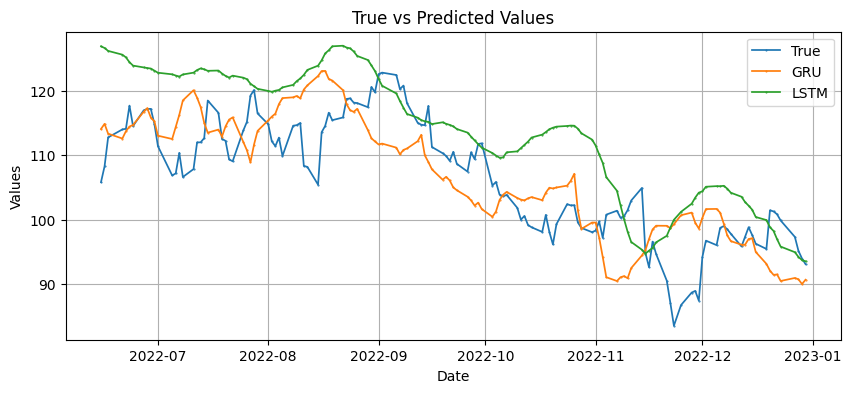

In [929]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

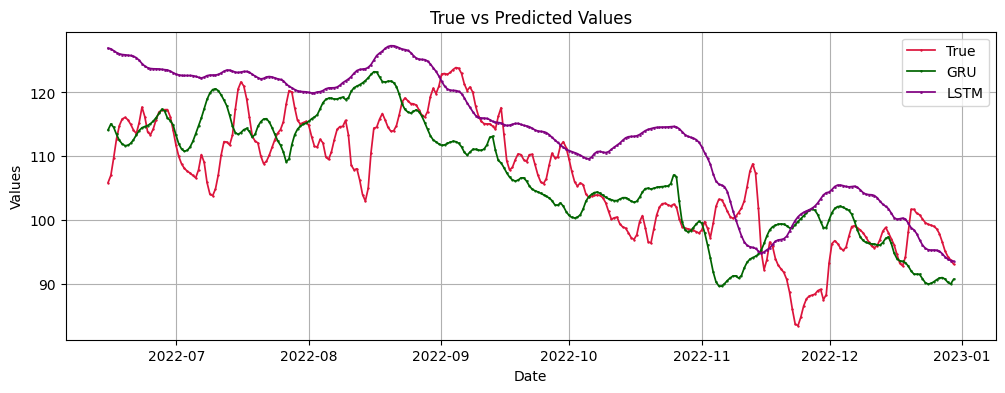

In [930]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## United Health Group

#### Company Data

In [994]:
company = "UNH"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [995]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [996]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [997]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [998]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [999]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [1000]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  293.980011  295.700012  289.790009  292.500000  276.971863   
1 2020-01-03  287.269989  291.880005  284.359985  289.540009  274.169037   
2 2020-01-06  288.000000  291.660004  287.220001  291.549988  276.072357   
3 2020-01-07  290.700012  291.489990  287.579987  289.790009  274.405762   
4 2020-01-08  291.500000  297.380005  290.040009  295.899994  280.191345   

    volume  
0  2543400  
1  2711400  
2  3079100  
3  2492900  
4  3379200

#### Indicators

In [1001]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [1002]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [1003]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [1004]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [1005]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [1006]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [1007]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [1008]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [1009]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [1010]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [1011]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [1012]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [1013]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [1014]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [1015]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  293.980011  295.700012  289.790009  292.500000  276.971863   
1 2020-01-03  287.269989  291.880005  284.359985  289.540009  274.169037   
2 2020-01-06  288.000000  291.660004  287.220001  291.549988  276.072357   
3 2020-01-07  290.700012  291.489990  287.579987  289.790009  274.405762   
4 2020-01-08  291.500000  297.380005  290.040009  295.899994  280.191345   

    volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0  2543400  NaN   NaN  292.500000  ...       NaN          NaN      NaN   
1  2711400  NaN   NaN  290.963081  ...       NaN    -0.010171      NaN   
2  3079100  NaN   NaN  291.173951  ...       NaN     0.006918      NaN   
3  2492900  NaN   NaN  290.787061  ...       NaN    -0.006055      NaN   
4  3379200  NaN   NaN  291.972771  ...       NaN     0.020865      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN        0.066053         NaN         NaN         NaN  NaN  
2      NaN      NaN        0.135613         NaN         NaN         NaN  NaN  
3      NaN      NaN       -0.190380         NaN         NaN         NaN  NaN  
4      NaN      NaN        0.355530         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [1016]:
data = data.ffill().bfill()

#### Preprocessing

In [1017]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [1018]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [1019]:
df_indicators

date       close   volume         ma7        ma21       26ema  \
0   2020-01-02  292.500000  2543400  292.661429  291.334285  292.500000   
1   2020-01-03  289.540009  2711400  292.661429  291.334285  290.963081   
2   2020-01-06  291.549988  3079100  292.661429  291.334285  291.173951   
3   2020-01-07  289.790009  2492900  292.661429  291.334285  290.787061   
4   2020-01-08  295.899994  3379200  292.661429  291.334285  291.972771   
..         ...         ...      ...         ...         ...         ...   
751 2022-12-23  531.309998  1292300  525.875715  534.603803  531.579074   
752 2022-12-27  531.989990  1596700  526.491429  534.335708  531.609513   
753 2022-12-28  528.450012  1694200  527.170000  534.153803  531.375476   
754 2022-12-29  529.880005  1379700  528.067147  534.243327  531.264700   
755 2022-12-30  530.179993  1849600  529.491429  533.406183  531.184351   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0    292.500000  0.000000  6.226770  304.732039  ...  276.012834    -0.010171   
1    290.896671 -0.066410  6.226770  304.732039  ...  276.012834    -0.010171   
2    291.151661 -0.022290  6.226770  304.732039  ...  276.012834     0.006918   
3    290.721840 -0.065221  6.226770  304.732039  ...  276.012834    -0.006055   
4    292.128726  0.155955  6.226770  304.732039  ...  276.012834     0.020865   
..          ...       ...       ...         ...  ...         ...          ...   
751  530.281139 -1.297936  8.225399  550.903792  ...  529.273330     0.007974   
752  530.544039 -1.065474  8.229548  550.898088  ...  529.722497     0.001279   
753  530.221881 -1.153594  8.211612  550.884717  ...  529.938163    -0.006676   
754  530.169285 -1.095415  7.641079  548.849650  ...  530.049997     0.002702   
755  530.170932 -1.013419  7.634320  548.499633  ...  530.101830     0.000566   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.273406  0.311509  0.808484        0.066053    9.940418    7.354247   
1    0.273406  0.311509  0.808484        0.066053    9.940418    7.354247   
2    0.273406  0.311509  0.808484        0.135613    9.940418    7.354247   
3    0.273406  0.311509  0.808484       -0.190380    9.940418    7.354247   
4    0.273406  0.311509  0.808484        0.355530    9.940418    7.354247   
..        ...       ...       ...             ...         ...         ...   
751  0.174608  0.265561  0.237613       -0.302063    8.769837    8.505837   
752  0.158328  0.235960  0.237000        0.235549    8.796707    8.011100   
753  0.147201  0.231707  0.233901        0.061063    8.749312    7.956757   
754  0.148676  0.222079  0.232042       -0.185633    8.727144    7.986217   
755  0.107307  0.217460  0.231557        0.340581    8.837645    7.938520   

     Volu60d_ff       atr  
0      7.064224  6.008575  
1      7.064224  6.008575  
2      7.064224  6.008575  
3      7.064224  6.008575  
4      7.064224  6.008575  
..          ...       ...  
751    6.774156  9.257860  
752    6.765518  9.232147  
753    6.746671  9.505724  
754    6.756304  9.280722  
755    6.741013  8.997864  

[756 rows x 27 columns]

In [1020]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [1021]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [1022]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.925893  0.026207  0.941023  0.980584  0.985589  0.960794   
754 2022-12-29  0.929862  0.006104  0.943756  0.980881  0.985204  0.960624   
755 2022-12-30  0.930695  0.036140  0.948094  0.978100  0.984926  0.960629   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.551147  0.190224    0.946746  ...  0.999379     0.590100  0.056278   
754  0.552941  0.167995    0.939715  ...  0.999803     0.620344  0.057203   
755  0.555469  0.167732    0.938505  ...  1.000000     0.613455  0.031253   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.111761  0.125129        0.177064    0.353240    0.476854    0.418216   
754  0.102337  0.122558        0.126996    0.352159    0.479665    0.419561   
755  0.097816  0.121886        0.233793    0.357549    0.475113    0.417426   

          atr  
753  0.193893  
754  0.183193  
755  0.169741  

[3 rows x 27 columns]

In [1023]:
df_time_series = df_normalized.set_index('date')

In [1024]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [1025]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.841628  0.120002  0.821691  0.848054  0.867851  0.835452   
2022-05-26  0.853118  0.090868  0.825911  0.846222  0.869077  0.840792   
2022-05-27  0.866663  0.131987  0.841457  0.843483  0.871468  0.847742   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.403138  0.340196    0.831063    0.819213  ...  0.909675   
2022-05-26  0.443107  0.254708    0.812067    0.828898  ...  0.910740   
2022-05-27  0.488060  0.249982    0.810980    0.829402  ...  0.912037   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.615063  0.149826  0.149176  0.159871        0.203114   
2022-05-26     0.638322  0.139682  0.149812  0.156685        0.135411   
2022-05-27     0.642811  0.137882  0.151878  0.157585        0.212922   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.113210    0.077779    0.073399  0.405958  
2022-05-26    0.116710    0.077258    0.071899  0.380821  
2022-05-27    0.094631    0.066666    0.072692  0.389415  

[3 rows x 26 columns]

In [1026]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [1027]:
time_steps = 14

In [1028]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [1029]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [1030]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [1031]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 15s 173ms/step - loss: 0.0612 - val_loss: 0.0772
Epoch 2/50
15/15 [==============================] - 1s 39ms/step - loss: 0.0124 - val_loss: 0.0019
Epoch 3/50
15/15 [==============================] - 1s 44ms/step - loss: 0.0056 - val_loss: 0.0109
Epoch 4/50
15/15 [==============================] - 1s 57ms/step - loss: 0.0035 - val_loss: 0.0050
Epoch 5/50
15/15 [==============================] - 1s 68ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 6/50
15/15 [==============================] - 1s 67ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 7/50
15/15 [==============================] - 1s 61ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 8/50
15/15 [==============================] - 1s 59ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 9/50
15/15 [==============================] - 1s 57ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 10/50
15/15 [==============================] - 1s 46ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 1

In [1032]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 6ms/step


#### L S T M

In [1033]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [1034]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 143ms/step - loss: 0.0520 - val_loss: 0.1162
Epoch 2/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0108 - val_loss: 0.0160
Epoch 3/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0065 - val_loss: 0.0075
Epoch 4/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0050 - val_loss: 0.0113
Epoch 5/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 6/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0039 - val_loss: 0.0057
Epoch 7/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0032 - val_loss: 0.0086
Epoch 8/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0037 - val_loss: 0.0098
Epoch 9/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0033 - val_loss: 0.0097
Epoch 10/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 11

In [1035]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 2s 9ms/step


#### Initial Reports

In [1036]:
true_val = X_test[:,0,0]

In [1037]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.841627510
Example 2 ---> Value 0.853118294
Example 3 ---> Value 0.866662866

             L S T M            
Example 1 ---> Value 0.749151528
Example 2 ---> Value 0.742532909
Example 3 ---> Value 0.735699117

              G R U             
Example 1 ---> Value 0.786179185
Example 2 ---> Value 0.782060087
Example 3 ---> Value 0.772041798


#### Inverse Scaling

In [1038]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [1039]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [1040]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [1041]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 498.089996338
Example 2 ---> Value 502.230010986
Example 3 ---> Value 507.109985352

             L S T M            
Example 1 ---> Value 464.771850586
Example 2 ---> Value 462.387207031
Example 3 ---> Value 459.925048828

              G R U             
Example 1 ---> Value 478.112548828
Example 2 ---> Value 476.628479004
Example 3 ---> Value 473.018981934


In [1042]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.841628  0.120002  0.821691  0.848054  0.867851  0.835452   
2022-05-26  0.853118  0.090868  0.825911  0.846222  0.869077  0.840792   
2022-05-27  0.866663  0.131987  0.841457  0.843483  0.871468  0.847742   
2022-05-31  0.837992  0.173790  0.849389  0.841622  0.871024  0.848477   
2022-06-01  0.826251  0.030790  0.852356  0.840261  0.869526  0.846992   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.403138  0.340196    0.831063    0.819213  ...  0.909675   
2022-05-26  0.443107  0.254708    0.812067    0.828898  ...  0.910740   
2022-05-27  0.488060  0.249982    0.810980    0.829402  ...  0.912037   
2022-05-31  0.498997  0.243514    0.809078    0.829738  ...  0.911919   
2022-06-01  0.498162  0.236824    0.806670    0.829708  ...  0.912278   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.615063  0.149826  0.149176  0.159871        0.203114   
2022-05-26     0.638322  0.139682  0.149812  0.156685        0.135411   
2022-05-27     0.642811  0.137882  0.151878  0.157585        0.212922   
2022-05-31     0.545263  0.153929  0.157148  0.155886        0.204303   
2022-06-01     0.584054  0.155407  0.156318  0.150064        0.051246   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.113210    0.077779    0.073399  0.405958  
2022-05-26    0.116710    0.077258    0.071899  0.380821  
2022-05-27    0.094631    0.066666    0.072692  0.389415  
2022-05-31    0.095595    0.035838    0.068432  0.376575  
2022-06-01    0.156514    0.076636    0.092026  0.367981  

[5 rows x 26 columns]

In [1043]:
test.reset_index(inplace=True)

In [1044]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.841628  0.120002  0.821691  0.848054  0.867851  0.835452   
1 2022-05-26  0.853118  0.090868  0.825911  0.846222  0.869077  0.840792   
2 2022-05-27  0.866663  0.131987  0.841457  0.843483  0.871468  0.847742   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.403138  0.340196    0.831063  ...  0.909675     0.615063  0.149826   
1  0.443107  0.254708    0.812067  ...  0.910740     0.638322  0.139682   
2  0.488060  0.249982    0.810980  ...  0.912037     0.642811  0.137882   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.149176  0.159871        0.203114    0.113210    0.077779    0.073399   
1  0.149812  0.156685        0.135411    0.116710    0.077258    0.071899   
2  0.151878  0.157585        0.212922    0.094631    0.066666    0.072692   

        atr  
0  0.405958  
1  0.380821  
2  0.389415  

[3 rows x 27 columns]

In [1045]:
results = pd.DataFrame()

In [1046]:
results['date'] = test['date'].tail(len(X_test))

In [1047]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [1048]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [1049]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  532.270020  515.576355  491.224487
143 2022-12-19  528.000000  506.170288  488.625793
144 2022-12-20  547.760010  505.195801  485.178650
145 2022-12-21  536.909973  503.082764  481.409058
146 2022-12-22  536.159973  506.000854  477.776123
147 2022-12-23  535.039978  508.658875  474.885742
148 2022-12-27  539.320007  512.316101  473.120300
149 2022-12-28  542.909973  515.153015  472.640930
150 2022-12-29  547.919983  515.505737  472.813538
151 2022-12-30  539.200012  515.474609  473.162292

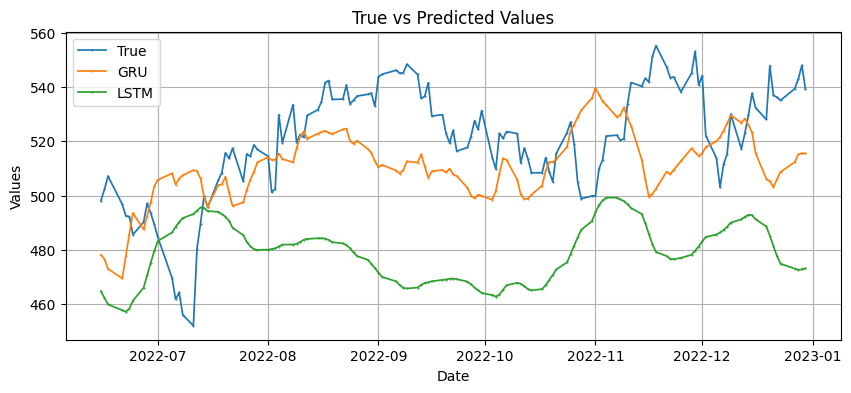

In [1050]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

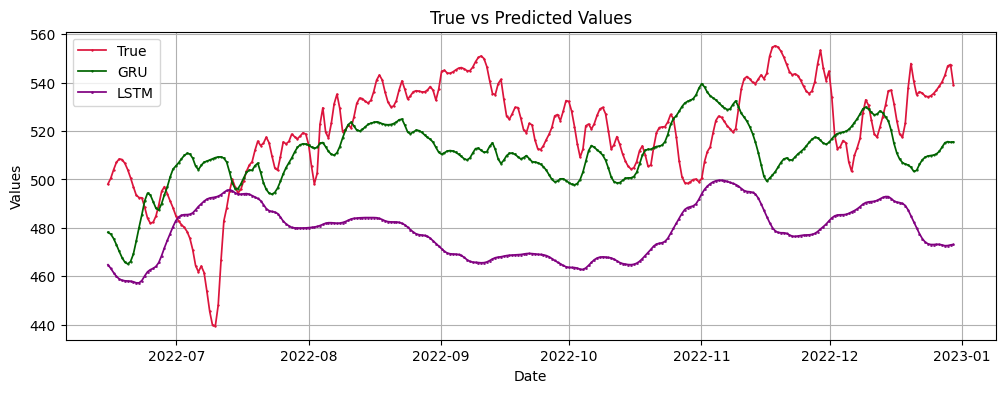

In [1051]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## Eli Lilly & Co.

#### Company Data

In [46]:
company = "LLY"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [47]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [48]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [49]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [50]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [51]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [52]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  131.770004  132.259995  130.729996  132.210007  124.724251   
1 2020-01-03  130.300003  132.470001  130.229996  131.770004  124.309166   
2 2020-01-06  131.419998  132.559998  130.940002  132.259995  124.771416   
3 2020-01-07  131.699997  132.929993  131.699997  132.509995  125.007271   
4 2020-01-08  132.460007  134.210007  132.009995  133.710007  126.139336   

    volume  
0  2204200  
1  1963500  
2  2102900  
3  2448300  
4  5188600

#### Indicators

In [53]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [54]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [55]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [56]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [57]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [58]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [59]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [60]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [61]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [62]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [63]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [64]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [65]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [66]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [67]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  131.770004  132.259995  130.729996  132.210007  124.724251   
1 2020-01-03  130.300003  132.470001  130.229996  131.770004  124.309166   
2 2020-01-06  131.419998  132.559998  130.940002  132.259995  124.771416   
3 2020-01-07  131.699997  132.929993  131.699997  132.509995  125.007271   
4 2020-01-08  132.460007  134.210007  132.009995  133.710007  126.139336   

    volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0  2204200  NaN   NaN  132.210007  ...       NaN          NaN      NaN   
1  1963500  NaN   NaN  131.981544  ...       NaN    -0.003334      NaN   
2  2102900  NaN   NaN  132.081589  ...       NaN     0.003712      NaN   
3  2448300  NaN   NaN  132.201352  ...       NaN     0.001888      NaN   
4  5188600  NaN   NaN  132.551215  ...       NaN     0.009015      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN       -0.109201         NaN         NaN         NaN  NaN  
2      NaN      NaN        0.070996         NaN         NaN         NaN  NaN  
3      NaN      NaN        0.164249         NaN         NaN         NaN  NaN  
4      NaN      NaN        1.119266         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [68]:
data = data.ffill().bfill()

#### Preprocessing

In [69]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [70]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [71]:
df_indicators

date       close   volume         ma7        ma21       26ema  \
0   2020-01-02  132.210007  2204200  133.768572  138.125714  132.210007   
1   2020-01-03  131.770004  1963500  133.768572  138.125714  131.981544   
2   2020-01-06  132.259995  2102900  133.768572  138.125714  132.081589   
3   2020-01-07  132.509995  2448300  133.768572  138.125714  132.201352   
4   2020-01-08  133.710007  5188600  133.768572  138.125714  132.551215   
..         ...         ...      ...         ...         ...         ...   
751 2022-12-23  367.899994  1030300  362.645717  365.792858  362.629166   
752 2022-12-27  364.880005  1372100  363.341431  365.775239  362.795895   
753 2022-12-28  365.220001   996000  364.105717  365.749050  362.975459   
754 2022-12-29  367.019989  1077900  365.425716  365.895239  363.275053   
755 2022-12-30  365.839996  1388000  366.311428  365.645716  363.465049   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0    132.210007  0.000000  3.625308  145.300616  ...  137.359667    -0.003334   
1    131.971672 -0.009872  3.625308  145.300616  ...  137.359667    -0.003334   
2    132.084204  0.002616  3.625308  145.300616  ...  137.359667     0.003712   
3    132.218610  0.017258  3.625308  145.300616  ...  137.359667     0.001888   
4    132.623817  0.072602  3.625308  145.300616  ...  137.359667     0.009015   
..          ...       ...       ...         ...  ...         ...          ...   
751  364.245274  1.616108  5.066559  375.953119  ...  353.291501     0.007065   
752  364.342925  1.547030  5.070928  375.917357  ...  353.983668    -0.008243   
753  364.477860  1.502401  5.054791  375.948584  ...  354.711501     0.000931   
754  364.868957  1.593903  4.912765  375.461532  ...  355.330334     0.004916   
755  365.018347  1.553298  4.787979  374.987460  ...  355.898001    -0.003220   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.101256  0.176792  0.586058       -0.109201    6.089761    5.921540   
1    0.101256  0.176792  0.586058       -0.109201    6.089761    5.921540   
2    0.101256  0.176792  0.586058        0.070996    6.089761    5.921540   
3    0.101256  0.176792  0.586058        0.164249    6.089761    5.921540   
4    0.101256  0.176792  0.586058        1.119266    6.089761    5.921540   
..        ...       ...       ...             ...         ...         ...   
751  0.223685  0.241246  0.239744       -0.473827    8.197914    8.899608   
752  0.211069  0.201002  0.236207        0.331748    8.340579    8.257867   
753  0.167592  0.198997  0.235689       -0.274105    6.926960    8.252267   
754  0.156182  0.191667  0.230644        0.082229    6.958706    8.238381   
755  0.147019  0.191010  0.230719        0.287689    6.989461    8.242093   

     Volu60d_ff       atr  
0      5.149510  2.140717  
1      5.149510  2.140717  
2      5.149510  2.140717  
3      5.149510  2.140717  
4      5.149510  2.140717  
..          ...       ...  
751    7.471335  8.021428  
752    7.486840  8.041428  
753    7.490734  7.853572  
754    7.467963  7.780001  
755    7.464471  7.255003  

[756 rows x 27 columns]

In [72]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [73]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [74]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.962692  0.022211  0.971332  0.999373  0.997885  0.984979   
754 2022-12-29  0.969731  0.027144  0.976736  1.000000  0.999179  0.986618   
755 2022-12-30  0.965117  0.045820  0.980362  0.998929  1.000000  0.987245   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.448294  0.210262    0.990375  ...  0.994571     0.423410  0.072075   
754  0.452699  0.201725    0.988287  ...  0.997402     0.439287  0.061720   
755  0.450744  0.194225    0.986255  ...  1.000000     0.406870  0.053404   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.048811  0.050670        0.080281    0.201573    0.273453    0.289798   
754  0.037731  0.038099        0.141089    0.202755    0.272646    0.287800   
755  0.036737  0.038287        0.176151    0.203901    0.272862    0.287494   

          atr  
753  0.555571  
754  0.548416  
755  0.497361  

[3 rows x 27 columns]

In [75]:
df_time_series = df_normalized.set_index('date')

In [76]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [77]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.735051  0.154690  0.707310  0.692220  0.703379  0.707300   
2022-05-26  0.760275  0.160020  0.714363  0.698018  0.709349  0.717120   
2022-05-27  0.799460  0.184718  0.730907  0.703376  0.718084  0.731891   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.541101  0.292245    0.696867    0.690133  ...  0.691254   
2022-05-26  0.587344  0.367258    0.711038    0.683074  ...  0.695776   
2022-05-27  0.659642  0.498258    0.736444    0.671389  ...  0.700721   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.433349  0.227107  0.222375  0.140221        0.150833   
2022-05-26     0.502534  0.229962  0.224002  0.141645        0.131783   
2022-05-27     0.545060  0.245496  0.241700  0.152983        0.148366   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.212040    0.169631    0.125381  0.728119  
2022-05-26    0.209644    0.169093    0.124122  0.732078  
2022-05-27    0.208534    0.165173    0.122428  0.749930  

[3 rows x 26 columns]

In [78]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [79]:
time_steps = 14

In [80]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [81]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [82]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [83]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 8s 116ms/step - loss: 0.0200 - val_loss: 0.0025
Epoch 2/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0045 - val_loss: 0.0103
Epoch 3/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0027 - val_loss: 0.0090
Epoch 4/50
15/15 [==============================] - 0s 33ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 5/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 6/50
15/15 [==============================] - 1s 42ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 7/50
15/15 [==============================] - 1s 45ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 8/50
15/15 [==============================] - 1s 45ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 9/50
15/15 [==============================] - 1s 45ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 10/50
15/15 [==============================] - 1s 46ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 11

In [84]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 9ms/step


#### L S T M

In [85]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [86]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 10s 119ms/step - loss: 0.0234 - val_loss: 0.0463
Epoch 2/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0047 - val_loss: 0.0144
Epoch 3/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0031 - val_loss: 0.0069
Epoch 4/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0027 - val_loss: 0.0081
Epoch 5/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0024 - val_loss: 0.0086
Epoch 6/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0023 - val_loss: 0.0091
Epoch 7/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0071
Epoch 8/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0018 - val_loss: 0.0091
Epoch 9/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 10/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 1

In [87]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 2s 9ms/step


#### Initial Reports

In [88]:
true_val = X_test[:,0,0]

In [89]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.735051432
Example 2 ---> Value 0.760275247
Example 3 ---> Value 0.799460336

             L S T M            
Example 1 ---> Value 0.603715062
Example 2 ---> Value 0.591095567
Example 3 ---> Value 0.577679157

              G R U             
Example 1 ---> Value 0.634842634
Example 2 ---> Value 0.638695955
Example 3 ---> Value 0.624117792


#### Inverse Scaling

In [90]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [91]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [92]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [93]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 307.010009766
Example 2 ---> Value 313.459991455
Example 3 ---> Value 323.480010986

             L S T M            
Example 1 ---> Value 273.425964355
Example 2 ---> Value 270.199035645
Example 3 ---> Value 266.768341064

              G R U             
Example 1 ---> Value 281.385620117
Example 2 ---> Value 282.370971680
Example 3 ---> Value 278.643188477


In [94]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.735051  0.154690  0.707310  0.692220  0.703379  0.707300   
2022-05-26  0.760275  0.160020  0.714363  0.698018  0.709349  0.717120   
2022-05-27  0.799460  0.184718  0.730907  0.703376  0.718084  0.731891   
2022-05-31  0.760197  0.341582  0.746797  0.707731  0.722959  0.737915   
2022-06-01  0.750968  0.126733  0.753949  0.712130  0.726717  0.741490   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.541101  0.292245    0.696867    0.690133  ...  0.691254   
2022-05-26  0.587344  0.367258    0.711038    0.683074  ...  0.695776   
2022-05-27  0.659642  0.498258    0.736444    0.671389  ...  0.700721   
2022-05-31  0.674500  0.527318    0.745708    0.672340  ...  0.704577   
2022-06-01  0.673676  0.532813    0.751424    0.676390  ...  0.708348   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.433349  0.227107  0.222375  0.140221        0.150833   
2022-05-26     0.502534  0.229962  0.224002  0.141645        0.131783   
2022-05-27     0.545060  0.245496  0.241700  0.152983        0.148366   
2022-05-31     0.294085  0.284590  0.260934  0.172867        0.247370   
2022-06-01     0.389589  0.288447  0.261415  0.173834        0.030409   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.212040    0.169631    0.125381  0.728119  
2022-05-26    0.209644    0.169093    0.124122  0.732078  
2022-05-27    0.208534    0.165173    0.122428  0.749930  
2022-05-31    0.138650    0.177191    0.136417  0.791748  
2022-06-01    0.146278    0.192168    0.147838  0.769589  

[5 rows x 26 columns]

In [95]:
test.reset_index(inplace=True)

In [96]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.735051  0.154690  0.707310  0.692220  0.703379  0.707300   
1 2022-05-26  0.760275  0.160020  0.714363  0.698018  0.709349  0.717120   
2 2022-05-27  0.799460  0.184718  0.730907  0.703376  0.718084  0.731891   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.541101  0.292245    0.696867  ...  0.691254     0.433349  0.227107   
1  0.587344  0.367258    0.711038  ...  0.695776     0.502534  0.229962   
2  0.659642  0.498258    0.736444  ...  0.700721     0.545060  0.245496   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.222375  0.140221        0.150833    0.212040    0.169631    0.125381   
1  0.224002  0.141645        0.131783    0.209644    0.169093    0.124122   
2  0.241700  0.152983        0.148366    0.208534    0.165173    0.122428   

        atr  
0  0.728119  
1  0.732078  
2  0.749930  

[3 rows x 27 columns]

In [97]:
results = pd.DataFrame()

In [98]:
results['date'] = test['date'].tail(len(X_test))

In [99]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [100]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [101]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  365.769989  331.992615  295.543335
143 2022-12-19  363.950012  332.066589  295.468445
144 2022-12-20  371.079987  330.021912  294.807587
145 2022-12-21  370.329987  330.315735  294.141785
146 2022-12-22  374.760010  335.331177  293.459564
147 2022-12-23  369.290009  334.444122  292.813843
148 2022-12-27  368.540009  335.884277  292.708618
149 2022-12-28  371.970001  335.281281  292.730042
150 2022-12-29  371.790009  335.245239  292.907898
151 2022-12-30  360.989990  336.901367  293.541534

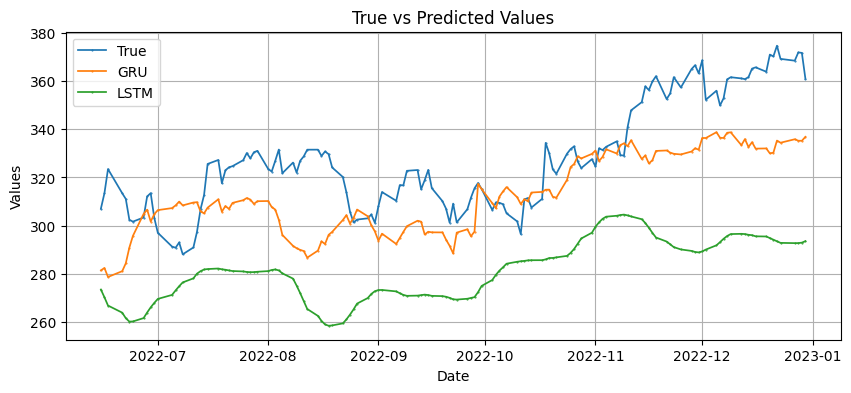

In [102]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

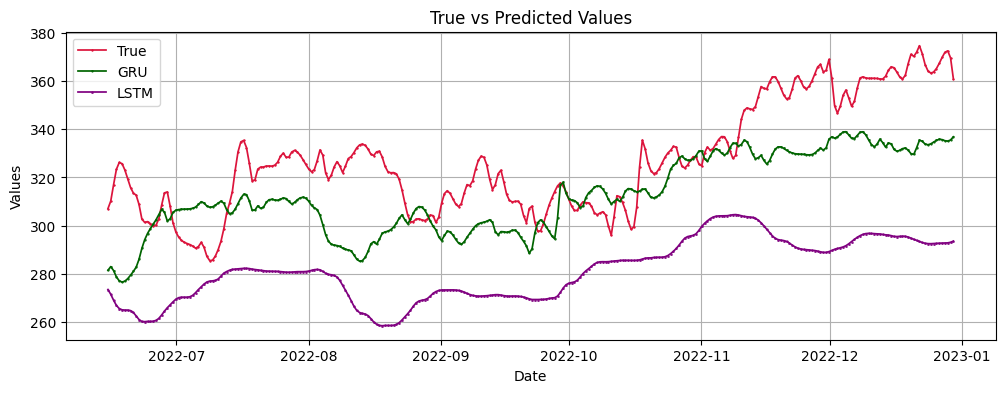

In [103]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## JP Morgan Chase

#### Company Data

In [104]:
company = "JPM"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [105]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [106]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [107]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [108]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [109]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [110]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  139.789993  141.100006  139.259995  141.089996  125.020386   
1 2020-01-03  137.500000  139.229996  137.080002  138.339996  123.370560   
2 2020-01-06  136.559998  138.270004  136.500000  138.229996  123.272461   
3 2020-01-07  137.279999  137.860001  135.820007  135.880005  121.176750   
4 2020-01-08  135.699997  137.580002  135.600006  136.940002  122.122070   

     volume  
0  10803700  
1  10386800  
2  10259000  
3  10531300  
4   9695300

#### Indicators

In [111]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [112]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [113]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [114]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [115]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [116]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [117]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [118]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [119]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [120]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [121]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [122]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [123]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [124]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [125]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  139.789993  141.100006  139.259995  141.089996  125.020386   
1 2020-01-03  137.500000  139.229996  137.080002  138.339996  123.370560   
2 2020-01-06  136.559998  138.270004  136.500000  138.229996  123.272461   
3 2020-01-07  137.279999  137.860001  135.820007  135.880005  121.176750   
4 2020-01-08  135.699997  137.580002  135.600006  136.940002  122.122070   

     volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0  10803700  NaN   NaN  141.089996  ...       NaN          NaN      NaN   
1  10386800  NaN   NaN  139.662112  ...       NaN    -0.019684      NaN   
2  10259000  NaN   NaN  139.147566  ...       NaN    -0.000795      NaN   
3  10531300  NaN   NaN  138.234099  ...       NaN    -0.017147      NaN   
4   9695300  NaN   NaN  137.933993  ...       NaN     0.007771      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN       -0.038589         NaN         NaN         NaN  NaN  
2      NaN      NaN       -0.012304         NaN         NaN         NaN  NaN  
3      NaN      NaN        0.026543         NaN         NaN         NaN  NaN  
4      NaN      NaN       -0.079382         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [126]:
data = data.ffill().bfill()

#### Preprocessing

In [127]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [128]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [129]:
df_indicators

date       close    volume         ma7        ma21       26ema  \
0   2020-01-02  141.089996  10803700  137.712858  136.395713  141.089996   
1   2020-01-03  138.339996  10386800  137.712858  136.395713  139.662112   
2   2020-01-06  138.229996  10259000  137.712858  136.395713  139.147566   
3   2020-01-07  135.880005  10531300  137.712858  136.395713  138.234099   
4   2020-01-08  136.940002   9695300  137.712858  136.395713  137.933993   
..         ...         ...       ...         ...         ...         ...   
751 2022-12-23  131.279999   5091900  130.605715  132.984287  131.493461   
752 2022-12-27  131.740005   5411000  130.840001  132.746192  131.511724   
753 2022-12-28  132.460007   8827700  131.292860  132.656192  131.581967   
754 2022-12-29  133.220001   6585200  131.744289  132.497144  131.703303   
755 2022-12-30  134.100006   9292500  132.231432  132.302859  131.880836   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0    141.089996  0.000000  2.043563  140.684623  ...  122.484667    -0.019684   
1    139.600413 -0.061699  2.043563  140.684623  ...  122.484667    -0.019684   
2    139.065539 -0.082028  2.043563  140.684623  ...  122.484667    -0.000795   
3    138.059990 -0.174109  2.043563  140.684623  ...  122.484667    -0.017147   
4    137.755694 -0.178299  2.043563  140.684623  ...  122.484667     0.007771   
..          ...       ...       ...         ...  ...         ...          ...   
751  131.638995  0.145534  2.421075  137.638651  ...  125.924667     0.004734   
752  131.654535  0.142811  2.403207  137.472415  ...  126.378667     0.003498   
753  131.778454  0.196487  2.221562  136.904125  ...  126.790833     0.005450   
754  132.000230  0.296928  1.783116  135.779234  ...  127.131667     0.005721   
755  132.323273  0.442436  1.581565  135.269132  ...  127.526834     0.006584   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.185259  0.183818  0.806233       -0.038589    6.036952    4.749392   
1    0.185259  0.183818  0.806233       -0.038589    6.036952    4.749392   
2    0.185259  0.183818  0.806233       -0.012304    6.036952    4.749392   
3    0.185259  0.183818  0.806233        0.026543    6.036952    4.749392   
4    0.185259  0.183818  0.806233       -0.079382    6.036952    4.749392   
..        ...       ...       ...             ...         ...         ...   
751  0.188212  0.182253  0.297152       -0.411219    5.654209    8.019437   
752  0.168200  0.182563  0.294418        0.062668    5.637094    7.931657   
753  0.172189  0.181197  0.289189        0.631436    6.432709    8.100025   
754  0.173985  0.180806  0.275507       -0.254030    6.624730    8.137870   
755  0.106062  0.181761  0.270976        0.411119    6.842356    8.053236   

     Volu60d_ff       atr  
0      4.721634  1.957140  
1      4.721634  1.957140  
2      4.721634  1.957140  
3      4.721634  1.957140  
4      4.721634  1.957140  
..          ...       ...  
751    6.620388  2.815001  
752    6.606476  2.560001  
753    6.687152  2.535001  
754    6.697806  2.492859  
755    6.692900  2.502145  

[756 rows x 27 columns]

In [130]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [131]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [132]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.576065  0.109519  0.536570  0.540893  0.528824  0.529945   
754 2022-12-29  0.584259  0.065719  0.541922  0.538887  0.530400  0.532704   
755 2022-12-30  0.593747  0.118598  0.547698  0.536437  0.532707  0.536723   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.692876  0.060444    0.501266  ...  0.475078     0.511269  0.063294   
754  0.698533  0.032238    0.486943  ...  0.479712     0.512095  0.064410   
755  0.706729  0.019271    0.480448  ...  0.485084     0.514728  0.022215   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.017250  0.139720        0.383457    0.340534    0.637642    0.593249   
754  0.016881  0.121295        0.132557    0.353779    0.642236    0.595103   
755  0.017782  0.115194        0.321029    0.368789    0.631961    0.594249   

          atr  
753  0.069179  
754  0.064498  
755  0.065530  

[3 rows x 27 columns]

In [133]:
df_time_series = df_normalized.set_index('date')

In [134]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [135]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.519784  0.186723  0.429977  0.400956  0.428453  0.414641   
2022-05-26  0.543504  0.249430  0.442274  0.405772  0.433826  0.427905   
2022-05-27  0.563235  0.155421  0.461211  0.410534  0.440563  0.442630   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.605993  0.124193    0.387775    0.466368  ...  0.513763   
2022-05-26  0.642745  0.152314    0.402790    0.460401  ...  0.511534   
2022-05-27  0.680207  0.184827    0.423243    0.456048  ...  0.509943   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.515814  0.190574  0.174621  0.186424        0.108578   
2022-05-26     0.546945  0.190431  0.165644  0.185219        0.275717   
2022-05-27     0.537475  0.190902  0.166445  0.186911        0.119250   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.270304    0.329421    0.320045  0.229829  
2022-05-26    0.277305    0.133183    0.305043  0.228560  
2022-05-27    0.269413    0.124779    0.311036  0.219913  

[3 rows x 26 columns]

In [136]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [137]:
time_steps = 14

In [138]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [139]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [140]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [141]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 170ms/step - loss: 0.0458 - val_loss: 0.0050
Epoch 2/50
15/15 [==============================] - 1s 38ms/step - loss: 0.0128 - val_loss: 0.0051
Epoch 3/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0077 - val_loss: 0.0042
Epoch 4/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0063 - val_loss: 0.0044
Epoch 5/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 6/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 7/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0037 - val_loss: 0.0053
Epoch 8/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0039 - val_loss: 0.0053
Epoch 9/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 10/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0036 - val_loss: 0.0052
Epoch 11

In [142]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 2s 9ms/step


#### L S T M

In [143]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [144]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 8s 124ms/step - loss: 0.0917 - val_loss: 0.0151
Epoch 2/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0210 - val_loss: 0.0241
Epoch 3/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0116 - val_loss: 0.0123
Epoch 4/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0113 - val_loss: 0.0080
Epoch 5/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0111 - val_loss: 0.0096
Epoch 6/50
15/15 [==============================] - 1s 42ms/step - loss: 0.0101 - val_loss: 0.0078
Epoch 7/50
15/15 [==============================] - 1s 47ms/step - loss: 0.0084 - val_loss: 0.0092
Epoch 8/50
15/15 [==============================] - 1s 46ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 9/50
15/15 [==============================] - 1s 44ms/step - loss: 0.0077 - val_loss: 0.0084
Epoch 10/50
15/15 [==============================] - 1s 44ms/step - loss: 0.0067 - val_loss: 0.0084
Epoch 11

In [145]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 1s 10ms/step


#### Initial Reports

In [146]:
true_val = X_test[:,0,0]

In [147]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.519784357
Example 2 ---> Value 0.543504083
Example 3 ---> Value 0.563234561

             L S T M            
Example 1 ---> Value 0.551336288
Example 2 ---> Value 0.530064821
Example 3 ---> Value 0.506836712

              G R U             
Example 1 ---> Value 0.423262835
Example 2 ---> Value 0.423591554
Example 3 ---> Value 0.403899789


#### Inverse Scaling

In [148]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [149]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [150]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [151]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 127.239997864
Example 2 ---> Value 129.440002441
Example 3 ---> Value 131.270004272

             L S T M            
Example 1 ---> Value 130.166442871
Example 2 ---> Value 128.193511963
Example 3 ---> Value 126.039108276

              G R U             
Example 1 ---> Value 118.287628174
Example 2 ---> Value 118.318115234
Example 3 ---> Value 116.491699219


In [152]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.519784  0.186723  0.429977  0.400956  0.428453  0.414641   
2022-05-26  0.543504  0.249430  0.442274  0.405772  0.433826  0.427905   
2022-05-27  0.563235  0.155421  0.461211  0.410534  0.440563  0.442630   
2022-05-31  0.573585  0.269433  0.484789  0.418262  0.447724  0.456927   
2022-06-01  0.548571  0.147417  0.506081  0.423943  0.452123  0.464585   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.605993  0.124193    0.387775    0.466368  ...  0.513763   
2022-05-26  0.642745  0.152314    0.402790    0.460401  ...  0.511534   
2022-05-27  0.680207  0.184827    0.423243    0.456048  ...  0.509943   
2022-05-31  0.713889  0.217220    0.443566    0.451665  ...  0.509451   
2022-06-01  0.729488  0.233018    0.454200    0.450123  ...  0.509610   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.515814  0.190574  0.174621  0.186424        0.108578   
2022-05-26     0.546945  0.190431  0.165644  0.185219        0.275717   
2022-05-27     0.537475  0.190902  0.166445  0.186911        0.119250   
2022-05-31     0.516872  0.184022  0.163298  0.180476        0.352509   
2022-06-01     0.440627  0.186859  0.162300  0.169223        0.100505   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.270304    0.329421    0.320045  0.229829  
2022-05-26    0.277305    0.133183    0.305043  0.228560  
2022-05-27    0.269413    0.124779    0.311036  0.219913  
2022-05-31    0.301857    0.137021    0.324499  0.197858  
2022-06-01    0.333673    0.149969    0.330393  0.191908  

[5 rows x 26 columns]

In [153]:
test.reset_index(inplace=True)

In [154]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.519784  0.186723  0.429977  0.400956  0.428453  0.414641   
1 2022-05-26  0.543504  0.249430  0.442274  0.405772  0.433826  0.427905   
2 2022-05-27  0.563235  0.155421  0.461211  0.410534  0.440563  0.442630   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.605993  0.124193    0.387775  ...  0.513763     0.515814  0.190574   
1  0.642745  0.152314    0.402790  ...  0.511534     0.546945  0.190431   
2  0.680207  0.184827    0.423243  ...  0.509943     0.537475  0.190902   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.174621  0.186424        0.108578    0.270304    0.329421    0.320045   
1  0.165644  0.185219        0.275717    0.277305    0.133183    0.305043   
2  0.166445  0.186911        0.119250    0.269413    0.124779    0.311036   

        atr  
0  0.229829  
1  0.228560  
2  0.219913  

[3 rows x 27 columns]

In [155]:
results = pd.DataFrame()

In [156]:
results['date'] = test['date'].tail(len(X_test))

In [157]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [158]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [159]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  134.350006  131.323914  140.819153
143 2022-12-19  136.559998  130.097977  139.632965
144 2022-12-20  138.179993  130.806488  138.637817
145 2022-12-21  136.240005  130.637482  137.923645
146 2022-12-22  135.160004  131.979965  137.496826
147 2022-12-23  131.369995  131.052612  137.260010
148 2022-12-27  131.589996  132.860992  137.434662
149 2022-12-28  131.500000  133.508148  137.924271
150 2022-12-29  132.880005  133.535828  138.432144
151 2022-12-30  132.160004  134.302032  139.206985

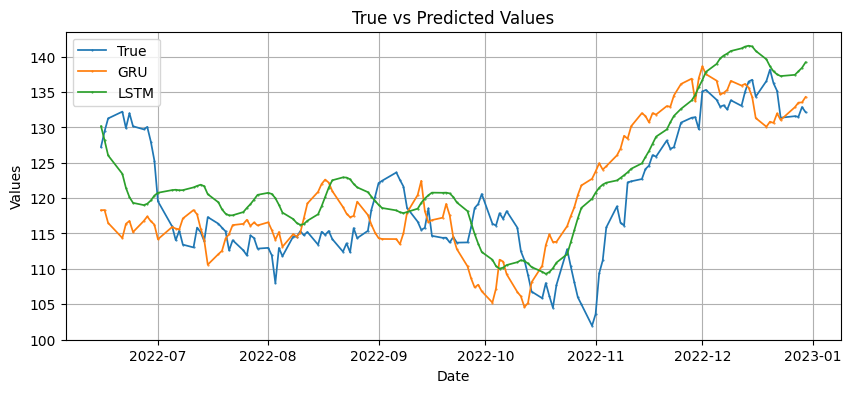

In [160]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

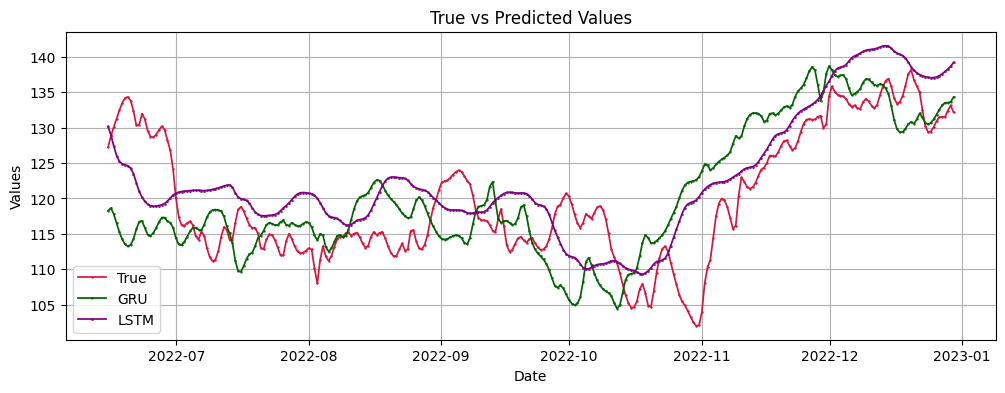

In [161]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## Exxon Mobil

#### Company Data

In [162]:
company = "XOM"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [163]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [164]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [165]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [166]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [167]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [168]:
data.head(5)

date       open       high        low      close  adj_close    volume
0 2020-01-02  70.239998  71.019997  70.239998  70.900002  57.528839  12456400
1 2020-01-03  71.339996  71.370003  70.160004  70.330002  57.066326  17386900
2 2020-01-06  70.320000  71.360001  70.230003  70.870003  57.504498  20081900
3 2020-01-07  70.500000  70.519997  69.510002  70.290001  57.033867  17387700
4 2020-01-08  70.110001  70.290001  69.169998  69.230003  56.173790  15137700

#### Indicators

In [169]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [170]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [171]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [172]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [173]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [174]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [175]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [176]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [177]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [178]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [179]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [180]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [181]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [182]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [183]:
data.head(5)

date       open       high        low      close  adj_close    volume  \
0 2020-01-02  70.239998  71.019997  70.239998  70.900002  57.528839  12456400   
1 2020-01-03  71.339996  71.370003  70.160004  70.330002  57.066326  17386900   
2 2020-01-06  70.320000  71.360001  70.230003  70.870003  57.504498  20081900   
3 2020-01-07  70.500000  70.519997  69.510002  70.290001  57.033867  17387700   
4 2020-01-08  70.110001  70.290001  69.169998  69.230003  56.173790  15137700   

   ma7  ma21      26ema  ...  close_60  Log_Returns  Vola10d  Vola30d  \
0  NaN   NaN  70.900002  ...       NaN          NaN      NaN      NaN   
1  NaN   NaN  70.604040  ...       NaN    -0.008072      NaN      NaN   
2  NaN   NaN  70.699598  ...       NaN     0.007649      NaN      NaN   
3  NaN   NaN  70.585093  ...       NaN    -0.008218      NaN      NaN   
4  NaN   NaN  70.270842  ...       NaN    -0.015195      NaN      NaN   

   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN        0.395821         NaN         NaN         NaN  NaN  
2      NaN        0.155002         NaN         NaN         NaN  NaN  
3      NaN       -0.134161         NaN         NaN         NaN  NaN  
4      NaN       -0.129402         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [184]:
data = data.ffill().bfill()

#### Preprocessing

In [185]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [186]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [187]:
df_indicators

date       close    volume         ma7        ma21       26ema  \
0   2020-01-02   70.900002  12456400   70.074287   67.821905   70.900002   
1   2020-01-03   70.330002  17386900   70.074287   67.821905   70.604040   
2   2020-01-06   70.870003  20081900   70.074287   67.821905   70.699598   
3   2020-01-07   70.290001  17387700   70.074287   67.821905   70.585093   
4   2020-01-08   69.230003  15137700   70.074287   67.821905   70.270842   
..         ...         ...       ...         ...         ...         ...   
751 2022-12-23  108.680000  11539400  106.374285  107.253333  107.349965   
752 2022-12-27  110.190002  11962100  107.052856  107.109523  107.560338   
753 2022-12-28  108.379997  10702100  107.578571  107.041428  107.621053   
754 2022-12-29  109.199997  10534000  108.154285  106.977618  107.738012   
755 2022-12-30  110.300003  11799600  108.669999  106.928095  107.927789   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0     70.900002  0.000000  2.204174   72.515348  ...   55.798500    -0.008072   
1     70.591252 -0.012788  2.204174   72.515348  ...   55.798500    -0.008072   
2     70.700048  0.000450  2.204174   72.515348  ...   55.798500     0.007649   
3     70.570612 -0.014480  2.204174   72.515348  ...   55.798500    -0.008218   
4     70.206374 -0.064468  2.204174   72.515348  ...   55.798500    -0.015195   
..          ...       ...       ...         ...  ...         ...          ...   
751  106.833150 -0.516815  2.502650  111.960800  ...  106.654500     0.026101   
752  107.349589 -0.210749  2.526789  112.028077  ...  107.035833     0.013798   
753  107.508113 -0.112941  2.409825  111.686150  ...  107.310166    -0.016563   
754  107.768403  0.030391  2.242437  111.244373  ...  107.542333     0.007537   
755  108.157880  0.230090  2.197354  111.129208  ...  107.728666     0.010023   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.135316  0.240199  0.675502        0.395821    4.687318    4.727065   
1    0.135316  0.240199  0.675502        0.395821    4.687318    4.727065   
2    0.135316  0.240199  0.675502        0.155002    4.687318    4.727065   
3    0.135316  0.240199  0.675502       -0.134161    4.687318    4.727065   
4    0.135316  0.240199  0.675502       -0.129402    4.687318    4.727065   
..        ...       ...       ...             ...         ...         ...   
751  0.245802  0.252924  0.303834       -0.126663   14.046060   10.696427   
752  0.227425  0.239093  0.301962        0.036631   14.023248   10.695255   
753  0.244561  0.243027  0.288044       -0.105333   14.076477   10.710068   
754  0.241599  0.243290  0.279902       -0.015707   13.932345   10.703422   
755  0.233902  0.243856  0.269413        0.120144   13.852780   10.634796   

     Volu60d_ff       atr  
0      5.110956  0.957142  
1      5.110956  0.957142  
2      5.110956  0.957142  
3      5.110956  0.957142  
4      5.110956  0.957142  
..          ...       ...  
751    8.111474  2.727857  
752    8.107719  2.577857  
753    8.114777  2.564286  
754    8.111466  2.462858  
755    8.042740  2.408573  

[756 rows x 27 columns]

In [188]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [189]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [190]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.929892  0.046131  0.932379  0.934979  0.967252  0.936993   
754 2022-12-29  0.939804  0.043957  0.939571  0.934167  0.968786  0.940277   
755 2022-12-30  0.953100  0.060329  0.946014  0.933537  0.971276  0.945192   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.594663  0.231801    0.925608  ...  0.994208     0.455618  0.119908   
754  0.607702  0.210006    0.920266  ...  0.997421     0.552083  0.117475   
755  0.625870  0.204136    0.918874  ...  1.000000     0.562031  0.111155   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.027312  0.071686        0.195329    1.000000     1.00000    0.994258   
754  0.027652  0.057457        0.222456    0.988441     0.99914    0.993548   
755  0.028384  0.039127        0.263573    0.982060     0.99026    0.978821   

          atr  
753  0.464516  
754  0.435887  
755  0.420565  

[3 rows x 27 columns]

In [191]:
df_time_series = df_normalized.set_index('date')

In [192]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [193]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.783875  0.295094  0.749094  0.710838  0.727853  0.737663   
2022-05-26  0.787985  0.222226  0.757179  0.718113  0.734915  0.747230   
2022-05-27  0.799468  0.238706  0.769564  0.724411  0.742377  0.757170   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.817736  0.356828    0.740948    0.684291  ...  0.695197   
2022-05-26  0.837740  0.393850    0.753531    0.683122  ...  0.698913   
2022-05-27  0.857653  0.415691    0.765048    0.686527  ...  0.702731   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.601675  0.101221  0.204614  0.252412        0.297658   
2022-05-26     0.536019  0.089486  0.203048  0.250575        0.170280   
2022-05-27     0.561068  0.068438  0.202643  0.250905        0.243068   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.037383    0.080014    0.010194  0.651613  
2022-05-26    0.049353    0.082944    0.014482  0.626613  
2022-05-27    0.043005    0.073565    0.000000  0.525000  

[3 rows x 26 columns]

In [194]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [195]:
time_steps = 14

In [196]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [197]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [198]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [199]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 127ms/step - loss: 0.0064 - val_loss: 0.0184
Epoch 2/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0021 - val_loss: 0.0095
Epoch 3/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0015 - val_loss: 0.0083
Epoch 4/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0011 - val_loss: 0.0077
Epoch 5/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0011 - val_loss: 0.0086
Epoch 6/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0010 - val_loss: 0.0074
Epoch 7/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0011 - val_loss: 0.0091
Epoch 8/50
15/15 [==============================] - 0s 29ms/step - loss: 9.2179e-04 - val_loss: 0.0072
Epoch 9/50
15/15 [==============================] - 1s 41ms/step - loss: 9.2925e-04 - val_loss: 0.0124
Epoch 10/50
15/15 [==============================] - 1s 44ms/step - loss: 0.0013 - val_loss: 0.0063


In [200]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### L S T M

In [201]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [202]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 10s 124ms/step - loss: 0.0128 - val_loss: 0.0457
Epoch 2/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0043 - val_loss: 0.0359
Epoch 3/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0026 - val_loss: 0.0258
Epoch 4/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0021 - val_loss: 0.0202
Epoch 5/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0020 - val_loss: 0.0145
Epoch 6/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0018 - val_loss: 0.0193
Epoch 7/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0017 - val_loss: 0.0160
Epoch 8/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0017 - val_loss: 0.0102
Epoch 9/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0014 - val_loss: 0.0144
Epoch 10/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0016 - val_loss: 0.0150
Epoch 1

In [203]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 2s 7ms/step


#### Initial Reports

In [204]:
true_val = X_test[:,0,0]

In [205]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.783875289
Example 2 ---> Value 0.787984999
Example 3 ---> Value 0.799468100

             L S T M            
Example 1 ---> Value 0.550419629
Example 2 ---> Value 0.539378822
Example 3 ---> Value 0.525624096

              G R U             
Example 1 ---> Value 0.725403011
Example 2 ---> Value 0.713668823
Example 3 ---> Value 0.685399294


#### Inverse Scaling

In [206]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [207]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [208]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [209]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 96.300003052
Example 2 ---> Value 96.639999390
Example 3 ---> Value 97.589996338

             L S T M            
Example 1 ---> Value 76.986213684
Example 2 ---> Value 76.072807312
Example 3 ---> Value 74.934875488

              G R U             
Example 1 ---> Value 91.462585449
Example 2 ---> Value 90.491821289
Example 3 ---> Value 88.153076172


In [210]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.783875  0.295094  0.749094  0.710838  0.727853  0.737663   
2022-05-26  0.787985  0.222226  0.757179  0.718113  0.734915  0.747230   
2022-05-27  0.799468  0.238706  0.769564  0.724411  0.742377  0.757170   
2022-05-31  0.780249  0.488363  0.778238  0.730928  0.747742  0.762494   
2022-06-01  0.802490  0.241637  0.788910  0.737856  0.754497  0.770571   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.817736  0.356828    0.740948    0.684291  ...  0.695197   
2022-05-26  0.837740  0.393850    0.753531    0.683122  ...  0.698913   
2022-05-27  0.857653  0.415691    0.765048    0.686527  ...  0.702731   
2022-05-31  0.858836  0.419157    0.771490    0.691684  ...  0.705478   
2022-06-01  0.870223  0.444811    0.782088    0.692754  ...  0.707951   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.601675  0.101221  0.204614  0.252412        0.297658   
2022-05-26     0.536019  0.089486  0.203048  0.250575        0.170280   
2022-05-27     0.561068  0.068438  0.202643  0.250905        0.243068   
2022-05-31     0.456161  0.087206  0.207895  0.243102        0.455482   
2022-06-01     0.597904  0.094225  0.209413  0.235084        0.098609   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.037383    0.080014    0.010194  0.651613  
2022-05-26    0.049353    0.082944    0.014482  0.626613  
2022-05-27    0.043005    0.073565    0.000000  0.525000  
2022-05-31    0.217657    0.138841    0.048405  0.539113  
2022-06-01    0.268142    0.168800    0.063593  0.514717  

[5 rows x 26 columns]

In [211]:
test.reset_index(inplace=True)

In [212]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.783875  0.295094  0.749094  0.710838  0.727853  0.737663   
1 2022-05-26  0.787985  0.222226  0.757179  0.718113  0.734915  0.747230   
2 2022-05-27  0.799468  0.238706  0.769564  0.724411  0.742377  0.757170   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.817736  0.356828    0.740948  ...  0.695197     0.601675  0.101221   
1  0.837740  0.393850    0.753531  ...  0.698913     0.536019  0.089486   
2  0.857653  0.415691    0.765048  ...  0.702731     0.561068  0.068438   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.204614  0.252412        0.297658    0.037383    0.080014    0.010194   
1  0.203048  0.250575        0.170280    0.049353    0.082944    0.014482   
2  0.202643  0.250905        0.243068    0.043005    0.073565    0.000000   

        atr  
0  0.651613  
1  0.626613  
2  0.525000  

[3 rows x 27 columns]

In [213]:
results = pd.DataFrame()

In [214]:
results['date'] = test['date'].tail(len(X_test))

In [215]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [216]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [217]:
results.tail(10)

date        true         gru       lstm
142 2022-12-16  109.809998   97.754272  73.184639
143 2022-12-19  110.540001   94.361832  72.551941
144 2022-12-20  111.339996   95.969238  72.609062
145 2022-12-21  110.800003   97.050262  72.927193
146 2022-12-22  109.860001   97.938278  73.505905
147 2022-12-23  106.849998   96.790894  74.030159
148 2022-12-27  103.879997   99.056808  74.745323
149 2022-12-28  103.650002  100.534225  75.602493
150 2022-12-29  104.419998   99.728302  76.369225
151 2022-12-30  103.540001  100.285370  76.997757

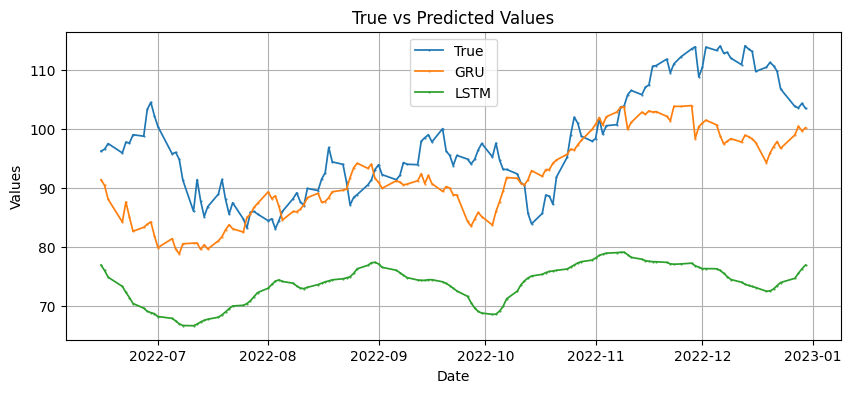

In [218]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

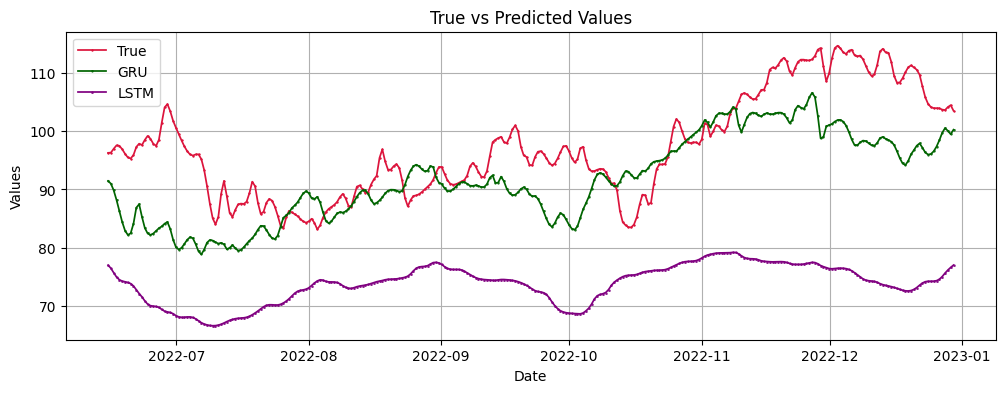

In [219]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## Visa Inc.

#### Company Data

In [746]:
company = "V"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [747]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [748]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [749]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [750]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [751]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [752]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  189.000000  191.139999  188.720001  191.119995  185.897476   
1 2020-01-03  188.410004  190.960007  187.919998  189.600006  184.419006   
2 2020-01-06  188.000000  189.210007  187.160004  189.190002  184.020233   
3 2020-01-07  189.589996  190.100006  188.600006  188.690002  183.533875   
4 2020-01-08  189.490005  192.500000  188.800003  191.919998  186.675613   

     volume  
0   8733000  
1   4899700  
2  10109500  
3   4392300  
4   5712000

#### Indicators

In [753]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [754]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [755]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [756]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [757]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [758]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [759]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [760]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [761]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [762]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [763]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [764]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [765]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [766]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [767]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  189.000000  191.139999  188.720001  191.119995  185.897476   
1 2020-01-03  188.410004  190.960007  187.919998  189.600006  184.419006   
2 2020-01-06  188.000000  189.210007  187.160004  189.190002  184.020233   
3 2020-01-07  189.589996  190.100006  188.600006  188.690002  183.533875   
4 2020-01-08  189.490005  192.500000  188.800003  191.919998  186.675613   

     volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0   8733000  NaN   NaN  191.119995  ...       NaN          NaN      NaN   
1   4899700  NaN   NaN  190.330770  ...       NaN    -0.007985      NaN   
2  10109500  NaN   NaN  189.920903  ...       NaN    -0.002165      NaN   
3   4392300  NaN   NaN  189.576797  ...       NaN    -0.002646      NaN   
4   5712000  NaN   NaN  190.120195  ...       NaN     0.016973      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN       -0.438944         NaN         NaN         NaN  NaN  
2      NaN      NaN        1.063290         NaN         NaN         NaN  NaN  
3      NaN      NaN       -0.565527         NaN         NaN         NaN  NaN  
4      NaN      NaN        0.300458         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [768]:
data = data.ffill().bfill()

#### Preprocessing

In [769]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [770]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [771]:
df_indicators

date       close    volume         ma7        ma21       26ema  \
0   2020-01-02  191.119995   8733000  191.077144  198.936191  191.119995   
1   2020-01-03  189.600006   4899700  191.077144  198.936191  190.330770   
2   2020-01-06  189.190002  10109500  191.077144  198.936191  189.920903   
3   2020-01-07  188.690002   4392300  191.077144  198.936191  189.576797   
4   2020-01-08  191.919998   5712000  191.077144  198.936191  190.120195   
..         ...         ...       ...         ...         ...         ...   
751 2022-12-23  205.830002   3246000  206.097144  210.369999  207.803348   
752 2022-12-27  206.289993   2904900  205.865714  210.012857  207.691247   
753 2022-12-28  204.990005   3139200  205.594286  209.714286  207.491155   
754 2022-12-29  208.059998   3675500  206.057142  209.666667  207.533292   
755 2022-12-30  207.759995   4159400  206.399998  209.226666  207.550084   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0    191.119995  0.000000  6.898715  212.731931  ...  189.213833    -0.007985   
1    190.296668 -0.034102  6.898715  212.731931  ...  189.213833    -0.007985   
2    189.864736 -0.056167  6.898715  212.731931  ...  189.213833    -0.002165   
3    189.493919 -0.082879  6.898715  212.731931  ...  189.213833    -0.002646   
4    190.153076  0.032881  6.898715  212.731931  ...  189.213833     0.016973   
..          ...       ...       ...         ...  ...         ...          ...   
751  207.744100 -0.059248  4.203648  218.606296  ...  200.923833     0.003748   
752  207.520391 -0.170856  4.283764  218.518028  ...  201.401166     0.002232   
753  207.131101 -0.360054  4.422712  218.592425  ...  201.790166    -0.006322   
754  207.274008 -0.259284  4.090368  217.480736  ...  202.163667     0.014865   
755  207.348775 -0.201309  3.675694  216.189388  ...  202.498500    -0.001443   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.133517  0.209083  0.672107       -0.438944    8.883293    6.636512   
1    0.133517  0.209083  0.672107       -0.438944    8.883293    6.636512   
2    0.133517  0.209083  0.672107        1.063290    8.883293    6.636512   
3    0.133517  0.209083  0.672107       -0.565527    8.883293    6.636512   
4    0.133517  0.209083  0.672107        0.300458    8.883293    6.636512   
..        ...       ...       ...             ...         ...         ...   
751  0.220572  0.220638  0.289046       -0.429556    9.738688   14.026587   
752  0.152588  0.220559  0.287188       -0.105083    9.772235   14.045509   
753  0.152096  0.219710  0.284746        0.080657    6.058729   13.954542   
754  0.177992  0.219618  0.283043        0.170840    5.580012   13.951089   
755  0.122502  0.219619  0.282507        0.131656    4.780556   13.918993   

     Volu60d_ff       atr  
0      5.755270  2.749286  
1      5.755270  2.749286  
2      5.755270  2.749286  
3      5.755270  2.749286  
4      5.755270  2.749286  
..          ...       ...  
751   10.626872  4.269285  
752   10.634615  4.000714  
753   10.629110  3.985000  
754   10.611456  4.055713  
755   10.599408  4.009999  

[756 rows x 27 columns]

In [772]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [773]:
df_indicators = df_indicators.replace([np.inf, -np.inf], np.nan)
df_indicators = df_indicators.dropna()

In [774]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [775]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.601181  0.031487  0.569055  0.595094  0.541578  0.555288   
754 2022-12-29  0.627832  0.046226  0.573765  0.594529  0.542128  0.556921   
755 2022-12-30  0.625228  0.059525  0.577254  0.589308  0.542347  0.557776   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.686135  0.160024    0.539185  ...  0.458471     0.505961  0.047516   
754  0.691320  0.138863    0.524439  ...  0.464128     0.582943  0.067644   
755  0.694303  0.112460    0.507309  ...  0.469200     0.523688  0.024513   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.113328  0.216611        0.152272    0.220337    0.991756    0.999105   
754  0.113223  0.213843        0.171146    0.197612    0.991443    0.996235   
755  0.113225  0.212973        0.162945    0.159661    0.988534    0.994276   

          atr  
753  0.097652  
754  0.103240  
755  0.099627  

[3 rows x 27 columns]

In [776]:
df_time_series = df_normalized.set_index('date')

In [777]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [778]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-26  0.632086  0.198394  0.539703  0.521491  0.508553  0.509466   
2022-05-27  0.669676  0.079802  0.558442  0.517095  0.516212  0.526622   
2022-05-31  0.663512  0.208676  0.579958  0.516553  0.522618  0.539890   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-26  0.609913  0.292218    0.500178    0.549343  ...  0.575389   
2022-05-27  0.656989  0.290881    0.499455    0.549633  ...  0.576815   
2022-05-31  0.691502  0.293913    0.501143    0.549011  ...  0.579814   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-26     0.611932  0.212033  0.350718  0.369151        0.279397   
2022-05-27     0.603598  0.205756  0.355713  0.372570        0.037366   
2022-05-31     0.516792  0.202927  0.355796  0.361603        0.335782   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-26    0.250682    0.217236    0.199546  0.334500  
2022-05-27    0.266374    0.236050    0.215495  0.300294  
2022-05-31    0.319447    0.274762    0.260457  0.291601  

[3 rows x 26 columns]

In [779]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [780]:
time_steps = 14

In [781]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [782]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (137, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (137, 1)


#### G R U

In [783]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [784]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 16s 186ms/step - loss: 0.0352 - val_loss: 0.0072
Epoch 2/50
15/15 [==============================] - 1s 46ms/step - loss: 0.0130 - val_loss: 0.0070
Epoch 3/50
15/15 [==============================] - 1s 48ms/step - loss: 0.0087 - val_loss: 0.0062
Epoch 4/50
15/15 [==============================] - 1s 47ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 5/50
15/15 [==============================] - 1s 49ms/step - loss: 0.0064 - val_loss: 0.0053
Epoch 6/50
15/15 [==============================] - 1s 59ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 7/50
15/15 [==============================] - 1s 71ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 8/50
15/15 [==============================] - 1s 65ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 9/50
15/15 [==============================] - 1s 57ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 10/50
15/15 [==============================] - 1s 54ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 1

In [785]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 3s 7ms/step


#### L S T M

In [786]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [787]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 10s 159ms/step - loss: 0.0806 - val_loss: 0.0260
Epoch 2/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0207 - val_loss: 0.0088
Epoch 3/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0141 - val_loss: 0.0089
Epoch 4/50
15/15 [==============================] - 0s 34ms/step - loss: 0.0116 - val_loss: 0.0092
Epoch 5/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0110 - val_loss: 0.0130
Epoch 6/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0090 - val_loss: 0.0100
Epoch 7/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0096 - val_loss: 0.0096
Epoch 8/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0096 - val_loss: 0.0089
Epoch 9/50
15/15 [==============================] - 0s 34ms/step - loss: 0.0088 - val_loss: 0.0101
Epoch 10/50
15/15 [==============================] - 0s 34ms/step - loss: 0.0083 - val_loss: 0.0106
Epoch 1

In [788]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 2s 12ms/step


#### Initial Reports

In [789]:
true_val = X_test[:,0,0]

In [790]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.632086168
Example 2 ---> Value 0.669676256
Example 3 ---> Value 0.663512468

             L S T M            
Example 1 ---> Value 0.570030928
Example 2 ---> Value 0.551553190
Example 3 ---> Value 0.529637635

              G R U             
Example 1 ---> Value 0.566167593
Example 2 ---> Value 0.525217116
Example 3 ---> Value 0.504891455


#### Inverse Scaling

In [791]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [792]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [793]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [794]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 208.550003052
Example 2 ---> Value 212.880004883
Example 3 ---> Value 212.169998169

             L S T M            
Example 1 ---> Value 201.401855469
Example 2 ---> Value 199.273406982
Example 3 ---> Value 196.748962402

              G R U             
Example 1 ---> Value 200.956848145
Example 2 ---> Value 196.239761353
Example 3 ---> Value 193.898437500


In [795]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-26  0.632086  0.198394  0.539703  0.521491  0.508553  0.509466   
2022-05-27  0.669676  0.079802  0.558442  0.517095  0.516212  0.526622   
2022-05-31  0.663512  0.208676  0.579958  0.516553  0.522618  0.539890   
2022-06-01  0.644066  0.089391  0.595804  0.515649  0.526381  0.547180   
2022-06-02  0.688515  0.091895  0.606693  0.519316  0.534819  0.562348   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-26  0.609913  0.292218    0.500178    0.549343  ...  0.575389   
2022-05-27  0.656989  0.290881    0.499455    0.549633  ...  0.576815   
2022-05-31  0.691502  0.293913    0.501143    0.549011  ...  0.579814   
2022-06-01  0.709496  0.298487    0.503957    0.548271  ...  0.584669   
2022-06-02  0.744556  0.301713    0.505653    0.547534  ...  0.590562   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-26     0.611932  0.212033  0.350718  0.369151        0.279397   
2022-05-27     0.603598  0.205756  0.355713  0.372570        0.037366   
2022-05-31     0.516792  0.202927  0.355796  0.361603        0.335782   
2022-06-01     0.490366  0.189369  0.355219  0.338973        0.040641   
2022-06-02     0.616485  0.180821  0.360995  0.343644        0.139027   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-26    0.250682    0.217236    0.199546  0.334500  
2022-05-27    0.266374    0.236050    0.215495  0.300294  
2022-05-31    0.319447    0.274762    0.260457  0.291601  
2022-06-01    0.339698    0.292598    0.273315  0.282400  
2022-06-02    0.338609    0.284103    0.270521  0.274215  

[5 rows x 26 columns]

In [796]:
test.reset_index(inplace=True)

In [797]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-26  0.632086  0.198394  0.539703  0.521491  0.508553  0.509466   
1 2022-05-27  0.669676  0.079802  0.558442  0.517095  0.516212  0.526622   
2 2022-05-31  0.663512  0.208676  0.579958  0.516553  0.522618  0.539890   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.609913  0.292218    0.500178  ...  0.575389     0.611932  0.212033   
1  0.656989  0.290881    0.499455  ...  0.576815     0.603598  0.205756   
2  0.691502  0.293913    0.501143  ...  0.579814     0.516792  0.202927   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.350718  0.369151        0.279397    0.250682    0.217236    0.199546   
1  0.355713  0.372570        0.037366    0.266374    0.236050    0.215495   
2  0.355796  0.361603        0.335782    0.319447    0.274762    0.260457   

        atr  
0  0.334500  
1  0.300294  
2  0.291601  

[3 rows x 27 columns]

In [798]:
results = pd.DataFrame()

In [799]:
results['date'] = test['date'].tail(len(X_test))

In [800]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [801]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [802]:
results.tail(10)

date        true         gru        lstm
141 2022-12-16  211.259995  207.603149  219.942200
142 2022-12-19  209.059998  205.787674  218.082336
143 2022-12-20  217.000000  206.004517  216.829193
144 2022-12-21  217.000000  205.624268  215.617798
145 2022-12-22  217.660004  206.347626  214.717865
146 2022-12-23  213.679993  204.813599  213.667953
147 2022-12-27  209.080002  206.368195  212.905396
148 2022-12-28  207.809998  207.861511  212.677994
149 2022-12-29  209.100006  206.735931  212.642700
150 2022-12-30  208.699997  208.199524  212.896255

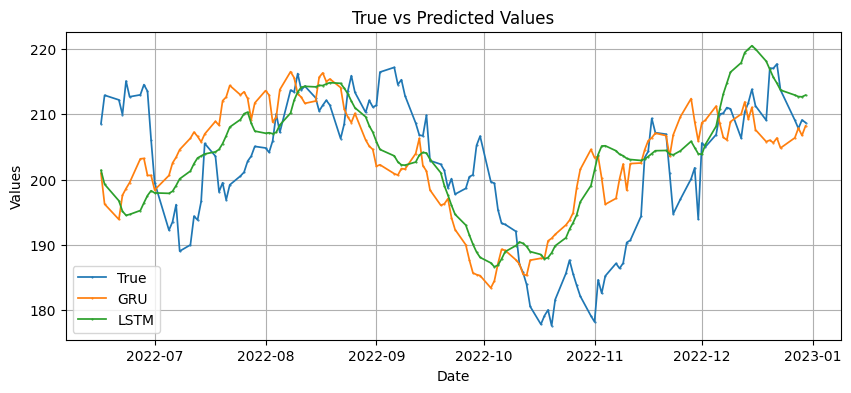

In [803]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

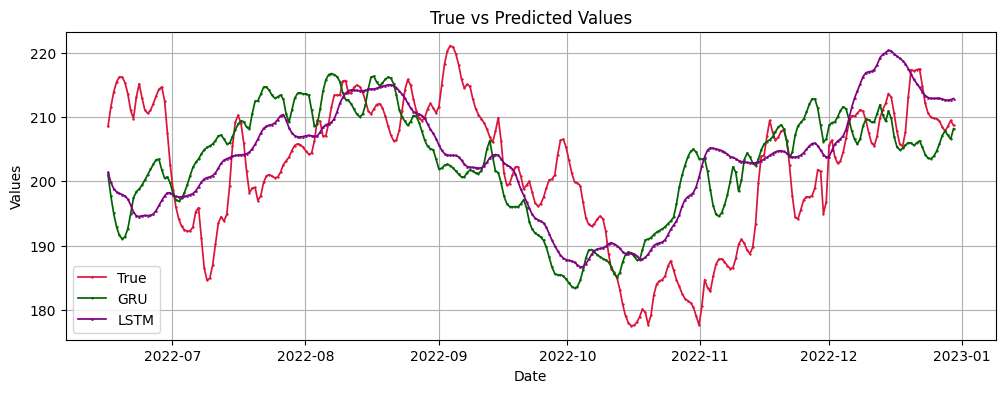

In [804]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## Broadcom Inc.

#### Company Data

In [248]:
company = "AVGO"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [249]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [250]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [251]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [252]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [253]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [254]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  319.320007  322.500000  317.320007  322.390015  284.935638   
1 2020-01-03  317.510010  320.000000  314.079987  314.190002  277.688232   
2 2020-01-06  310.850006  313.920013  309.630005  313.720001  277.272827   
3 2020-01-07  315.250000  316.579987  312.250000  312.640015  276.318298   
4 2020-01-08  312.980011  313.489990  308.410004  308.739990  272.871338   

    volume  
0  2032900  
1  2287000  
2  2078900  
3  1856500  
4  3197900

#### Indicators

In [255]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [256]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [257]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [258]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [259]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [260]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [261]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [262]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [263]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [264]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [265]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [266]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [267]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [268]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [269]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  319.320007  322.500000  317.320007  322.390015  284.935638   
1 2020-01-03  317.510010  320.000000  314.079987  314.190002  277.688232   
2 2020-01-06  310.850006  313.920013  309.630005  313.720001  277.272827   
3 2020-01-07  315.250000  316.579987  312.250000  312.640015  276.318298   
4 2020-01-08  312.980011  313.489990  308.410004  308.739990  272.871338   

    volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0  2032900  NaN   NaN  322.390015  ...       NaN          NaN      NaN   
1  2287000  NaN   NaN  318.132316  ...       NaN    -0.025764      NaN   
2  2078900  NaN   NaN  316.547014  ...       NaN    -0.001497      NaN   
3  1856500  NaN   NaN  315.454788  ...       NaN    -0.003448      NaN   
4  3197900  NaN   NaN  313.897599  ...       NaN    -0.012553      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN        0.124994         NaN         NaN         NaN  NaN  
2      NaN      NaN       -0.090993         NaN         NaN         NaN  NaN  
3      NaN      NaN       -0.106980         NaN         NaN         NaN  NaN  
4      NaN      NaN        0.722542         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [270]:
data = data.ffill().bfill()

#### Preprocessing

In [271]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [272]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [273]:
df_indicators

date       close   volume         ma7        ma21       26ema  \
0   2020-01-02  322.390015  2032900  311.022862  311.209526  322.390015   
1   2020-01-03  314.190002  2287000  311.022862  311.209526  318.132316   
2   2020-01-06  313.720001  2078900  311.022862  311.209526  316.547014   
3   2020-01-07  312.640015  1856500  311.022862  311.209526  315.454788   
4   2020-01-08  308.739990  3197900  311.022862  311.209526  313.897599   
..         ...         ...      ...         ...         ...         ...   
751 2022-12-23  552.429993  1376100  553.472857  544.917620  537.922073   
752 2022-12-27  553.539978  1667700  552.835711  546.042858  539.078955   
753 2022-12-28  544.890015  1541000  551.261431  547.122858  539.509404   
754 2022-12-29  557.809998  1817600  552.430001  548.857143  540.865003   
755 2022-12-30  559.130005  1437600  554.588571  549.242856  542.217966   

          12ema       MACD       20sd  upper_band  ...    close_60  \
0    322.390015   0.000000   6.772132  325.056267  ...  283.154336   
1    317.948341  -0.183975   6.772132  325.056267  ...  283.154336   
2    316.298019  -0.248995   6.772132  325.056267  ...  283.154336   
3    315.143330  -0.311458   6.772132  325.056267  ...  283.154336   
4    313.403566  -0.494033   6.772132  325.056267  ...  283.154336   
..          ...        ...        ...         ...  ...         ...   
751  550.747500  12.825427  16.221609  578.111219  ...  496.951665   
752  551.177112  12.098157  15.325046  577.884593  ...  498.777165   
753  550.209866  10.700463  14.090367  576.590235  ...  500.245665   
754  551.379117  10.514114  14.237523  577.223545  ...  501.544832   
755  552.571562  10.353595  14.421645  578.010788  ...  502.783665   

     Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  \
0      -0.025764  0.248776  0.287800  0.890629        0.124994    5.273541   
1      -0.025764  0.248776  0.287800  0.890629        0.124994    5.273541   
2      -0.001497  0.248776  0.287800  0.890629       -0.090993    5.273541   
3      -0.003448  0.248776  0.287800  0.890629       -0.106980    5.273541   
4      -0.012553  0.248776  0.287800  0.890629        0.722542    5.273541   
..           ...       ...       ...       ...             ...         ...   
751    -0.001194  0.309132  0.309687  0.384880       -0.500563    6.143998   
752     0.002007  0.288172  0.304062  0.383242        0.211903    5.924081   
753    -0.015750  0.256188  0.306700  0.381767       -0.075973    4.492064   
754     0.023434  0.289410  0.307769  0.371908        0.179494    4.600868   
755     0.002364  0.250424  0.297299  0.371558       -0.209067    4.680773   

     Volu30d_ff  Volu60d_ff        atr  
0      4.676984    4.773473   6.250713  
1      4.676984    4.773473   6.250713  
2      4.676984    4.773473   6.250713  
3      4.676984    4.773473   6.250713  
4      4.676984    4.773473   6.250713  
..          ...         ...        ...  
751   11.330654    8.928196  14.147143  
752   11.293105    8.892981  14.100712  
753   11.270214    8.877933  14.497140  
754   11.270391    8.872073  14.767853  
755   11.312543    8.852702  14.059283  

[756 rows x 27 columns]

In [274]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [275]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [276]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.744496  0.108031  0.753421  0.765639  0.766831  0.759920   
754 2022-12-29  0.770008  0.134505  0.755875  0.769730  0.770276  0.762569   
755 2022-12-30  0.772615  0.098135  0.760409  0.770640  0.773715  0.765270   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.676871  0.226360    0.689134  ...  0.706200     0.559032  0.109932   
754  0.673700  0.229607    0.690555  ...  0.709887     0.665211  0.127673   
755  0.670969  0.233670    0.692322  ...  0.713402     0.608115  0.106854   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.151204  0.286261        0.180981    0.156788    0.992101    0.938622   
754  0.152143  0.273775        0.254233    0.163362    0.992124    0.937454   
755  0.142950  0.273332        0.142817    0.168190    0.997633    0.933594   

          atr  
753  0.363751  
754  0.375181  
755  0.345265  

[3 rows x 27 columns]

In [277]:
df_time_series = df_normalized.set_index('date')

In [278]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [279]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.718311  0.131309  0.750864  0.813802  0.838880  0.768377   
2022-05-26  0.755889  0.340930  0.733614  0.812805  0.835642  0.767233   
2022-05-27  0.820304  0.317557  0.737428  0.813292  0.838785  0.777634   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.257997  0.437573    0.775915    0.805011  ...  0.955259   
2022-05-26  0.271081  0.440940    0.773427    0.801180  ...  0.953598   
2022-05-27  0.328160  0.443170    0.777122    0.803948  ...  0.953819   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.639848  0.250009  0.286802  0.320502        0.120176   
2022-05-26     0.697010  0.270235  0.296632  0.323933        0.554736   
2022-05-27     0.757655  0.303536  0.316007  0.344700        0.185146   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.274607    0.200101    0.315780  0.752654  
2022-05-26    0.414230    0.331807    0.409461  0.771653  
2022-05-27    0.403181    0.327131    0.409311  0.816798  

[3 rows x 26 columns]

In [280]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [281]:
time_steps = 14

In [282]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [283]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [284]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [285]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 11s 178ms/step - loss: 0.1040 - val_loss: 0.0446
Epoch 2/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0148 - val_loss: 0.0061
Epoch 3/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0060 - val_loss: 0.0119
Epoch 4/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0041 - val_loss: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0033 - val_loss: 0.0052
Epoch 6/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0032 - val_loss: 0.0050
Epoch 7/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 8/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 9/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 10/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 1

In [286]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 2s 10ms/step


#### L S T M

In [287]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [288]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 127ms/step - loss: 0.0782 - val_loss: 0.0637
Epoch 2/50
15/15 [==============================] - 0s 34ms/step - loss: 0.0087 - val_loss: 0.0144
Epoch 3/50
15/15 [==============================] - 1s 48ms/step - loss: 0.0066 - val_loss: 0.0287
Epoch 4/50
15/15 [==============================] - 1s 45ms/step - loss: 0.0050 - val_loss: 0.0235
Epoch 5/50
15/15 [==============================] - 1s 44ms/step - loss: 0.0043 - val_loss: 0.0177
Epoch 6/50
15/15 [==============================] - 1s 43ms/step - loss: 0.0045 - val_loss: 0.0214
Epoch 7/50
15/15 [==============================] - 1s 42ms/step - loss: 0.0045 - val_loss: 0.0160
Epoch 8/50
15/15 [==============================] - 1s 47ms/step - loss: 0.0045 - val_loss: 0.0113
Epoch 9/50
15/15 [==============================] - 1s 35ms/step - loss: 0.0036 - val_loss: 0.0091
Epoch 10/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0039 - val_loss: 0.0159
Epoch 11

In [289]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 2s 10ms/step


#### Initial Reports

In [290]:
true_val = X_test[:,0,0]

In [291]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.718311221
Example 2 ---> Value 0.755889402
Example 3 ---> Value 0.820303719

             L S T M            
Example 1 ---> Value 0.822711825
Example 2 ---> Value 0.817154050
Example 3 ---> Value 0.808418572

              G R U             
Example 1 ---> Value 0.741723001
Example 2 ---> Value 0.740795791
Example 3 ---> Value 0.714187920


#### Inverse Scaling

In [292]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [293]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [294]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [295]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 531.630004883
Example 2 ---> Value 550.659973145
Example 3 ---> Value 583.280029297

             L S T M            
Example 1 ---> Value 584.499511719
Example 2 ---> Value 581.684997559
Example 3 ---> Value 577.261230469

              G R U             
Example 1 ---> Value 543.485961914
Example 2 ---> Value 543.016418457
Example 3 ---> Value 529.541931152


In [296]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.718311  0.131309  0.750864  0.813802  0.838880  0.768377   
2022-05-26  0.755889  0.340930  0.733614  0.812805  0.835642  0.767233   
2022-05-27  0.820304  0.317557  0.737428  0.813292  0.838785  0.777634   
2022-05-31  0.814083  0.247763  0.747606  0.816184  0.841102  0.785337   
2022-06-01  0.801228  0.136123  0.756736  0.815877  0.842022  0.789586   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.257997  0.437573    0.775915    0.805011  ...  0.955259   
2022-05-26  0.271081  0.440940    0.773427    0.801180  ...  0.953598   
2022-05-27  0.328160  0.443170    0.777122    0.803948  ...  0.953819   
2022-05-31  0.370503  0.445035    0.777925    0.803993  ...  0.953069   
2022-06-01  0.396258  0.441580    0.776376    0.803849  ...  0.953207   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.639848  0.250009  0.286802  0.320502        0.120176   
2022-05-26     0.697010  0.270235  0.296632  0.323933        0.554736   
2022-05-27     0.757655  0.303536  0.316007  0.344700        0.185146   
2022-05-31     0.587036  0.302860  0.312589  0.339245        0.146710   
2022-06-01     0.571130  0.277102  0.310426  0.328011        0.091314   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.274607    0.200101    0.315780  0.752654  
2022-05-26    0.414230    0.331807    0.409461  0.771653  
2022-05-27    0.403181    0.327131    0.409311  0.816798  
2022-05-31    0.396979    0.325879    0.386643  0.764928  
2022-06-01    0.386919    0.337314    0.385417  0.776026  

[5 rows x 26 columns]

In [297]:
test.reset_index(inplace=True)

In [298]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.718311  0.131309  0.750864  0.813802  0.838880  0.768377   
1 2022-05-26  0.755889  0.340930  0.733614  0.812805  0.835642  0.767233   
2 2022-05-27  0.820304  0.317557  0.737428  0.813292  0.838785  0.777634   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.257997  0.437573    0.775915  ...  0.955259     0.639848  0.250009   
1  0.271081  0.440940    0.773427  ...  0.953598     0.697010  0.270235   
2  0.328160  0.443170    0.777122  ...  0.953819     0.757655  0.303536   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.286802  0.320502        0.120176    0.274607    0.200101    0.315780   
1  0.296632  0.323933        0.554736    0.414230    0.331807    0.409461   
2  0.316007  0.344700        0.185146    0.403181    0.327131    0.409311   

        atr  
0  0.752654  
1  0.771653  
2  0.816798  

[3 rows x 27 columns]

In [299]:
results = pd.DataFrame()

In [300]:
results['date'] = test['date'].tail(len(X_test))

In [301]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [302]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [303]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  522.210022  544.833374  531.138062
143 2022-12-19  521.390015  542.284058  531.160706
144 2022-12-20  551.030029  543.893921  531.546387
145 2022-12-21  550.750000  542.537964  531.187744
146 2022-12-22  540.799988  546.161377  531.031677
147 2022-12-23  530.640015  545.827698  530.628845
148 2022-12-27  525.820007  547.889648  530.553223
149 2022-12-28  518.500000  548.972717  530.691895
150 2022-12-29  531.080017  547.442505  530.726440
151 2022-12-30  544.719971  548.650513  530.953003

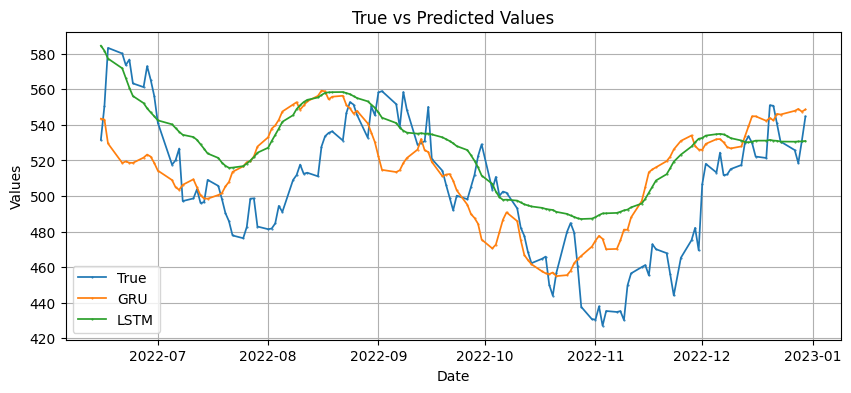

In [304]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

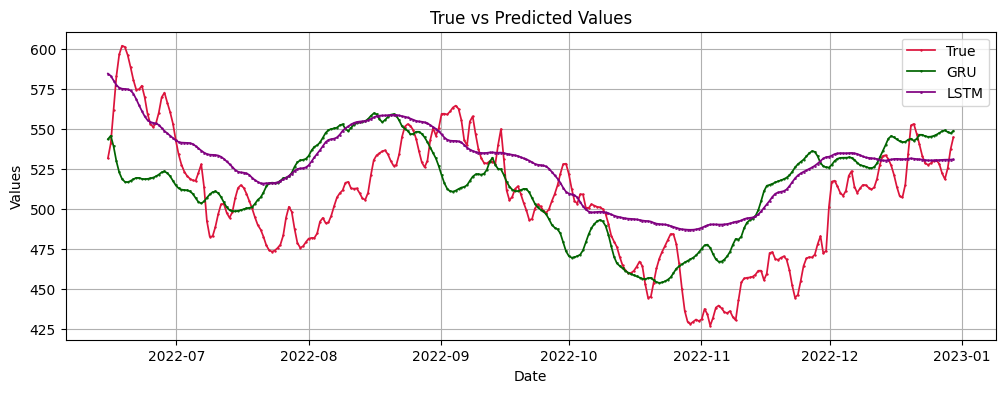

In [305]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## Johnson & Johnson

#### Company Data

In [306]:
company = "JNJ"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [307]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [308]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [309]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [310]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [311]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [312]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  145.869995  146.020004  145.080002  145.970001  131.086914   
1 2020-01-03  143.500000  145.369995  143.000000  144.279999  129.569214   
2 2020-01-06  144.000000  144.199997  142.850006  144.100006  129.407578   
3 2020-01-07  144.009995  145.449997  141.380005  144.979996  130.197861   
4 2020-01-08  144.869995  145.979996  143.699997  144.960007  130.179871   

    volume  
0  5777000  
1  5752400  
2  7731300  
3  7382900  
4  6605800

#### Indicators

In [313]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [314]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [315]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [316]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [317]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [318]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [319]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [320]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [321]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [322]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [323]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [324]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [325]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [326]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [327]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  145.869995  146.020004  145.080002  145.970001  131.086914   
1 2020-01-03  143.500000  145.369995  143.000000  144.279999  129.569214   
2 2020-01-06  144.000000  144.199997  142.850006  144.100006  129.407578   
3 2020-01-07  144.009995  145.449997  141.380005  144.979996  130.197861   
4 2020-01-08  144.869995  145.979996  143.699997  144.960007  130.179871   

    volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0  5777000  NaN   NaN  145.970001  ...       NaN          NaN      NaN   
1  5752400  NaN   NaN  145.092500  ...       NaN    -0.011645      NaN   
2  7731300  NaN   NaN  144.735907  ...       NaN    -0.001248      NaN   
3  7382900  NaN   NaN  144.804143  ...       NaN     0.006088      NaN   
4  6605800  NaN   NaN  144.840289  ...       NaN    -0.000138      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN       -0.004258         NaN         NaN         NaN  NaN  
2      NaN      NaN        0.344013         NaN         NaN         NaN  NaN  
3      NaN      NaN       -0.045064         NaN         NaN         NaN  NaN  
4      NaN      NaN       -0.105257         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [328]:
data = data.ffill().bfill()

#### Preprocessing

In [329]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [330]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [331]:
df_indicators

date       close   volume         ma7        ma21       26ema  \
0   2020-01-02  145.970001  5777000  144.962858  147.320476  145.970001   
1   2020-01-03  144.279999  5752400  144.962858  147.320476  145.092500   
2   2020-01-06  144.100006  7731300  144.962858  147.320476  144.735907   
3   2020-01-07  144.979996  7382900  144.962858  147.320476  144.804143   
4   2020-01-08  144.960007  6605800  144.962858  147.320476  144.840289   
..         ...         ...      ...         ...         ...         ...   
751 2022-12-23  177.479996  3683400  176.642855  177.360952  176.269877   
752 2022-12-27  177.429993  3067300  176.634282  177.369999  176.355811   
753 2022-12-28  176.660004  2645400  176.775711  177.338095  176.378344   
754 2022-12-29  177.559998  2828800  177.072854  177.408095  176.465874   
755 2022-12-30  176.649994  4216600  177.212854  177.343809  176.479512   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0    145.970001  0.000000  2.081090  151.405180  ...  142.201166    -0.011645   
1    145.054583 -0.037917  2.081090  151.405180  ...  142.201166    -0.011645   
2    144.682012 -0.053895  2.081090  151.405180  ...  142.201166    -0.001248   
3    144.776074 -0.028070  2.081090  151.405180  ...  142.201166     0.006088   
4    144.826048 -0.014241  2.081090  151.405180  ...  142.201166    -0.000138   
..          ...       ...       ...         ...  ...         ...          ...   
751  177.052042  0.782165  1.286150  179.939299  ...  172.215166     0.002539   
752  177.110188  0.754377  1.286193  179.944385  ...  172.449666    -0.000282   
753  177.040929  0.662585  1.262385  179.925270  ...  172.674000    -0.004349   
754  177.120786  0.654912  1.255201  179.888902  ...  172.873000     0.005082   
755  177.048356  0.568844  1.222458  179.718915  ...  173.065333    -0.005138   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.090456  0.101322  0.512935       -0.004258    4.179474    3.445555   
1    0.090456  0.101322  0.512935       -0.004258    4.179474    3.445555   
2    0.090456  0.101322  0.512935        0.344013    4.179474    3.445555   
3    0.090456  0.101322  0.512935       -0.045064    4.179474    3.445555   
4    0.090456  0.101322  0.512935       -0.105257    4.179474    3.445555   
..        ...       ...       ...             ...         ...         ...   
751  0.131658  0.147360  0.152454       -0.354819    9.883239    8.000717   
752  0.116799  0.114618  0.151485       -0.167264    9.989457    7.969124   
753  0.109374  0.107789  0.151866       -0.137548    9.019460    7.870497   
754  0.112130  0.108340  0.149500        0.069328    9.024765    7.799203   
755  0.095666  0.108587  0.149808        0.490597    9.257804    7.767042   

     Volu60d_ff       atr  
0      3.688946  1.943570  
1      3.688946  1.943570  
2      3.688946  1.943570  
3      3.688946  1.943570  
4      3.688946  1.943570  
..          ...       ...  
751    6.359264  2.308571  
752    6.358241  2.114999  
753    6.367497  2.116428  
754    6.330715  2.152856  
755    6.355611  2.162857  

[756 rows x 27 columns]

In [332]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [333]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [334]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.875117  0.026016  0.891462  0.923777  0.924328  0.905956   
754 2022-12-29  0.887138  0.035011  0.896204  0.925122  0.926134  0.907367   
755 2022-12-30  0.874983  0.103070  0.898438  0.923886  0.926415  0.906087   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.605883  0.030294    0.848305  ...  0.842904     0.467739  0.063530   
754  0.605253  0.029620    0.847460  ...  0.848126     0.529488  0.066448   
755  0.598191  0.026548    0.843508  ...  0.853174     0.462572  0.049019   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.025739  0.094113        0.115870    0.371374    0.450068    0.382473   
754  0.026574  0.088731        0.158827    0.371633    0.443234    0.377221   
755  0.026947  0.089432        0.246300    0.383036    0.440151    0.380775   

          atr  
753  0.079027  
754  0.083741  
755  0.085035  

[3 rows x 27 columns]

In [335]:
df_time_series = df_normalized.set_index('date')

In [336]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [337]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.914652  0.217939  0.910316  0.943205  0.966497  0.929407   
2022-05-26  0.912515  0.234550  0.911775  0.940789  0.968082  0.932376   
2022-05-27  0.934286  0.183350  0.924518  0.938621  0.972039  0.939320   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.547020  0.117970    0.909436    0.949748  ...  0.965715   
2022-05-26  0.554501  0.084732    0.888318    0.957438  ...  0.971585   
2022-05-27  0.570997  0.089393    0.891360    0.956412  ...  0.977100   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.431648  0.149204  0.158094  0.170408        0.148930   
2022-05-26     0.490381  0.144055  0.157473  0.167391        0.155154   
2022-05-27     0.555419  0.144093  0.159630  0.164286        0.113003   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.097007    0.157929    0.213690  0.193178  
2022-05-26    0.095105    0.157219    0.209622  0.195212  
2022-05-27    0.097346    0.159945    0.211712  0.185599  

[3 rows x 26 columns]

In [338]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [339]:
time_steps = 14

In [340]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [341]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [342]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [343]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 118ms/step - loss: 0.0871 - val_loss: 0.0447
Epoch 2/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0169 - val_loss: 0.0036
Epoch 3/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 4/50
15/15 [==============================] - 0s 33ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 5/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 6/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0056 - val_loss: 0.0042
Epoch 7/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 8/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0043 - val_loss: 0.0057
Epoch 9/50
15/15 [==============================] - 1s 35ms/step - loss: 0.0043 - val_loss: 0.0075
Epoch 10/50
15/15 [==============================] - 1s 46ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 11

In [344]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 8ms/step


#### L S T M

In [345]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [346]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 10s 151ms/step - loss: 0.0488 - val_loss: 0.0567
Epoch 2/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0148 - val_loss: 0.0159
Epoch 3/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0104 - val_loss: 0.0086
Epoch 4/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 5/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0074 - val_loss: 0.0058
Epoch 6/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0076 - val_loss: 0.0124
Epoch 7/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 8/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0072 - val_loss: 0.0033
Epoch 9/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 10/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0068 - val_loss: 0.0074
Epoch 1

In [347]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 2s 11ms/step


#### Initial Reports

In [348]:
true_val = X_test[:,0,0]

In [349]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.914652066
Example 2 ---> Value 0.912515183
Example 3 ---> Value 0.934286116

             L S T M            
Example 1 ---> Value 0.766131461
Example 2 ---> Value 0.746576428
Example 3 ---> Value 0.730940104

              G R U             
Example 1 ---> Value 0.791877031
Example 2 ---> Value 0.797872782
Example 3 ---> Value 0.802702427


#### Inverse Scaling

In [350]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [351]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [352]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [353]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 179.619995117
Example 2 ---> Value 179.460006714
Example 3 ---> Value 181.089996338

             L S T M            
Example 1 ---> Value 168.500259399
Example 2 ---> Value 167.036178589
Example 3 ---> Value 165.865478516

              G R U             
Example 1 ---> Value 170.427825928
Example 2 ---> Value 170.876739502
Example 3 ---> Value 171.238327026


In [354]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.914652  0.217939  0.910316  0.943205  0.966497  0.929407   
2022-05-26  0.912515  0.234550  0.911775  0.940789  0.968082  0.932376   
2022-05-27  0.934286  0.183350  0.924518  0.938621  0.972039  0.939320   
2022-05-31  0.913450  0.700137  0.937262  0.937769  0.973321  0.940954   
2022-06-01  0.889141  0.150091  0.938926  0.936918  0.971726  0.937389   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.547020  0.117970    0.909436    0.949748  ...  0.965715   
2022-05-26  0.554501  0.084732    0.888318    0.957438  ...  0.971585   
2022-05-27  0.570997  0.089393    0.891360    0.956412  ...  0.977100   
2022-05-31  0.573489  0.091860    0.893617    0.956289  ...  0.981495   
2022-06-01  0.563278  0.091895    0.892960    0.955840  ...  0.983901   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.431648  0.149204  0.158094  0.170408        0.148930   
2022-05-26     0.490381  0.144055  0.157473  0.167391        0.155154   
2022-05-27     0.555419  0.144093  0.159630  0.164286        0.113003   
2022-05-31     0.439566  0.150103  0.156784  0.166179        0.518237   
2022-06-01     0.429499  0.156914  0.127331  0.163185        0.002348   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.097007    0.157929    0.213690  0.193178  
2022-05-26    0.095105    0.157219    0.209622  0.195212  
2022-05-27    0.097346    0.159945    0.211712  0.185599  
2022-05-31    0.391473    0.371461    0.371718  0.217025  
2022-06-01    0.440093    0.314152    0.368022  0.230798  

[5 rows x 26 columns]

In [355]:
test.reset_index(inplace=True)

In [356]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.914652  0.217939  0.910316  0.943205  0.966497  0.929407   
1 2022-05-26  0.912515  0.234550  0.911775  0.940789  0.968082  0.932376   
2 2022-05-27  0.934286  0.183350  0.924518  0.938621  0.972039  0.939320   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.547020  0.117970    0.909436  ...  0.965715     0.431648  0.149204   
1  0.554501  0.084732    0.888318  ...  0.971585     0.490381  0.144055   
2  0.570997  0.089393    0.891360  ...  0.977100     0.555419  0.144093   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.158094  0.170408        0.148930    0.097007    0.157929    0.213690   
1  0.157473  0.167391        0.155154    0.095105    0.157219    0.209622   
2  0.159630  0.164286        0.113003    0.097346    0.159945    0.211712   

        atr  
0  0.193178  
1  0.195212  
2  0.185599  

[3 rows x 27 columns]

In [357]:
results = pd.DataFrame()

In [358]:
results['date'] = test['date'].tail(len(X_test))

In [359]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [360]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [361]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  177.330002  175.973312  174.188751
143 2022-12-19  176.089996  173.544296  173.681427
144 2022-12-20  178.000000  173.884247  173.186523
145 2022-12-21  178.740005  174.537262  172.827515
146 2022-12-22  178.880005  176.024307  172.681244
147 2022-12-23  178.779999  176.218231  172.626099
148 2022-12-27  176.100006  176.745377  172.674942
149 2022-12-28  177.169998  177.706772  172.892715
150 2022-12-29  177.199997  177.502777  173.057159
151 2022-12-30  175.740005  177.471222  173.075775

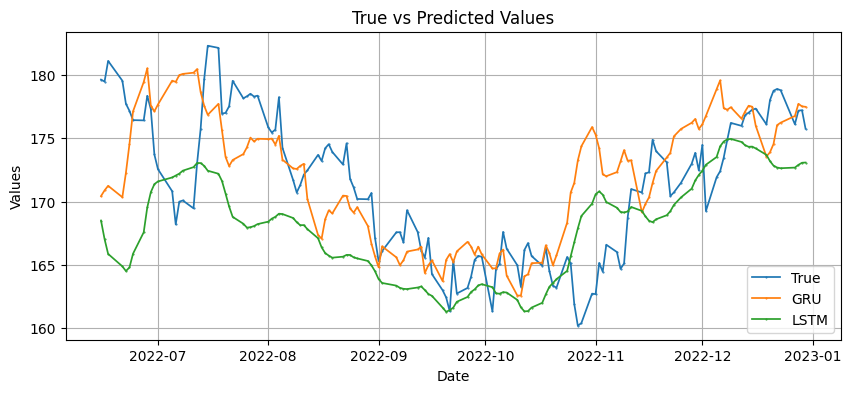

In [362]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

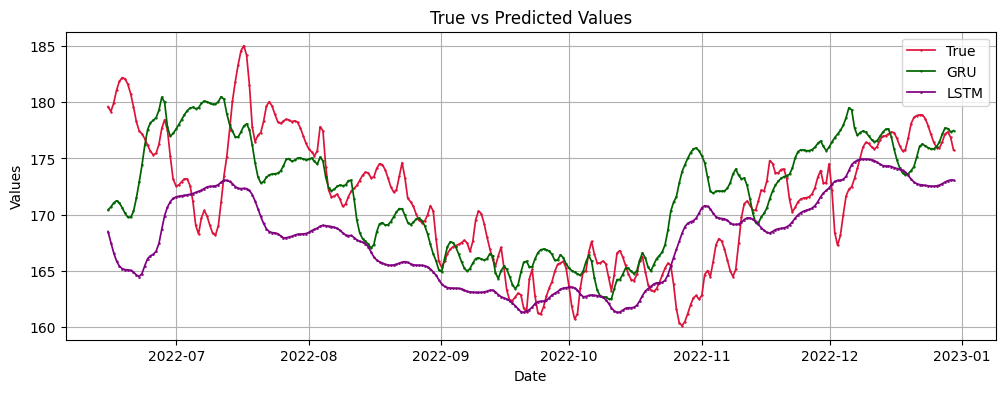

In [363]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## Mastercard Inc.

#### Company Data

In [364]:
company = "MA"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [365]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [366]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [367]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [368]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [369]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [370]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  300.459991  303.529999  299.500000  303.390015  296.730408   
1 2020-01-03  299.459991  302.420013  298.600006  300.429993  293.835388   
2 2020-01-06  297.359985  301.329987  296.019989  301.230011  294.617798   
3 2020-01-07  301.739990  303.380005  299.880005  300.209991  293.620239   
4 2020-01-08  300.779999  306.950012  300.510010  305.100006  298.801056   

    volume  
0  3272400  
1  2501300  
2  3307200  
3  3182000  
4  3224400

#### Indicators

In [371]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [372]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [373]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [374]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [375]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [376]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [377]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [378]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [379]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [380]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [381]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [382]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [383]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [384]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [385]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  300.459991  303.529999  299.500000  303.390015  296.730408   
1 2020-01-03  299.459991  302.420013  298.600006  300.429993  293.835388   
2 2020-01-06  297.359985  301.329987  296.019989  301.230011  294.617798   
3 2020-01-07  301.739990  303.380005  299.880005  300.209991  293.620239   
4 2020-01-08  300.779999  306.950012  300.510010  305.100006  298.801056   

    volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0  3272400  NaN   NaN  303.390015  ...       NaN          NaN      NaN   
1  2501300  NaN   NaN  301.853080  ...       NaN    -0.009804      NaN   
2  3307200  NaN   NaN  301.629217  ...       NaN     0.002659      NaN   
3  3182000  NaN   NaN  301.232464  ...       NaN    -0.003392      NaN   
4  3224400  NaN   NaN  302.129363  ...       NaN     0.016157      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN       -0.235637         NaN         NaN         NaN  NaN  
2      NaN      NaN        0.322192         NaN         NaN         NaN  NaN  
3      NaN      NaN       -0.037857         NaN         NaN         NaN  NaN  
4      NaN      NaN        0.013325         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [386]:
data = data.ffill().bfill()

#### Preprocessing

In [387]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [388]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [389]:
df_indicators

date       close   volume         ma7        ma21       26ema  \
0   2020-01-02  303.390015  3272400  304.375719  314.587620  303.390015   
1   2020-01-03  300.429993  2501300  304.375719  314.587620  301.853080   
2   2020-01-06  301.230011  3307200  304.375719  314.587620  301.629217   
3   2020-01-07  300.209991  3182000  304.375719  314.587620  301.232464   
4   2020-01-08  305.100006  3224400  304.375719  314.587620  302.129363   
..         ...         ...      ...         ...         ...         ...   
751 2022-12-23  343.600006  1914500  343.872859  349.869049  344.517189   
752 2022-12-27  346.160004  1637700  343.860003  349.624763  344.638879   
753 2022-12-28  341.950012  1854100  343.304291  349.499050  344.439704   
754 2022-12-29  348.209991  1459800  344.297145  349.740954  344.718984   
755 2022-12-30  347.730011  1617600  344.980002  349.328097  344.942023   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0    303.390015  0.000000  8.815794  332.151589  ...  298.979502    -0.009804   
1    301.786669 -0.066411  8.815794  332.151589  ...  298.979502    -0.009804   
2    301.569406 -0.059812  8.815794  332.151589  ...  298.979502     0.002659   
3    301.140292 -0.092172  8.815794  332.151589  ...  298.979502    -0.003392   
4    302.216132  0.086769  8.815794  332.151589  ...  298.979502     0.016157   
..          ...       ...       ...         ...  ...         ...          ...   
751  346.384710  1.867521  6.689393  363.176786  ...  327.284168     0.006072   
752  346.350140  1.711261  6.634043  363.144587  ...  328.314502     0.007423   
753  345.673197  1.233494  6.702099  363.221699  ...  329.172335    -0.012237   
754  346.063473  1.344489  6.526648  362.461297  ...  329.954669     0.018141   
755  346.319864  1.377840  5.955283  360.665069  ...  330.680169    -0.001379   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.181199  0.194210  0.725100       -0.235637    3.895399    4.254093   
1    0.181199  0.194210  0.725100       -0.235637    3.895399    4.254093   
2    0.181199  0.194210  0.725100        0.322192    3.895399    4.254093   
3    0.181199  0.194210  0.725100       -0.037857    3.895399    4.254093   
4    0.181199  0.194210  0.725100        0.013325    3.895399    4.254093   
..        ...       ...       ...             ...         ...         ...   
751  0.245908  0.230161  0.316355       -0.158868    7.129491    7.762914   
752  0.199616  0.230492  0.315561       -0.144581    7.203102    7.783313   
753  0.204383  0.233510  0.314848        0.132137    7.116328    7.677608   
754  0.233044  0.236796  0.308634       -0.212664    7.161204    7.698883   
755  0.166075  0.236729  0.308354        0.108097    7.170615    7.677575   

     Volu60d_ff       atr  
0      4.408780  4.960007  
1      4.408780  4.960007  
2      4.408780  4.960007  
3      4.408780  4.960007  
4      4.408780  4.960007  
..          ...       ...  
751    6.452326  7.939292  
752    6.463879  7.465007  
753    6.427319  7.561436  
754    6.419928  7.762863  
755    6.385361  7.704291  

[756 rows x 27 columns]

In [390]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [391]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [392]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.716723  0.064577  0.724056  0.764437  0.710369  0.724023   
754 2022-12-29  0.749082  0.036587  0.730172  0.766190  0.712614  0.726744   
755 2022-12-30  0.746601  0.047788  0.734379  0.763198  0.714408  0.728531   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.710694  0.124081    0.667601  ...  0.601411     0.427473  0.089189   
754  0.713596  0.118206    0.661681  ...  0.608637     0.532302  0.109189   
755  0.714468  0.099075    0.647697  ...  0.615339     0.464939  0.062457   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.090284  0.198494        0.238113    0.361439    0.536097    0.400952   
754  0.093791  0.189014        0.134637    0.364471    0.538252    0.399946   
755  0.093720  0.188587        0.230899    0.365107    0.536093    0.395238   

          atr  
753  0.133457  
754  0.143487  
755  0.140571  

[3 rows x 27 columns]

In [393]:
df_time_series = df_normalized.set_index('date')

In [394]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [395]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.731248  0.148292  0.701095  0.726532  0.703010  0.684706   
2022-05-26  0.757767  0.132959  0.710802  0.722502  0.706801  0.695277   
2022-05-27  0.798553  0.121693  0.730058  0.715239  0.715010  0.712683   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.587151  0.431898     0.76080    0.657371  ...  0.760595   
2022-05-26  0.614472  0.357073     0.71474    0.674816  ...  0.761488   
2022-05-27  0.653063  0.343310     0.70616    0.677945  ...  0.764073   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.510680  0.186846  0.295383  0.298456        0.253746   
2022-05-26     0.520669  0.175248  0.289912  0.300271        0.177089   
2022-05-27     0.546651  0.158327  0.294826  0.303520        0.181554   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.208223    0.268112    0.356884  0.371558  
2022-05-26    0.207681    0.262135    0.355641  0.356975  
2022-05-27    0.206541    0.262544    0.353065  0.306004  

[3 rows x 26 columns]

In [396]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [397]:
time_steps = 14

In [398]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [399]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [400]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [401]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 10s 166ms/step - loss: 0.1356 - val_loss: 0.0659
Epoch 2/50
15/15 [==============================] - 1s 49ms/step - loss: 0.0246 - val_loss: 0.0061
Epoch 3/50
15/15 [==============================] - 1s 46ms/step - loss: 0.0116 - val_loss: 0.0052
Epoch 4/50
15/15 [==============================] - 1s 48ms/step - loss: 0.0099 - val_loss: 0.0082
Epoch 5/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 6/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0081 - val_loss: 0.0048
Epoch 7/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0075 - val_loss: 0.0044
Epoch 8/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 9/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0067 - val_loss: 0.0049
Epoch 10/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0062 - val_loss: 0.0042
Epoch 1

In [402]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### L S T M

In [403]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [404]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 121ms/step - loss: 0.0770 - val_loss: 0.0381
Epoch 2/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0172 - val_loss: 0.0125
Epoch 3/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0154 - val_loss: 0.0090
Epoch 4/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0127 - val_loss: 0.0077
Epoch 5/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0122 - val_loss: 0.0113
Epoch 6/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0104 - val_loss: 0.0147
Epoch 7/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0104 - val_loss: 0.0097
Epoch 8/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0099 - val_loss: 0.0081
Epoch 9/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0100 - val_loss: 0.0175
Epoch 10/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0113 - val_loss: 0.0078
Epoch 11

In [405]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### Initial Reports

In [406]:
true_val = X_test[:,0,0]

In [407]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.731248431
Example 2 ---> Value 0.757766937
Example 3 ---> Value 0.798552588

             L S T M            
Example 1 ---> Value 0.758870542
Example 2 ---> Value 0.745554686
Example 3 ---> Value 0.719885468

              G R U             
Example 1 ---> Value 0.643573046
Example 2 ---> Value 0.659429073
Example 3 ---> Value 0.593042970


#### Inverse Scaling

In [408]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [409]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [410]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [411]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 344.760009766
Example 2 ---> Value 349.890014648
Example 3 ---> Value 357.779998779

             L S T M            
Example 1 ---> Value 350.103515625
Example 2 ---> Value 347.527557373
Example 3 ---> Value 342.561828613

              G R U             
Example 1 ---> Value 327.799194336
Example 2 ---> Value 330.866546631
Example 3 ---> Value 318.024169922


In [412]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.731248  0.148292  0.701095  0.726532  0.703010  0.684706   
2022-05-26  0.757767  0.132959  0.710802  0.722502  0.706801  0.695277   
2022-05-27  0.798553  0.121693  0.730058  0.715239  0.715010  0.712683   
2022-05-31  0.799018  0.207949  0.752631  0.713338  0.722665  0.727507   
2022-06-01  0.794831  0.088421  0.771007  0.712655  0.729270  0.739182   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.587151  0.431898    0.760800    0.657371  ...  0.760595   
2022-05-26  0.614472  0.357073    0.714740    0.674816  ...  0.761488   
2022-05-27  0.653063  0.343310    0.706160    0.677945  ...  0.764073   
2022-05-31  0.683776  0.340686    0.704484    0.678512  ...  0.768247   
2022-06-01  0.706088  0.339138    0.703480    0.678835  ...  0.775042   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.510680  0.186846  0.295383  0.298456        0.253746   
2022-05-26     0.520669  0.175248  0.289912  0.300271        0.177089   
2022-05-27     0.546651  0.158327  0.294826  0.303520        0.181554   
2022-05-31     0.470567  0.150699  0.294735  0.295028        0.335615   
2022-06-01     0.461880  0.138872  0.290444  0.266255        0.068014   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.208223    0.268112    0.356884  0.371558  
2022-05-26    0.207681    0.262135    0.355641  0.356975  
2022-05-27    0.206541    0.262544    0.353065  0.306004  
2022-05-31    0.194464    0.255715    0.360084  0.303158  
2022-06-01    0.224284    0.248858    0.362773  0.292985  

[5 rows x 26 columns]

In [413]:
test.reset_index(inplace=True)

In [414]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.731248  0.148292  0.701095  0.726532  0.703010  0.684706   
1 2022-05-26  0.757767  0.132959  0.710802  0.722502  0.706801  0.695277   
2 2022-05-27  0.798553  0.121693  0.730058  0.715239  0.715010  0.712683   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.587151  0.431898     0.76080  ...  0.760595     0.510680  0.186846   
1  0.614472  0.357073     0.71474  ...  0.761488     0.520669  0.175248   
2  0.653063  0.343310     0.70616  ...  0.764073     0.546651  0.158327   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.295383  0.298456        0.253746    0.208223    0.268112    0.356884   
1  0.289912  0.300271        0.177089    0.207681    0.262135    0.355641   
2  0.294826  0.303520        0.181554    0.206541    0.262544    0.353065   

        atr  
0  0.371558  
1  0.356975  
2  0.306004  

[3 rows x 27 columns]

In [415]:
results = pd.DataFrame()

In [416]:
results['date'] = test['date'].tail(len(X_test))

In [417]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [418]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [419]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  344.589996  346.603210  353.418945
143 2022-12-19  343.130005  343.481689  348.625854
144 2022-12-20  356.399994  342.785248  345.481354
145 2022-12-21  360.799988  343.271606  344.265594
146 2022-12-22  360.059998  344.020386  344.150146
147 2022-12-23  356.089996  341.600922  343.932800
148 2022-12-27  347.529999  343.920227  344.845825
149 2022-12-28  347.420013  347.564087  346.962219
150 2022-12-29  351.170013  345.276672  348.609375
151 2022-12-30  348.829987  348.292206  350.722412

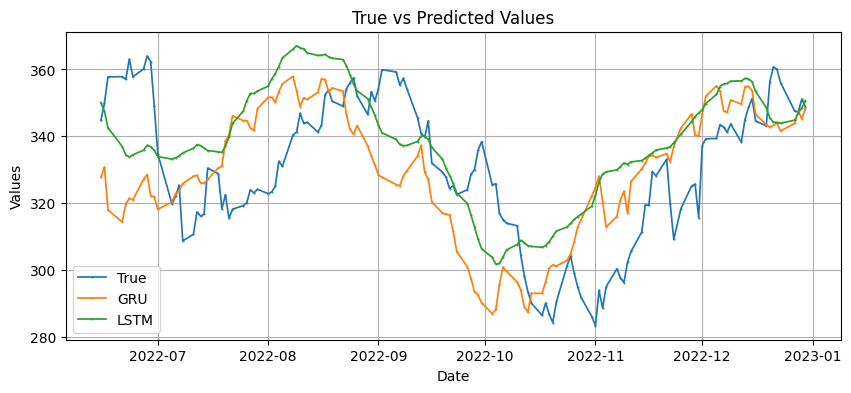

In [420]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

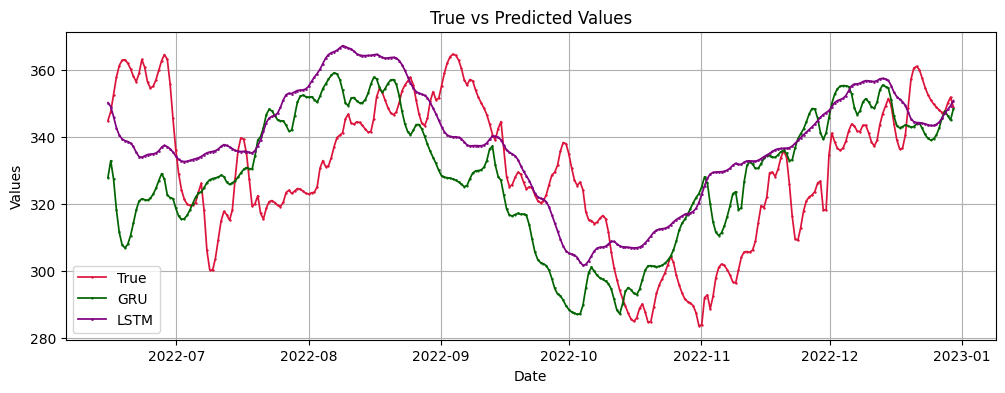

In [421]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## Home Depot Inc.

#### Company Data

In [422]:
company = "HD"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [423]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [424]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [425]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [426]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [427]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [428]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  219.080002  219.759995  217.839996  219.660004  200.835205   
1 2020-01-03  217.139999  219.679993  216.750000  218.929993  200.167755   
2 2020-01-06  216.490005  220.000000  216.399994  219.960007  201.109497   
3 2020-01-07  219.500000  220.559998  216.899994  218.520004  199.792908   
4 2020-01-08  218.800003  222.970001  218.669998  221.789993  202.782654   

    volume  
0  3935700  
1  3423200  
2  5682800  
3  5685400  
4  4916200

#### Indicators

In [429]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [430]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [431]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [432]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [433]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [434]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [435]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [436]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [437]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [438]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [439]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [440]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [441]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [442]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [443]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  219.080002  219.759995  217.839996  219.660004  200.835205   
1 2020-01-03  217.139999  219.679993  216.750000  218.929993  200.167755   
2 2020-01-06  216.490005  220.000000  216.399994  219.960007  201.109497   
3 2020-01-07  219.500000  220.559998  216.899994  218.520004  199.792908   
4 2020-01-08  218.800003  222.970001  218.669998  221.789993  202.782654   

    volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0  3935700  NaN   NaN  219.660004  ...       NaN          NaN      NaN   
1  3423200  NaN   NaN  219.280959  ...       NaN    -0.003329      NaN   
2  5682800  NaN   NaN  219.524935  ...       NaN     0.004694      NaN   
3  5685400  NaN   NaN  219.244000  ...       NaN    -0.006568      NaN   
4  4916200  NaN   NaN  219.834426  ...       NaN     0.014853      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN       -0.130218         NaN         NaN         NaN  NaN  
2      NaN      NaN        0.660084         NaN         NaN         NaN  NaN  
3      NaN      NaN        0.000458         NaN         NaN         NaN  NaN  
4      NaN      NaN       -0.135294         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [444]:
data = data.ffill().bfill()

#### Preprocessing

In [445]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [446]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [447]:
df_indicators

date       close   volume         ma7        ma21       26ema  \
0   2020-01-02  219.660004  3935700  221.181429  227.200000  219.660004   
1   2020-01-03  218.929993  3423200  221.181429  227.200000  219.280959   
2   2020-01-06  219.960007  5682800  221.181429  227.200000  219.524935   
3   2020-01-07  218.520004  5685400  221.181429  227.200000  219.244000   
4   2020-01-08  221.789993  4916200  221.181429  227.200000  219.834426   
..         ...         ...      ...         ...         ...         ...   
751 2022-12-23  318.730011  2064900  319.617140  322.580000  318.036105   
752 2022-12-27  319.549988  1610200  318.467137  322.254761  318.148244   
753 2022-12-28  315.730011  1568200  317.379996  322.102856  317.969116   
754 2022-12-29  320.410004  1559100  317.819999  322.314761  318.149922   
755 2022-12-30  315.859985  2581600  317.965711  321.927618  317.980298   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0    219.660004  0.000000  5.754522  238.664044  ...  220.463667    -0.003329   
1    219.264581 -0.016378  5.754522  238.664044  ...  220.463667    -0.003329   
2    219.536006  0.011071  5.754522  238.664044  ...  220.463667     0.004694   
3    219.215294 -0.028706  5.754522  238.664044  ...  220.463667    -0.006568   
4    219.914830  0.080404  5.754522  238.664044  ...  220.463667     0.014853   
..          ...       ...       ...         ...  ...         ...          ...   
751  320.645750  2.609645  5.555584  333.501168  ...  303.267501     0.008223   
752  320.477171  2.328926  5.536629  333.494755  ...  303.994334     0.002569   
753  319.746839  1.777723  5.550975  333.511949  ...  304.528167    -0.012026   
754  319.848864  1.698941  5.555064  333.341127  ...  305.042334     0.014714   
755  319.235190  1.254893  5.606418  332.883335  ...  305.475834    -0.014302   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.150844  0.145520  0.780785       -0.130218    5.484981    4.978932   
1    0.150844  0.145520  0.780785       -0.130218    5.484981    4.978932   
2    0.150844  0.145520  0.780785        0.660084    5.484981    4.978932   
3    0.150844  0.145520  0.780785        0.000458    5.484981    4.978932   
4    0.150844  0.145520  0.780785       -0.135294    5.484981    4.978932   
..        ...       ...       ...             ...         ...         ...   
751  0.238229  0.242270  0.311015       -0.326165    6.725001   11.227457   
752  0.200349  0.240636  0.310187       -0.220204    6.636488   11.183260   
753  0.179060  0.230672  0.307029       -0.026084    6.540519   11.174092   
754  0.203596  0.229862  0.305763       -0.005803    6.469739   11.124080   
755  0.197939  0.232453  0.307513        0.655827    7.304642   11.137974   

     Volu60d_ff       atr  
0      4.482049  3.171429  
1      4.482049  3.171429  
2      4.482049  3.171429  
3      4.482049  3.171429  
4      4.482049  3.171429  
..          ...       ...  
751    8.835888  8.236426  
752    8.857066  8.017140  
753    8.833533  7.837854  
754    8.834332  7.847137  
755    8.885664  8.052852  

[756 rows x 27 columns]

In [448]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [449]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [450]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.619551  0.025420  0.616490  0.622532  0.594904  0.608612   
754 2022-12-29  0.637276  0.024932  0.618270  0.623473  0.595766  0.609063   
755 2022-12-30  0.620043  0.079731  0.618859  0.621754  0.594957  0.606351   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.627268  0.099241    0.551732  ...  0.523471     0.596845  0.060791   
754  0.624963  0.099384    0.550964  ...  0.526256     0.673374  0.075715   
755  0.611973  0.101175    0.548907  ...  0.528604     0.590330  0.072274   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.112226  0.240963        0.178218    0.265189    0.914912    0.938947   
754  0.111428  0.239161        0.183042    0.261066    0.909411    0.939089   
755  0.113978  0.241653        0.340405    0.309709    0.910939    0.948227   

          atr  
753  0.255664  
754  0.256173  
755  0.267444  

[3 rows x 27 columns]

In [451]:
df_time_series = df_normalized.set_index('date')

In [452]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [453]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.535621  0.188596  0.504949  0.506607  0.493621  0.485025   
2022-05-26  0.570617  0.164903  0.506023  0.506863  0.495767  0.492522   
2022-05-27  0.592016  0.150352  0.519473  0.506165  0.499750  0.502707   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.430418  0.220107    0.462876    0.537033  ...  0.541537   
2022-05-26  0.466877  0.197813    0.455121    0.540236  ...  0.539319   
2022-05-27  0.509862  0.213243    0.460907    0.538379  ...  0.537884   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.686881  0.169727  0.262914  0.279688        0.205224   
2022-05-26     0.719954  0.177829  0.271949  0.284230        0.161627   
2022-05-27     0.684171  0.175527  0.271825  0.287067        0.168939   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.489688    0.413647    0.581779  0.476617  
2022-05-26    0.492971    0.409426    0.582887  0.485853  
2022-05-27    0.491570    0.399864    0.575939  0.464955  

[3 rows x 26 columns]

In [454]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [455]:
time_steps = 14

In [456]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [457]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [458]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [459]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 10s 118ms/step - loss: 0.0586 - val_loss: 0.0615
Epoch 2/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0156 - val_loss: 0.0075
Epoch 3/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 4/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 5/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 6/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 7/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 8/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 9/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 10/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 1

In [460]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### L S T M

In [461]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [462]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 10s 275ms/step - loss: 0.0616 - val_loss: 0.0574
Epoch 2/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0177 - val_loss: 0.0059
Epoch 3/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0087 - val_loss: 0.0035
Epoch 4/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0065 - val_loss: 0.0036
Epoch 5/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 6/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0060 - val_loss: 0.0024
Epoch 7/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 8/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 9/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0050 - val_loss: 0.0072
Epoch 10/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 1

In [463]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 2s 12ms/step


#### Initial Reports

In [464]:
true_val = X_test[:,0,0]

In [465]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.535621005
Example 2 ---> Value 0.570616992
Example 3 ---> Value 0.592016052

             L S T M            
Example 1 ---> Value 0.538251579
Example 2 ---> Value 0.531395435
Example 3 ---> Value 0.523157716

              G R U             
Example 1 ---> Value 0.496539623
Example 2 ---> Value 0.485493690
Example 3 ---> Value 0.470617741


#### Inverse Scaling

In [466]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [467]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [468]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [469]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 293.570007324
Example 2 ---> Value 302.809997559
Example 3 ---> Value 308.459991455

             L S T M            
Example 1 ---> Value 294.264556885
Example 2 ---> Value 292.454345703
Example 3 ---> Value 290.279327393

              G R U             
Example 1 ---> Value 283.251342773
Example 2 ---> Value 280.334899902
Example 3 ---> Value 276.407196045


In [470]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.535621  0.188596  0.504949  0.506607  0.493621  0.485025   
2022-05-26  0.570617  0.164903  0.506023  0.506863  0.495767  0.492522   
2022-05-27  0.592016  0.150352  0.519473  0.506165  0.499750  0.502707   
2022-05-31  0.570390  0.261146  0.528134  0.506662  0.501421  0.507443   
2022-06-01  0.549332  0.106485  0.533911  0.504594  0.501004  0.507670   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.430418  0.220107    0.462876    0.537033  ...  0.541537   
2022-05-26  0.466877  0.197813    0.455121    0.540236  ...  0.539319   
2022-05-27  0.509862  0.213243    0.460907    0.538379  ...  0.537884   
2022-05-31  0.530960  0.204962    0.457825    0.539396  ...  0.535942   
2022-06-01  0.535020  0.195138    0.453548    0.540070  ...  0.533633   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.686881  0.169727  0.262914  0.279688        0.205224   
2022-05-26     0.719954  0.177829  0.271949  0.284230        0.161627   
2022-05-27     0.684171  0.175527  0.271825  0.287067        0.168939   
2022-05-31     0.577788  0.186099  0.273444  0.289859        0.310519   
2022-06-01     0.578215  0.188356  0.269976  0.292411        0.069387   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.489688    0.413647    0.581779  0.476617  
2022-05-26    0.492971    0.409426    0.582887  0.485853  
2022-05-27    0.491570    0.399864    0.575939  0.464955  
2022-05-31    0.503999    0.406576    0.587214  0.442336  
2022-06-01    0.153736    0.428137    0.600882  0.423512  

[5 rows x 26 columns]

In [471]:
test.reset_index(inplace=True)

In [472]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.535621  0.188596  0.504949  0.506607  0.493621  0.485025   
1 2022-05-26  0.570617  0.164903  0.506023  0.506863  0.495767  0.492522   
2 2022-05-27  0.592016  0.150352  0.519473  0.506165  0.499750  0.502707   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.430418  0.220107    0.462876  ...  0.541537     0.686881  0.169727   
1  0.466877  0.197813    0.455121  ...  0.539319     0.719954  0.177829   
2  0.509862  0.213243    0.460907  ...  0.537884     0.684171  0.175527   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.262914  0.279688        0.205224    0.489688    0.413647    0.581779   
1  0.271949  0.284230        0.161627    0.492971    0.409426    0.582887   
2  0.271825  0.287067        0.168939    0.491570    0.399864    0.575939   

        atr  
0  0.476617  
1  0.485853  
2  0.464955  

[3 rows x 27 columns]

In [473]:
results = pd.DataFrame()

In [474]:
results['date'] = test['date'].tail(len(X_test))

In [475]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [476]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [477]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  318.920013  322.702179  325.434296
143 2022-12-19  315.959991  317.721252  324.621521
144 2022-12-20  323.989990  318.444458  323.015961
145 2022-12-21  327.070007  314.892792  323.531616
146 2022-12-22  327.989990  314.228729  321.342712
147 2022-12-23  320.079987  313.196228  319.524658
148 2022-12-27  317.450012  316.409363  318.528412
149 2022-12-28  320.149994  318.406311  317.722687
150 2022-12-29  324.089996  316.747375  317.553741
151 2022-12-30  320.480011  316.396179  317.931030

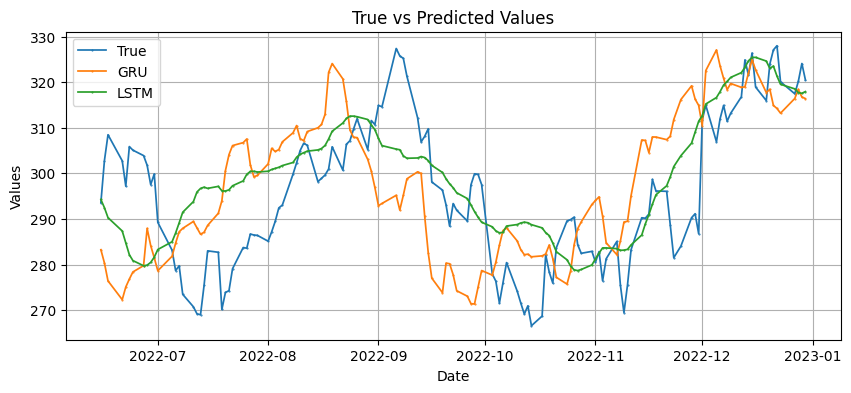

In [478]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

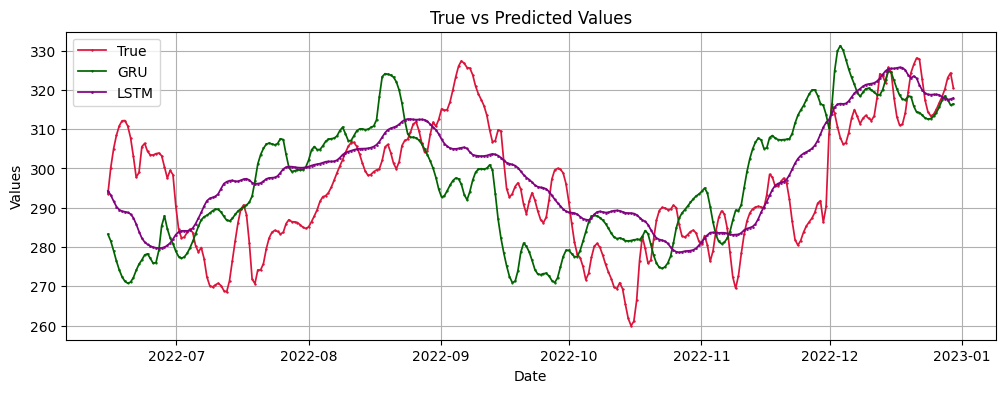

In [479]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## Adobe Inc.

#### Company Data

In [480]:
company = "ADBE"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [481]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [482]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [483]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [484]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [485]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [486]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  330.000000  334.480011  329.170013  334.429993  334.429993   
1 2020-01-03  329.170013  332.980011  328.690002  331.809998  331.809998   
2 2020-01-06  328.290009  333.910004  328.190002  333.709991  333.709991   
3 2020-01-07  334.149994  334.790009  332.309998  333.390015  333.390015   
4 2020-01-08  333.809998  339.230011  333.399994  337.869995  337.869995   

    volume  
0  1990100  
1  1577600  
2  1874700  
3  2500800  
4  2248500

#### Indicators

In [487]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [488]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [489]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [490]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [491]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [492]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [493]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [494]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [495]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [496]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [497]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [498]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [499]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [500]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [501]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  330.000000  334.480011  329.170013  334.429993  334.429993   
1 2020-01-03  329.170013  332.980011  328.690002  331.809998  331.809998   
2 2020-01-06  328.290009  333.910004  328.190002  333.709991  333.709991   
3 2020-01-07  334.149994  334.790009  332.309998  333.390015  333.390015   
4 2020-01-08  333.809998  339.230011  333.399994  337.869995  337.869995   

    volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0  1990100  NaN   NaN  334.429993  ...       NaN          NaN      NaN   
1  1577600  NaN   NaN  333.069611  ...       NaN    -0.007865      NaN   
2  1874700  NaN   NaN  333.299693  ...       NaN     0.005710      NaN   
3  2500800  NaN   NaN  333.324943  ...       NaN    -0.000959      NaN   
4  2248500  NaN   NaN  334.378959  ...       NaN     0.013348      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN       -0.207276         NaN         NaN         NaN  NaN  
2      NaN      NaN        0.188324         NaN         NaN         NaN  NaN  
3      NaN      NaN        0.333973         NaN         NaN         NaN  NaN  
4      NaN      NaN       -0.100888         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [502]:
data = data.ffill().bfill()

#### Preprocessing

In [503]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [504]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [505]:
df_indicators

date       close   volume         ma7        ma21       26ema  \
0   2020-01-02  334.429993  1990100  335.924286  344.954763  334.429993   
1   2020-01-03  331.809998  1577600  335.924286  344.954763  333.069611   
2   2020-01-06  333.709991  1874700  335.924286  344.954763  333.299693   
3   2020-01-07  333.390015  2500800  335.924286  344.954763  333.324943   
4   2020-01-08  337.869995  2248500  335.924286  344.954763  334.378959   
..         ...         ...      ...         ...         ...         ...   
751 2022-12-23  338.450012  1629800  335.797145  335.566190  333.055800   
752 2022-12-27  335.089996  1464300  336.708575  335.603809  333.206481   
753 2022-12-28  328.329987  1672100  335.250000  335.573332  332.845259   
754 2022-12-29  337.579987  1793100  336.509997  336.087617  333.195980   
755 2022-12-30  336.529999  1740900  336.268568  335.687618  333.442944   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0    334.429993  0.000000  7.562779  359.771057  ...  342.839166    -0.007865   
1    333.010829 -0.058782  7.562779  359.771057  ...  342.839166    -0.007865   
2    333.283712 -0.015981  7.562779  359.771057  ...  342.839166     0.005710   
3    333.317268 -0.007676  7.562779  359.771057  ...  342.839166    -0.000959   
4    334.554227  0.175268  7.562779  359.771057  ...  342.839166     0.013348   
..          ...       ...       ...         ...  ...         ...          ...   
751  336.278325  3.222525  5.965721  347.560941  ...  318.113332     0.005719   
752  336.095505  2.889024  5.759551  347.454601  ...  319.111499    -0.009977   
753  334.900810  2.055551  5.639040  347.291078  ...  319.829665    -0.020380   
754  335.312991  2.117011  5.253661  346.152821  ...  320.539832     0.027783   
755  335.500223  2.057279  4.870319  345.007137  ...  321.192331    -0.003115   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.129872  0.161480  0.719676       -0.207276    3.535136    4.678036   
1    0.129872  0.161480  0.719676       -0.207276    3.535136    4.678036   
2    0.129872  0.161480  0.719676        0.188324    3.535136    4.678036   
3    0.129872  0.161480  0.719676        0.333973    3.535136    4.678036   
4    0.129872  0.161480  0.719676       -0.100888    3.535136    4.678036   
..        ...       ...       ...             ...         ...         ...   
751  0.360779  0.339580  0.408159       -0.297288    8.638562    6.947036   
752  0.346471  0.326483  0.408009       -0.101546    8.417917    6.905880   
753  0.349979  0.331470  0.405107        0.141911    8.404708    6.885451   
754  0.383907  0.338342  0.403381        0.072364    8.387850    6.859268   
755  0.338755  0.332407  0.403339       -0.029112    7.577678    6.789742   

     Volu60d_ff        atr  
0      4.463547   4.765714  
1      4.463547   4.765714  
2      4.463547   4.765714  
3      4.463547   4.765714  
4      4.463547   4.765714  
..          ...        ...  
751    5.990471  11.716433  
752    5.989393  11.657148  
753    5.974520  12.060719  
754    5.965458  12.012148  
755    5.940146  11.994289  

[756 rows x 27 columns]

In [506]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [507]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [508]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.128591  0.039738  0.140587  0.127868  0.079167  0.116369   
754 2022-12-29  0.150979  0.044178  0.143787  0.129224  0.080156  0.117459   
755 2022-12-30  0.148438  0.042263  0.143174  0.128169  0.080852  0.117955   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.628301  0.018065    0.112288  ...  0.032501     0.471104  0.175827   
754  0.629415  0.009009    0.109563  ...  0.034675     0.609914  0.197839   
755  0.628332  0.000000    0.106820  ...  0.036673     0.520863  0.168545   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.231274  0.415052        0.089609     0.15379    0.176273    0.151488   
754  0.238609  0.412446        0.081816     0.15337    0.175049    0.150836   
755  0.232274  0.412382        0.070445     0.13321    0.171798    0.149015   

          atr  
753  0.254197  
754  0.252520  
755  0.251904  

[3 rows x 27 columns]

In [509]:
df_time_series = df_normalized.set_index('date')

In [510]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [511]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.308106  0.078437  0.308145  0.296401  0.286245  0.289908   
2022-05-26  0.322870  0.067165  0.307764  0.297745  0.286727  0.293201   
2022-05-27  0.370356  0.109031  0.318769  0.299967  0.291270  0.303971   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.486227  0.139794    0.289192    0.365135  ...  0.356007   
2022-05-26  0.505689  0.137564    0.288506    0.365357  ...  0.352813   
2022-05-27  0.550270  0.178290    0.300667    0.360953  ...  0.351238   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.559277  0.174668  0.340683  0.503025        0.077792   
2022-05-26     0.573192  0.168149  0.341853  0.504141        0.061083   
2022-05-27     0.665011  0.176840  0.358544  0.516404        0.126546   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.011766    0.008123    0.104023  0.432846  
2022-05-26    0.011727    0.000000    0.103951  0.409800  
2022-05-27    0.033967    0.010797    0.109044  0.419167  

[3 rows x 26 columns]

In [512]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [513]:
time_steps = 14

In [514]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [515]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [516]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [517]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 8s 127ms/step - loss: 0.0905 - val_loss: 0.0055
Epoch 2/50
15/15 [==============================] - 1s 49ms/step - loss: 0.0187 - val_loss: 0.0231
Epoch 3/50
15/15 [==============================] - 1s 47ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 4/50
15/15 [==============================] - 1s 45ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 5/50
15/15 [==============================] - 1s 48ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 6/50
15/15 [==============================] - 1s 45ms/step - loss: 0.0054 - val_loss: 0.0073
Epoch 7/50
15/15 [==============================] - 1s 44ms/step - loss: 0.0044 - val_loss: 0.0054
Epoch 8/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 9/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 10/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 11

In [518]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### L S T M

In [519]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [520]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 121ms/step - loss: 0.0688 - val_loss: 0.0131
Epoch 2/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0150 - val_loss: 0.0040
Epoch 3/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0100 - val_loss: 0.0058
Epoch 4/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0082 - val_loss: 0.0056
Epoch 5/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0073 - val_loss: 0.0042
Epoch 6/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0067 - val_loss: 0.0027
Epoch 7/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0064 - val_loss: 0.0030
Epoch 8/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 9/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 10/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0055 - val_loss: 0.0042
Epoch 11

In [521]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### Initial Reports

In [522]:
true_val = X_test[:,0,0]

In [523]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.308105606
Example 2 ---> Value 0.322869520
Example 3 ---> Value 0.370356017

             L S T M            
Example 1 ---> Value 0.328404248
Example 2 ---> Value 0.310070515
Example 3 ---> Value 0.291870862

              G R U             
Example 1 ---> Value 0.263374656
Example 2 ---> Value 0.262000889
Example 3 ---> Value 0.240494519


#### Inverse Scaling

In [524]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [525]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [526]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [527]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 402.500000000
Example 2 ---> Value 408.600006104
Example 3 ---> Value 428.220001221

             L S T M            
Example 1 ---> Value 410.886779785
Example 2 ---> Value 403.311828613
Example 3 ---> Value 395.792297363

              G R U             
Example 1 ---> Value 384.018524170
Example 2 ---> Value 383.450927734
Example 3 ---> Value 374.565124512


In [528]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.308106  0.078437  0.308145  0.296401  0.286245  0.289908   
2022-05-26  0.322870  0.067165  0.307764  0.297745  0.286727  0.293201   
2022-05-27  0.370356  0.109031  0.318769  0.299967  0.291270  0.303971   
2022-05-31  0.341942  0.269898  0.326786  0.302546  0.293025  0.308307   
2022-06-01  0.346008  0.103508  0.333703  0.303911  0.295001  0.312660   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.486227  0.139794    0.289192    0.365135  ...  0.356007   
2022-05-26  0.505689  0.137564    0.288506    0.365357  ...  0.352813   
2022-05-27  0.550270  0.178290    0.300667    0.360953  ...  0.351238   
2022-05-31  0.568693  0.187799    0.303704    0.360122  ...  0.349419   
2022-06-01  0.585811  0.198871    0.307226    0.359140  ...  0.348408   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.559277  0.174668  0.340683  0.503025        0.077792   
2022-05-26     0.573192  0.168149  0.341853  0.504141        0.061083   
2022-05-27     0.665011  0.176840  0.358544  0.516404        0.126546   
2022-05-31     0.449723  0.199479  0.364955  0.519867        0.211676   
2022-06-01     0.541443  0.194856  0.358076  0.513591        0.009750   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.011766    0.008123    0.104023  0.432846  
2022-05-26    0.011727    0.000000    0.103951  0.409800  
2022-05-27    0.033967    0.010797    0.109044  0.419167  
2022-05-31    0.113251    0.079843    0.145997  0.392990  
2022-06-01    0.136670    0.092551    0.154482  0.372236  

[5 rows x 26 columns]

In [529]:
test.reset_index(inplace=True)

In [530]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.308106  0.078437  0.308145  0.296401  0.286245  0.289908   
1 2022-05-26  0.322870  0.067165  0.307764  0.297745  0.286727  0.293201   
2 2022-05-27  0.370356  0.109031  0.318769  0.299967  0.291270  0.303971   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.486227  0.139794    0.289192  ...  0.356007     0.559277  0.174668   
1  0.505689  0.137564    0.288506  ...  0.352813     0.573192  0.168149   
2  0.550270  0.178290    0.300667  ...  0.351238     0.665011  0.176840   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.340683  0.503025        0.077792    0.011766    0.008123    0.104023   
1  0.341853  0.504141        0.061083    0.011727    0.000000    0.103951   
2  0.358544  0.516404        0.126546    0.033967    0.010797    0.109044   

        atr  
0  0.432846  
1  0.409800  
2  0.419167  

[3 rows x 27 columns]

In [531]:
results = pd.DataFrame()

In [532]:
results['date'] = test['date'].tail(len(X_test))

In [533]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [534]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [535]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  328.970001  335.026276  354.258575
143 2022-12-19  326.779999  329.049774  358.791870
144 2022-12-20  344.929993  330.463684  361.492188
145 2022-12-21  344.109985  333.200684  362.939026
146 2022-12-22  341.529999  338.102356  363.896027
147 2022-12-23  334.089996  338.270325  364.195068
148 2022-12-27  331.149994  340.301819  364.510254
149 2022-12-28  326.679993  340.408417  364.800049
150 2022-12-29  332.579987  336.859283  364.618896
151 2022-12-30  330.640015  337.814819  364.639587

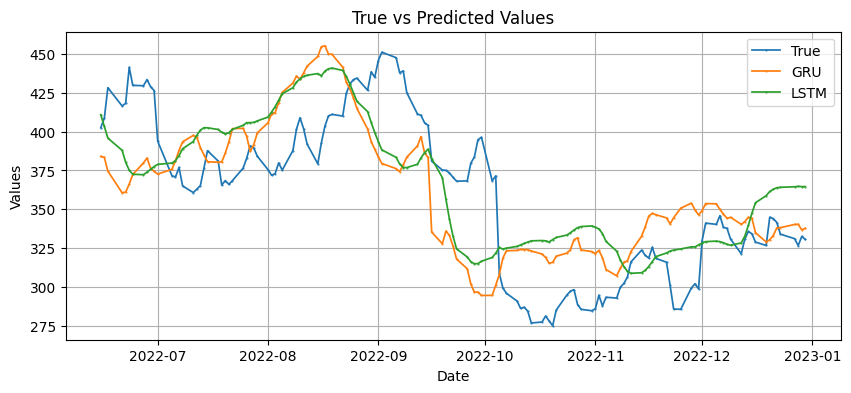

In [536]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

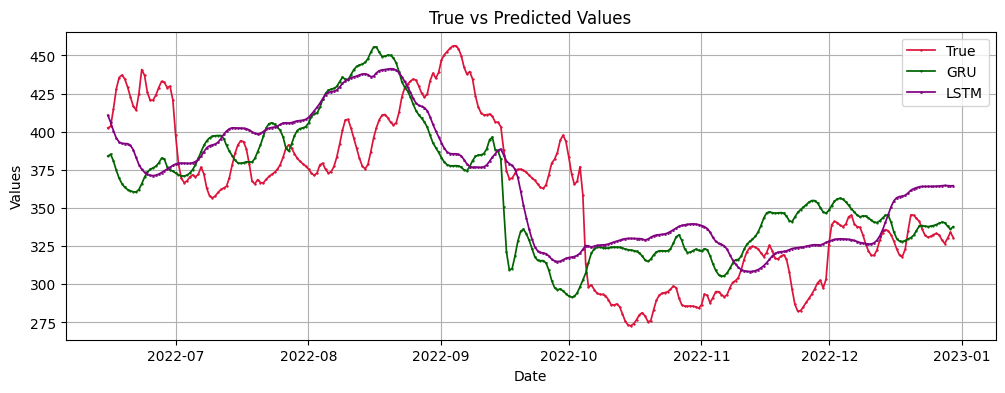

In [537]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## Costco Wholesale Corp.

#### Company Data

In [538]:
company = "COST"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [539]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [540]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [541]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [542]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [543]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [544]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  294.059998  294.579987  291.000000  291.489990  275.580139   
1 2020-01-03  290.049988  292.899994  289.329987  291.730011  275.807068   
2 2020-01-06  290.549988  292.070007  288.619995  291.809998  275.882660   
3 2020-01-07  291.320007  291.690002  289.279999  291.350006  275.447754   
4 2020-01-08  290.989990  295.480011  290.500000  294.690002  278.605530   

    volume  
0  2103600  
1  1926000  
2  2655100  
3  1963400  
4  2492800

#### Indicators

In [545]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [546]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [547]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [548]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [549]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [550]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [551]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [552]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [553]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [554]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [555]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [556]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [557]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [558]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [559]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  294.059998  294.579987  291.000000  291.489990  275.580139   
1 2020-01-03  290.049988  292.899994  289.329987  291.730011  275.807068   
2 2020-01-06  290.549988  292.070007  288.619995  291.809998  275.882660   
3 2020-01-07  291.320007  291.690002  289.279999  291.350006  275.447754   
4 2020-01-08  290.989990  295.480011  290.500000  294.690002  278.605530   

    volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0  2103600  NaN   NaN  291.489990  ...       NaN          NaN      NaN   
1  1926000  NaN   NaN  291.614616  ...       NaN     0.000823      NaN   
2  2655100  NaN   NaN  291.684815  ...       NaN     0.000274      NaN   
3  1963400  NaN   NaN  291.591217  ...       NaN    -0.001578      NaN   
4  2492800  NaN   NaN  292.309838  ...       NaN     0.011399      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN       -0.084427         NaN         NaN         NaN  NaN  
2      NaN      NaN        0.378557         NaN         NaN         NaN  NaN  
3      NaN      NaN       -0.260517         NaN         NaN         NaN  NaN  
4      NaN      NaN        0.269634         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [560]:
data = data.ffill().bfill()

#### Preprocessing

In [561]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [562]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [563]:
df_indicators

date       close   volume         ma7        ma21       26ema  \
0   2020-01-02  291.489990  2103600  293.961430  302.823335  291.489990   
1   2020-01-03  291.730011  1926000  293.961430  302.823335  291.614616   
2   2020-01-06  291.809998  2655100  293.961430  302.823335  291.684815   
3   2020-01-07  291.350006  1963400  293.961430  302.823335  291.591217   
4   2020-01-08  294.690002  2492800  293.961430  302.823335  292.309838   
..         ...         ...      ...         ...         ...         ...   
751 2022-12-23  462.649994  1229500  460.747144  487.239999  483.337361   
752 2022-12-27  458.500000  1230800  459.974287  483.660953  481.497557   
753 2022-12-28  452.989990  1324100  458.765712  479.950001  479.385885   
754 2022-12-29  456.529999  1465000  458.465711  476.500952  477.692857   
755 2022-12-30  456.500000  1803200  458.277139  472.560476  476.123015   

          12ema       MACD       20sd  upper_band  ...    close_60  \
0    291.489990   0.000000   7.907935  318.504373  ...  303.949000   
1    291.620001   0.005385   7.907935  318.504373  ...  303.949000   
2    291.694157   0.009342   7.907935  318.504373  ...  303.949000   
3    291.585522  -0.005695   7.907935  318.504373  ...  303.949000   
4    292.428998   0.119160   7.907935  318.504373  ...  303.949000   
..          ...        ...        ...         ...  ...         ...   
751  470.877284 -12.460077  24.767021  534.453041  ...  490.560831   
752  468.973086 -12.524470  22.912122  527.122245  ...  490.331331   
753  466.514149 -12.871737  20.794033  519.087565  ...  489.918998   
754  464.978126 -12.714731  15.389521  504.142542  ...  489.425664   
755  463.673799 -12.449217  14.033988  499.063476  ...  489.028664   

     Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  \
0       0.000823  0.110161  0.142759  0.464366       -0.084427    4.078754   
1       0.000823  0.110161  0.142759  0.464366       -0.084427    4.078754   
2       0.000274  0.110161  0.142759  0.464366        0.378557    4.078754   
3      -0.001578  0.110161  0.142759  0.464366       -0.260517    4.078754   
4       0.011399  0.110161  0.142759  0.464366        0.269634    4.078754   
..           ...       ...       ...       ...             ...         ...   
751     0.008553  0.236326  0.281912  0.294606       -0.354966    6.389814   
752    -0.009011  0.223788  0.281306  0.293790        0.001057    5.936045   
753    -0.012090  0.221612  0.281497  0.293656        0.075804    5.896130   
754     0.007784  0.233800  0.262261  0.291745        0.106412    5.818688   
755    -0.000066  0.123201  0.262612  0.290851        0.230853    5.045501   

     Volu30d_ff  Volu60d_ff        atr  
0      4.512976    5.061139   3.984286  
1      4.512976    5.061139   3.984286  
2      4.512976    5.061139   3.984286  
3      4.512976    5.061139   3.984286  
4      4.512976    5.061139   3.984286  
..          ...         ...        ...  
751    7.674736    6.561152  11.013569  
752    7.627312    6.551953  10.534286  
753    7.569461    6.548682  10.533572  
754    7.519652    6.543511  10.260716  
755    7.461089    6.514428   9.286431  

[756 rows x 27 columns]

In [564]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [565]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [566]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.527544  0.066143  0.565098  0.646636  0.662384  0.591650   
754 2022-12-29  0.538330  0.082214  0.564114  0.634689  0.656416  0.586496   
755 2022-12-30  0.538239  0.120788  0.563497  0.621039  0.650882  0.582119   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.398332  0.429814    0.663581  ...  0.763023     0.530391  0.192728   
754  0.401343  0.300902    0.616202  ...  0.761025     0.617592  0.207814   
755  0.406433  0.268569    0.600101  ...  0.759416     0.583150  0.070908   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.313748  0.451693        0.218811    0.310233    0.551028    0.530892   
754  0.279317  0.446777        0.228084    0.304305    0.545087    0.529922   
755  0.279946  0.444478        0.265784    0.245114    0.538103    0.524468   

          atr  
753  0.377270  
754  0.362090  
755  0.307888  

[3 rows x 27 columns]

In [567]:
df_time_series = df_normalized.set_index('date')

In [568]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [569]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.488300  0.282969  0.497299  0.683728  0.707626  0.567650   
2022-05-26  0.564107  0.590072  0.485371  0.669033  0.700515  0.570555   
2022-05-27  0.581688  0.567489  0.504733  0.653983  0.695438  0.575993   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.015137  0.978141    0.840997    0.446393  ...  0.956325   
2022-05-26  0.070411  0.895804    0.803733    0.453534  ...  0.952070   
2022-05-27  0.129092  0.856820    0.783708    0.454302  ...  0.947864   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.607429  0.821865  0.712987  0.720569        0.174189   
2022-05-26     0.824716  0.910223  0.764129  0.763242        0.448770   
2022-05-27     0.637548  0.900264  0.769378  0.764212        0.185709   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.967490    0.684501    0.648460  0.821737  
2022-05-26    0.990821    0.715821    0.680335  0.859249  
2022-05-27    0.983029    0.716295    0.671220  0.887264  

[3 rows x 26 columns]

In [570]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [571]:
time_steps = 14

In [572]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [573]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [574]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [575]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 123ms/step - loss: 0.0235 - val_loss: 0.0223
Epoch 2/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0045 - val_loss: 0.0170
Epoch 3/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0026 - val_loss: 0.0092
Epoch 4/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 5/50
15/15 [==============================] - 0s 33ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 6/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0061
Epoch 7/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0014 - val_loss: 0.0063
Epoch 8/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0013 - val_loss: 0.0056
Epoch 9/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 10/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 11

In [576]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 8ms/step


#### L S T M

In [577]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [578]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 192ms/step - loss: 0.0385 - val_loss: 0.0695
Epoch 2/50
15/15 [==============================] - 1s 46ms/step - loss: 0.0064 - val_loss: 0.0105
Epoch 3/50
15/15 [==============================] - 1s 44ms/step - loss: 0.0037 - val_loss: 0.0098
Epoch 4/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0027 - val_loss: 0.0115
Epoch 5/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0031 - val_loss: 0.0134
Epoch 6/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0024 - val_loss: 0.0118
Epoch 7/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0022 - val_loss: 0.0122
Epoch 8/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0024 - val_loss: 0.0123
Epoch 9/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0017 - val_loss: 0.0127
Epoch 10/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0019 - val_loss: 0.0180
Epoch 11

In [579]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 2s 10ms/step


#### Initial Reports

In [580]:
true_val = X_test[:,0,0]

In [581]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.488299781
Example 2 ---> Value 0.564107235
Example 3 ---> Value 0.581688039

             L S T M            
Example 1 ---> Value 0.671936274
Example 2 ---> Value 0.669562817
Example 3 ---> Value 0.664995909

              G R U             
Example 1 ---> Value 0.611024499
Example 2 ---> Value 0.611636639
Example 3 ---> Value 0.595921159


#### Inverse Scaling

In [582]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [583]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [584]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [585]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 440.109985352
Example 2 ---> Value 464.989990234
Example 3 ---> Value 470.760009766

             L S T M            
Example 1 ---> Value 500.379486084
Example 2 ---> Value 499.600524902
Example 3 ---> Value 498.101654053

              G R U             
Example 1 ---> Value 480.388244629
Example 2 ---> Value 480.589141846
Example 3 ---> Value 475.431335449


In [586]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.488300  0.282969  0.497299  0.683728  0.707626  0.567650   
2022-05-26  0.564107  0.590072  0.485371  0.669033  0.700515  0.570555   
2022-05-27  0.581688  0.567489  0.504733  0.653983  0.695438  0.575993   
2022-05-31  0.567855  0.419771  0.524998  0.643179  0.689552  0.578249   
2022-06-01  0.539732  0.179666  0.543985  0.631309  0.681691  0.575394   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.015137  0.978141    0.840997    0.446393  ...  0.956325   
2022-05-26  0.070411  0.895804    0.803733    0.453534  ...  0.952070   
2022-05-27  0.129092  0.856820    0.783708    0.454302  ...  0.947864   
2022-05-31  0.174004  0.816105    0.762942    0.455266  ...  0.943862   
2022-06-01  0.200443  0.771905    0.739924    0.455793  ...  0.939032   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.607429  0.821865  0.712987  0.720569        0.174189   
2022-05-26     0.824716  0.910223  0.764129  0.763242        0.448770   
2022-05-27     0.637548  0.900264  0.769378  0.764212        0.185709   
2022-05-31     0.540919  0.900613  0.768811  0.763007        0.127247   
2022-06-01     0.495703  0.904526  0.758791  0.766358        0.051705   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.967490    0.684501    0.648460  0.821737  
2022-05-26    0.990821    0.715821    0.680335  0.859249  
2022-05-27    0.983029    0.716295    0.671220  0.887264  
2022-05-31    0.974891    0.721860    0.675623  0.878403  
2022-06-01    1.000000    0.740605    0.689594  0.853010  

[5 rows x 26 columns]

In [587]:
test.reset_index(inplace=True)

In [588]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.488300  0.282969  0.497299  0.683728  0.707626  0.567650   
1 2022-05-26  0.564107  0.590072  0.485371  0.669033  0.700515  0.570555   
2 2022-05-27  0.581688  0.567489  0.504733  0.653983  0.695438  0.575993   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.015137  0.978141    0.840997  ...  0.956325     0.607429  0.821865   
1  0.070411  0.895804    0.803733  ...  0.952070     0.824716  0.910223   
2  0.129092  0.856820    0.783708  ...  0.947864     0.637548  0.900264   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.712987  0.720569        0.174189    0.967490    0.684501    0.648460   
1  0.764129  0.763242        0.448770    0.990821    0.715821    0.680335   
2  0.769378  0.764212        0.185709    0.983029    0.716295    0.671220   

        atr  
0  0.821737  
1  0.859249  
2  0.887264  

[3 rows x 27 columns]

In [589]:
results = pd.DataFrame()

In [590]:
results['date'] = test['date'].tail(len(X_test))

In [591]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [592]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [593]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  530.919983  481.722595  494.360809
143 2022-12-19  528.960022  479.985443  492.888428
144 2022-12-20  539.250000  483.371826  492.002686
145 2022-12-21  503.859985  481.066406  491.588715
146 2022-12-22  494.529999  483.866241  492.477356
147 2022-12-23  488.660004  480.168640  492.820618
148 2022-12-27  481.160004  482.963196  493.810150
149 2022-12-28  481.970001  481.123657  495.207886
150 2022-12-29  481.420013  476.631134  496.306915
151 2022-12-30  483.019989  477.057495  497.402283

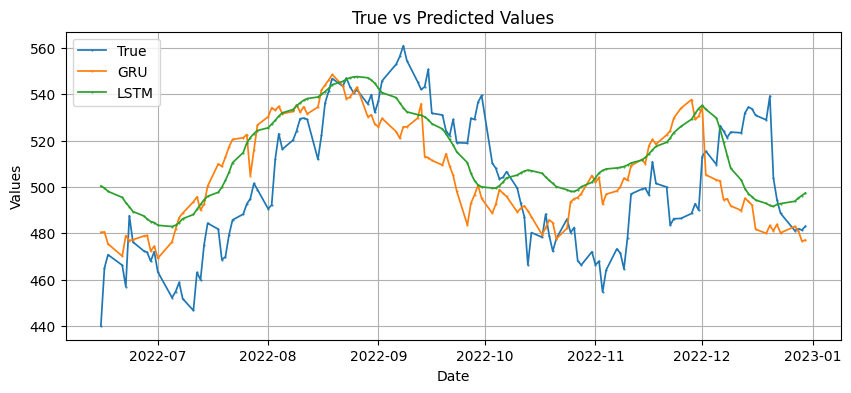

In [594]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

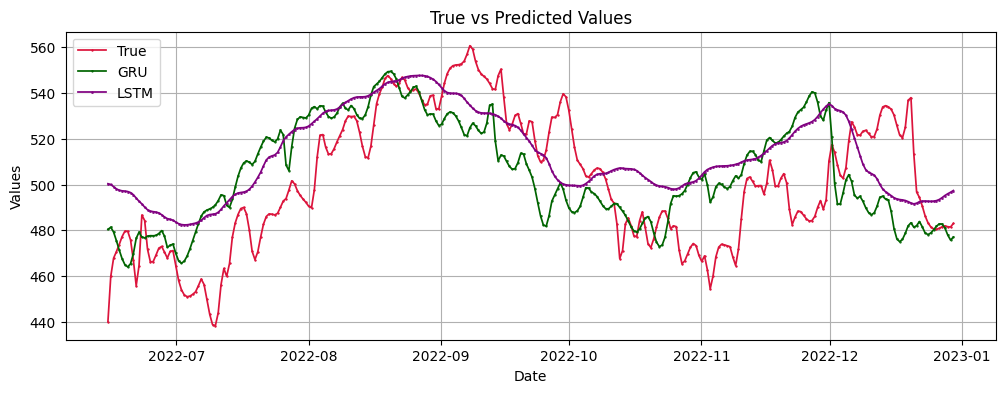

In [595]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## Pepsico Inc.

#### Company Data

In [596]:
company = "PEP"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [597]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [598]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [599]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [600]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [601]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [602]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  136.869995  137.229996  135.139999  135.820007  122.326935   
1 2020-01-03  135.460007  136.789993  135.130005  135.630005  122.155838   
2 2020-01-06  135.300003  136.320007  135.199997  136.149994  122.624168   
3 2020-01-07  136.000000  136.070007  133.949997  134.009995  120.696770   
4 2020-01-08  134.460007  135.360001  134.070007  134.699997  121.318222   

    volume  
0  3784100  
1  4000100  
2  4085100  
3  5718100  
4  3681400

#### Indicators

In [603]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [604]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [605]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [606]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [607]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [608]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [609]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [610]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [611]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [612]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [613]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [614]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [615]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [616]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [617]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  136.869995  137.229996  135.139999  135.820007  122.326935   
1 2020-01-03  135.460007  136.789993  135.130005  135.630005  122.155838   
2 2020-01-06  135.300003  136.320007  135.199997  136.149994  122.624168   
3 2020-01-07  136.000000  136.070007  133.949997  134.009995  120.696770   
4 2020-01-08  134.460007  135.360001  134.070007  134.699997  121.318222   

    volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0  3784100  NaN   NaN  135.820007  ...       NaN          NaN      NaN   
1  4000100  NaN   NaN  135.721352  ...       NaN    -0.001400      NaN   
2  4085100  NaN   NaN  135.875359  ...       NaN     0.003827      NaN   
3  5718100  NaN   NaN  135.353885  ...       NaN    -0.015843      NaN   
4  3681400  NaN   NaN  135.202245  ...       NaN     0.005136      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN        0.057081         NaN         NaN         NaN  NaN  
2      NaN      NaN        0.021249         NaN         NaN         NaN  NaN  
3      NaN      NaN        0.399745         NaN         NaN         NaN  NaN  
4      NaN      NaN       -0.356185         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [618]:
data = data.ffill().bfill()

#### Preprocessing

In [619]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [620]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [621]:
df_indicators

date       close   volume         ma7        ma21       26ema  \
0   2020-01-02  135.820007  3784100  135.089999  139.192857  135.820007   
1   2020-01-03  135.630005  4000100  135.089999  139.192857  135.721352   
2   2020-01-06  136.149994  4085100  135.089999  139.192857  135.875359   
3   2020-01-07  134.009995  5718100  135.089999  139.192857  135.353885   
4   2020-01-08  134.699997  3681400  135.089999  139.192857  135.202245   
..         ...         ...      ...         ...         ...         ...   
751 2022-12-23  182.259995  2197800  181.287140  182.938570  181.749443   
752 2022-12-27  183.070007  3045000  181.689998  182.889046  181.847262   
753 2022-12-28  181.750000  2694300  181.891427  182.787141  181.840058   
754 2022-12-29  181.979996  2549200  181.982856  182.758094  181.850423   
755 2022-12-30  180.660004  3136200  181.901428  182.527142  181.762244   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0    135.820007  0.000000  3.581421  146.214340  ...  135.555167    -0.001400   
1    135.717089 -0.004263  3.581421  146.214340  ...  135.555167    -0.001400   
2    135.886052  0.010693  3.581421  146.214340  ...  135.555167     0.003827   
3    135.293854 -0.060031  3.581421  146.214340  ...  135.555167    -0.015843   
4    135.132505 -0.069740  3.581421  146.214340  ...  135.555167     0.005136   
..          ...       ...       ...         ...  ...         ...          ...   
751  182.067942  0.318499  1.663860  186.207719  ...  177.880833     0.006440   
752  182.222106  0.374843  1.647687  186.134373  ...  178.211000     0.004434   
753  182.149474  0.309416  1.664983  186.126965  ...  178.486000    -0.007237   
754  182.123400  0.272977  1.545031  185.710562  ...  178.733833     0.001265   
755  181.898263  0.136018  1.396818  185.152135  ...  178.978167    -0.007280   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.144352  0.115057  0.651559        0.057081    4.750481    4.016513   
1    0.144352  0.115057  0.651559        0.057081    4.750481    4.016513   
2    0.144352  0.115057  0.651559        0.021249    4.750481    4.016513   
3    0.144352  0.115057  0.651559        0.399745    4.750481    4.016513   
4    0.144352  0.115057  0.651559       -0.356185    4.750481    4.016513   
..        ...       ...       ...             ...         ...         ...   
751  0.118628  0.139000  0.197098       -0.489442    9.946984    9.926332   
752  0.118262  0.125270  0.191858        0.385476    9.834571    9.964977   
753  0.123023  0.125152  0.191560       -0.115172    9.879471    9.935961   
754  0.123208  0.125058  0.190511       -0.053854    9.883310    9.931410   
755  0.092821  0.126095  0.190627        0.230268    9.910562    9.922611   

     Volu60d_ff       atr  
0      4.450131  1.639287  
1      4.450131  1.639287  
2      4.450131  1.639287  
3      4.450131  1.639287  
4      4.450131  1.639287  
..          ...       ...  
751    7.498244  2.803571  
752    7.525661  2.643572  
753    7.522143  2.725001  
754    7.518691  2.610001  
755    7.500950  2.719286  

[756 rows x 27 columns]

In [622]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [623]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [624]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.949372  0.093087  0.960882  0.990756  0.997015  0.978432   
754 2022-12-29  0.952178  0.085629  0.962164  0.990293  0.997194  0.978034   
755 2022-12-30  0.936074  0.115801  0.961022  0.986609  0.995670  0.974597   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.735310  0.084134    0.960893  ...  0.990232     0.469608  0.058130   
754  0.732044  0.073419    0.953169  ...  0.995151     0.504590  0.058260   
755  0.719771  0.060180    0.942810  ...  1.000000     0.469429  0.036888   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.030461  0.135053        0.176972    0.499278    0.713486    0.603382   
754  0.030350  0.133267        0.195007    0.499504    0.713030    0.602808   
755  0.031567  0.133464        0.278577    0.501110    0.712148    0.599855   

          atr  
753  0.140646  
754  0.128608  
755  0.140048  

[3 rows x 27 columns]

In [625]:
df_time_series = df_normalized.set_index('date')

In [626]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [627]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.793461  0.251746  0.741898  0.788169  0.780574  0.765170   
2022-05-26  0.807369  0.221564  0.733185  0.784568  0.781586  0.769698   
2022-05-27  0.827620  0.299678  0.749449  0.780216  0.784649  0.777429   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.605685  0.322042    0.819517    0.760071  ...  0.778554   
2022-05-26  0.627012  0.287235    0.798206    0.765266  ...  0.780404   
2022-05-27  0.656506  0.287397    0.798329    0.765258  ...  0.783215   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.527488  0.247819  0.229467  0.222964        0.185439   
2022-05-26     0.527056  0.249132  0.230400  0.220929        0.180971   
2022-05-27     0.539347  0.241786  0.231486  0.221106        0.296910   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.223553    0.130780    0.392214  0.276581  
2022-05-26    0.221707    0.132178    0.393531  0.276955  
2022-05-27    0.215392    0.138524    0.396507  0.258785  

[3 rows x 26 columns]

In [628]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [629]:
time_steps = 14

In [630]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [631]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [632]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [633]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 13s 167ms/step - loss: 0.0590 - val_loss: 0.0545
Epoch 2/50
15/15 [==============================] - 1s 44ms/step - loss: 0.0115 - val_loss: 0.0032
Epoch 3/50
15/15 [==============================] - 1s 46ms/step - loss: 0.0065 - val_loss: 0.0098
Epoch 4/50
15/15 [==============================] - 1s 45ms/step - loss: 0.0045 - val_loss: 0.0089
Epoch 5/50
15/15 [==============================] - 0s 33ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 6/50
15/15 [==============================] - 0s 34ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 7/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0033 - val_loss: 0.0050
Epoch 8/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 9/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 1

In [634]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### L S T M

In [635]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [636]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 10s 126ms/step - loss: 0.0767 - val_loss: 0.0797
Epoch 2/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0155 - val_loss: 0.0081
Epoch 3/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0098 - val_loss: 0.0198
Epoch 4/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0080 - val_loss: 0.0105
Epoch 5/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0061 - val_loss: 0.0091
Epoch 6/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0065 - val_loss: 0.0116
Epoch 7/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0055 - val_loss: 0.0170
Epoch 8/50
15/15 [==============================] - 1s 45ms/step - loss: 0.0054 - val_loss: 0.0172
Epoch 9/50
15/15 [==============================] - 1s 46ms/step - loss: 0.0052 - val_loss: 0.0087
Epoch 10/50
15/15 [==============================] - 1s 43ms/step - loss: 0.0050 - val_loss: 0.0095
Epoch 1

In [637]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### Initial Reports

In [638]:
true_val = X_test[:,0,0]

In [639]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.793461096
Example 2 ---> Value 0.807368616
Example 3 ---> Value 0.827619974

             L S T M            
Example 1 ---> Value 0.678892851
Example 2 ---> Value 0.673970461
Example 3 ---> Value 0.662979305

              G R U             
Example 1 ---> Value 0.696174622
Example 2 ---> Value 0.697057903
Example 3 ---> Value 0.689594626


#### Inverse Scaling

In [640]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [641]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [642]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [643]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 168.970001221
Example 2 ---> Value 170.110000610
Example 3 ---> Value 171.770004272

             L S T M            
Example 1 ---> Value 159.578842163
Example 2 ---> Value 159.175354004
Example 3 ---> Value 158.274414062

              G R U             
Example 1 ---> Value 160.995422363
Example 2 ---> Value 161.067840576
Example 3 ---> Value 160.456069946


In [644]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.793461  0.251746  0.741898  0.788169  0.780574  0.765170   
2022-05-26  0.807369  0.221564  0.733185  0.784568  0.781586  0.769698   
2022-05-27  0.827620  0.299678  0.749449  0.780216  0.784649  0.777429   
2022-05-31  0.778578  0.654164  0.762569  0.777208  0.782338  0.774527   
2022-06-01  0.763206  0.243157  0.771141  0.776243  0.778584  0.769112   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.605685  0.322042    0.819517    0.760071  ...  0.778554   
2022-05-26  0.627012  0.287235    0.798206    0.765266  ...  0.780404   
2022-05-27  0.656506  0.287397    0.798329    0.765258  ...  0.783215   
2022-05-31  0.651459  0.287418    0.798329    0.765246  ...  0.783877   
2022-06-01  0.639137  0.291340    0.798566    0.763182  ...  0.785213   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.527488  0.247819  0.229467  0.222964        0.185439   
2022-05-26     0.527056  0.249132  0.230400  0.220929        0.180971   
2022-05-27     0.539347  0.241786  0.231486  0.221106        0.296910   
2022-05-31     0.401937  0.248637  0.239601  0.226690        0.512997   
2022-06-01     0.468361  0.248819  0.236376  0.221389        0.038040   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.223553    0.130780    0.392214  0.276581  
2022-05-26    0.221707    0.132178    0.393531  0.276955  
2022-05-27    0.215392    0.138524    0.396507  0.258785  
2022-05-31    0.328566    0.209678    0.447144  0.278301  
2022-06-01    0.382564    0.246303    0.469619  0.293779  

[5 rows x 26 columns]

In [645]:
test.reset_index(inplace=True)

In [646]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.793461  0.251746  0.741898  0.788169  0.780574  0.765170   
1 2022-05-26  0.807369  0.221564  0.733185  0.784568  0.781586  0.769698   
2 2022-05-27  0.827620  0.299678  0.749449  0.780216  0.784649  0.777429   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.605685  0.322042    0.819517  ...  0.778554     0.527488  0.247819   
1  0.627012  0.287235    0.798206  ...  0.780404     0.527056  0.249132   
2  0.656506  0.287397    0.798329  ...  0.783215     0.539347  0.241786   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.229467  0.222964        0.185439    0.223553    0.130780    0.392214   
1  0.230400  0.220929        0.180971    0.221707    0.132178    0.393531   
2  0.231486  0.221106        0.296910    0.215392    0.138524    0.396507   

        atr  
0  0.276581  
1  0.276955  
2  0.258785  

[3 rows x 27 columns]

In [647]:
results = pd.DataFrame()

In [648]:
results['date'] = test['date'].tail(len(X_test))

In [649]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [650]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [651]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  183.889999  177.033417  171.682434
143 2022-12-19  182.589996  175.782394  171.648972
144 2022-12-20  185.509995  176.511078  171.431824
145 2022-12-21  185.899994  177.125000  171.262619
146 2022-12-22  185.690002  177.831757  171.153137
147 2022-12-23  183.119995  177.325378  171.030975
148 2022-12-27  181.630005  178.193756  171.009735
149 2022-12-28  182.179993  179.421143  171.198486
150 2022-12-29  183.779999  179.315903  171.386856
151 2022-12-30  183.100006  179.025665  171.576019

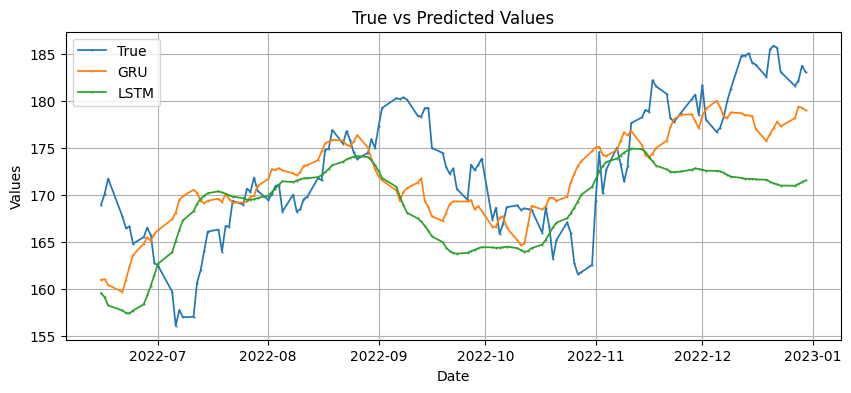

In [652]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

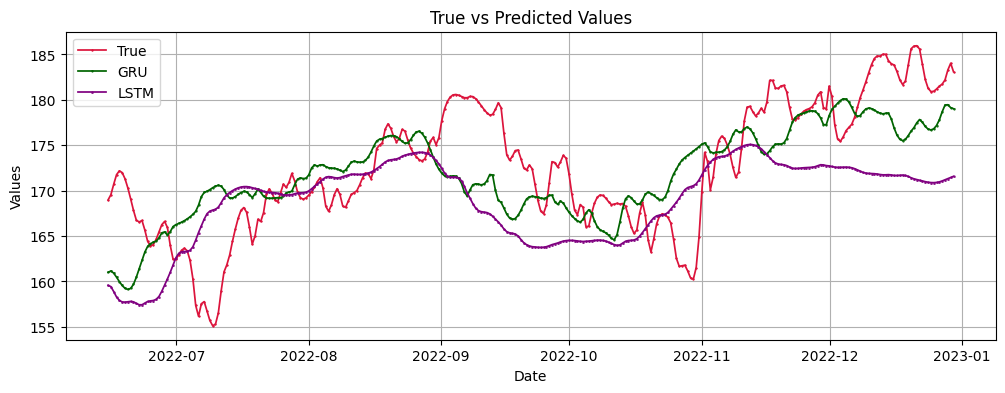

In [653]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## Walmart

#### Company Data

In [654]:
company = "WMT"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [655]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [656]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [657]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [658]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [659]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [660]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  118.860001  119.889999  118.699997  118.940002  112.085136   
1 2020-01-03  118.269997  118.790001  117.589996  117.889999  111.095650   
2 2020-01-06  117.400002  118.089996  116.769997  117.650002  110.869499   
3 2020-01-07  117.260002  117.519997  116.199997  116.559998  109.842293   
4 2020-01-08  116.300003  116.730003  115.680000  116.160004  109.465347   

    volume  
0  6764900  
1  5399200  
2  6445500  
3  6846900  
4  5875800

#### Indicators

In [661]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [662]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [663]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [664]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [665]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [666]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [667]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [668]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [669]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [670]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [671]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [672]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [673]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [674]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [675]:
data.head(5)

date        open        high         low       close   adj_close  \
0 2020-01-02  118.860001  119.889999  118.699997  118.940002  112.085136   
1 2020-01-03  118.269997  118.790001  117.589996  117.889999  111.095650   
2 2020-01-06  117.400002  118.089996  116.769997  117.650002  110.869499   
3 2020-01-07  117.260002  117.519997  116.199997  116.559998  109.842293   
4 2020-01-08  116.300003  116.730003  115.680000  116.160004  109.465347   

    volume  ma7  ma21       26ema  ...  close_60  Log_Returns  Vola10d  \
0  6764900  NaN   NaN  118.940002  ...       NaN          NaN      NaN   
1  5399200  NaN   NaN  118.394809  ...       NaN    -0.008867      NaN   
2  6445500  NaN   NaN  118.127207  ...       NaN    -0.002038      NaN   
3  6846900  NaN   NaN  117.689083  ...       NaN    -0.009308      NaN   
4  5875800  NaN   NaN  117.334484  ...       NaN    -0.003438      NaN   

   Vola30d  Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  atr  
0      NaN      NaN             NaN         NaN         NaN         NaN  NaN  
1      NaN      NaN       -0.201880         NaN         NaN         NaN  NaN  
2      NaN      NaN        0.193788         NaN         NaN         NaN  NaN  
3      NaN      NaN        0.062276         NaN         NaN         NaN  NaN  
4      NaN      NaN       -0.141831         NaN         NaN         NaN  NaN  

[5 rows x 31 columns]

In [676]:
data = data.ffill().bfill()

#### Preprocessing

In [677]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [678]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [679]:
df_indicators

date       close   volume         ma7        ma21       26ema  \
0   2020-01-02  118.940002  6764900  117.277143  116.210952  118.940002   
1   2020-01-03  117.889999  5399200  117.277143  116.210952  118.394809   
2   2020-01-06  117.650002  6445500  117.277143  116.210952  118.127207   
3   2020-01-07  116.559998  6846900  117.277143  116.210952  117.689083   
4   2020-01-08  116.160004  5875800  117.277143  116.210952  117.334484   
..         ...         ...      ...         ...         ...         ...   
751 2022-12-23  143.770004  3182500  143.912857  148.231905  146.024179   
752 2022-12-27  143.809998  3348200  143.691428  147.790952  145.860166   
753 2022-12-28  141.289993  5082100  143.482856  147.209047  145.521635   
754 2022-12-29  142.149994  3057300  143.389997  146.693808  145.271883   
755 2022-12-30  141.789993  3835300  143.067139  146.187618  145.013966   

          12ema      MACD      20sd  upper_band  ...    close_60  Log_Returns  \
0    118.940002  0.000000  1.045372  118.387743  ...  115.431500    -0.008867   
1    118.371251 -0.023558  1.045372  118.387743  ...  115.431500    -0.008867   
2    118.089747 -0.037460  1.045372  118.387743  ...  115.431500    -0.002038   
3    117.606865 -0.082219  1.045372  118.387743  ...  115.431500    -0.009308   
4    117.213758 -0.120726  1.045372  118.387743  ...  115.431500    -0.003438   
..          ...       ...       ...         ...  ...         ...          ...   
751  145.385876 -0.638303  3.853443  155.696886  ...  142.272166     0.002019   
752  145.143433 -0.716733  3.730592  154.966184  ...  142.507333     0.000278   
753  144.550596 -0.971038  3.744244  154.409488  ...  142.653333    -0.017678   
754  144.181273 -1.090610  3.653533  153.714565  ...  142.784999     0.006068   
755  143.813384 -1.200582  3.400913  152.630325  ...  142.932832    -0.002536   

      Vola10d   Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  \
0    0.106439  0.130354  0.495942       -0.201880    2.443986    5.302210   
1    0.106439  0.130354  0.495942       -0.201880    2.443986    5.302210   
2    0.106439  0.130354  0.495942        0.193788    2.443986    5.302210   
3    0.106439  0.130354  0.495942        0.062276    2.443986    5.302210   
4    0.106439  0.130354  0.495942       -0.141831    2.443986    5.302210   
..        ...       ...       ...             ...         ...         ...   
751  0.172503  0.251131  0.232619       -0.270203    8.182184    8.779730   
752  0.134855  0.251105  0.228539        0.052066    8.014012    8.770581   
753  0.154089  0.240697  0.228128        0.517860    8.354110    8.490361   
754  0.162249  0.152067  0.227043       -0.398418    8.628108    8.087172   
755  0.158944  0.150006  0.226027        0.254473    8.634960    7.904295   

     Volu60d_ff       atr  
0      5.628122  1.270002  
1      5.628122  1.270002  
2      5.628122  1.270002  
3      5.628122  1.270002  
4      5.628122  1.270002  
..          ...       ...  
751    7.009566  2.522855  
752    6.994871  2.419998  
753    7.046964  2.456426  
754    7.106578  2.498570  
755    7.107855  2.339999  

[756 rows x 27 columns]

In [680]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [681]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [682]:
df_normalized.tail(3)

date     close    volume       ma7      ma21     26ema     12ema  \
753 2022-12-28  0.667144  0.052100  0.685549  0.797289  0.804998  0.730904   
754 2022-12-29  0.682551  0.003177  0.683501  0.784883  0.798598  0.722364   
755 2022-12-30  0.676102  0.021975  0.676381  0.772694  0.791988  0.713857   

         MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
753  0.577341  0.226751    0.694904  ...  0.840469     0.445321  0.106729   
754  0.567623  0.219898    0.681948  ...  0.844506     0.547905  0.114745   
755  0.558685  0.200811    0.661733  ...  0.849038     0.510736  0.111499   

      Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
753  0.224362  0.282665        0.196365    0.251659    0.405030    0.315343   
754  0.081621  0.280139        0.043211    0.261927    0.376841    0.321147   
755  0.078302  0.277774        0.152340    0.262183    0.364056    0.321271   

          atr  
753  0.160849  
754  0.166341  
755  0.145676  

[3 rows x 27 columns]

In [683]:
df_time_series = df_normalized.set_index('date')

In [684]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [685]:
test.head(3)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.346113  0.147745  0.237453  0.668249  0.650148  0.426914   
2022-05-26  0.393228  0.156409  0.220598  0.635868  0.624561  0.407688   
2022-05-27  0.437657  0.133071  0.239658  0.604073  0.605577  0.400242   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.000000  1.000000    0.970429    0.195508  ...  0.954319   
2022-05-26  0.013573  0.994574    0.939588    0.166663  ...  0.949128   
2022-05-27  0.047609  0.983103    0.911078    0.147209  ...  0.943604   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.495160  0.654397  0.558940  0.577213        0.073737   
2022-05-26     0.612814  0.676966  0.554507  0.584209        0.116436   
2022-05-27     0.605891  0.692393  0.564890  0.582189        0.092629   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.952245    0.896683    0.727366  0.512799  
2022-05-26    0.950197    0.896825    0.727249  0.488132  
2022-05-27    0.947986    0.895232    0.727346  0.473238  

[3 rows x 26 columns]

In [686]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [687]:
time_steps = 14

In [688]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [689]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [690]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [691]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 115ms/step - loss: 0.0521 - val_loss: 0.0249
Epoch 2/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0114 - val_loss: 0.0178
Epoch 3/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0078 - val_loss: 0.0113
Epoch 4/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0063 - val_loss: 0.0110
Epoch 5/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0056 - val_loss: 0.0098
Epoch 6/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0047 - val_loss: 0.0088
Epoch 7/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0052 - val_loss: 0.0091
Epoch 8/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0050 - val_loss: 0.0087
Epoch 9/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0043 - val_loss: 0.0081
Epoch 10/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0036 - val_loss: 0.0077
Epoch 11

In [692]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### L S T M

In [693]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [694]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 10s 188ms/step - loss: 0.1056 - val_loss: 0.0379
Epoch 2/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0218 - val_loss: 0.0218
Epoch 3/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0145 - val_loss: 0.0192
Epoch 4/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0116 - val_loss: 0.0215
Epoch 5/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0109 - val_loss: 0.0176
Epoch 6/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0098 - val_loss: 0.0173
Epoch 7/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0089 - val_loss: 0.0169
Epoch 8/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0083 - val_loss: 0.0152
Epoch 9/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0075 - val_loss: 0.0147
Epoch 10/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0071 - val_loss: 0.0142
Epoch 1

In [695]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 1s 7ms/step


#### Initial Reports

In [696]:
true_val = X_test[:,0,0]

In [697]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.346112548
Example 2 ---> Value 0.393228235
Example 3 ---> Value 0.437656685

             L S T M            
Example 1 ---> Value 0.429919749
Example 2 ---> Value 0.429243892
Example 3 ---> Value 0.429258436

              G R U             
Example 1 ---> Value 0.363373131
Example 2 ---> Value 0.354220867
Example 3 ---> Value 0.357774109


#### Inverse Scaling

In [698]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [699]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [700]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [701]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 123.370002747
Example 2 ---> Value 126.000000000
Example 3 ---> Value 128.479995728

             L S T M            
Example 1 ---> Value 128.048126221
Example 2 ---> Value 128.010391235
Example 3 ---> Value 128.011199951

              G R U             
Example 1 ---> Value 124.333488464
Example 2 ---> Value 123.822608948
Example 3 ---> Value 124.020950317


In [702]:
test.head(5)

close    volume       ma7      ma21     26ema     12ema  \
date                                                                     
2022-05-25  0.346113  0.147745  0.237453  0.668249  0.650148  0.426914   
2022-05-26  0.393228  0.156409  0.220598  0.635868  0.624561  0.407688   
2022-05-27  0.437657  0.133071  0.239658  0.604073  0.605577  0.400242   
2022-05-31  0.440344  0.226597  0.269777  0.576141  0.588283  0.394475   
2022-06-01  0.383375  0.159125  0.289468  0.545721  0.566234  0.378282   

                MACD      20sd  upper_band  lower_band  ...  close_60  \
date                                                    ...             
2022-05-25  0.000000  1.000000    0.970429    0.195508  ...  0.954319   
2022-05-26  0.013573  0.994574    0.939588    0.166663  ...  0.949128   
2022-05-27  0.047609  0.983103    0.911078    0.147209  ...  0.943604   
2022-05-31  0.082185  0.966812    0.881271    0.131671  ...  0.936353   
2022-06-01  0.095199  0.948127    0.846823    0.113557  ...  0.928065   

            Log_Returns   Vola10d   Vola30d   Vola60d  Vol_Pct_Change  \
date                                                                    
2022-05-25     0.495160  0.654397  0.558940  0.577213        0.073737   
2022-05-26     0.612814  0.676966  0.554507  0.584209        0.116436   
2022-05-27     0.605891  0.692393  0.564890  0.582189        0.092629   
2022-05-31     0.526731  0.692441  0.565792  0.572396        0.186525   
2022-06-01     0.413551  0.418708  0.565636  0.579379        0.071871   

            Volu10d_ff  Volu30d_ff  Volu60d_ff       atr  
date                                                      
2022-05-25    0.952245    0.896683    0.727366  0.512799  
2022-05-26    0.950197    0.896825    0.727249  0.488132  
2022-05-27    0.947986    0.895232    0.727346  0.473238  
2022-05-31    0.945953    0.892305    0.729752  0.461603  
2022-06-01    0.074889    0.895104    0.730668  0.465326  

[5 rows x 26 columns]

In [703]:
test.reset_index(inplace=True)

In [704]:
test.head(3)

date     close    volume       ma7      ma21     26ema     12ema  \
0 2022-05-25  0.346113  0.147745  0.237453  0.668249  0.650148  0.426914   
1 2022-05-26  0.393228  0.156409  0.220598  0.635868  0.624561  0.407688   
2 2022-05-27  0.437657  0.133071  0.239658  0.604073  0.605577  0.400242   

       MACD      20sd  upper_band  ...  close_60  Log_Returns   Vola10d  \
0  0.000000  1.000000    0.970429  ...  0.954319     0.495160  0.654397   
1  0.013573  0.994574    0.939588  ...  0.949128     0.612814  0.676966   
2  0.047609  0.983103    0.911078  ...  0.943604     0.605891  0.692393   

    Vola30d   Vola60d  Vol_Pct_Change  Volu10d_ff  Volu30d_ff  Volu60d_ff  \
0  0.558940  0.577213        0.073737    0.952245    0.896683    0.727366   
1  0.554507  0.584209        0.116436    0.950197    0.896825    0.727249   
2  0.564890  0.582189        0.092629    0.947986    0.895232    0.727346   

        atr  
0  0.512799  
1  0.488132  
2  0.473238  

[3 rows x 27 columns]

In [705]:
results = pd.DataFrame()

In [706]:
results['date'] = test['date'].tail(len(X_test))

In [707]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [708]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [709]:
results.tail(10)

date        true         gru        lstm
142 2022-12-16  153.509995  145.679825  142.454407
143 2022-12-19  152.970001  144.359741  142.011383
144 2022-12-20  152.419998  144.145111  141.556641
145 2022-12-21  153.369995  145.384705  141.305603
146 2022-12-22  153.220001  146.043655  141.225906
147 2022-12-23  151.649994  145.186493  141.207520
148 2022-12-27  149.889999  145.097595  141.268188
149 2022-12-28  149.110001  145.224274  141.362854
150 2022-12-29  148.779999  143.974609  141.355209
151 2022-12-30  145.309998  144.105347  141.380417

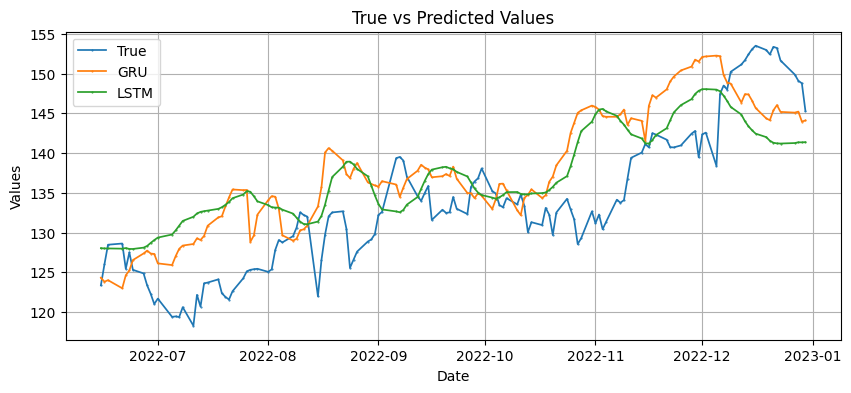

In [710]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

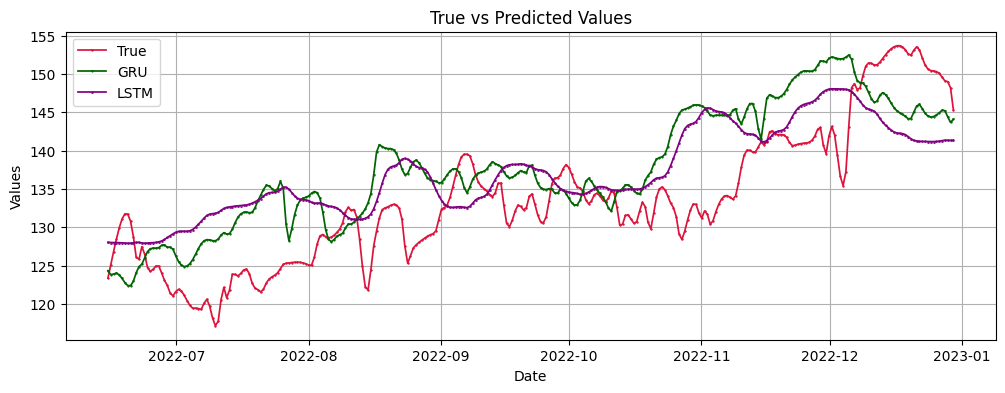

In [711]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()